

# <font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:
# File system management
import os
import sys
import pickle
import dill
from datetime import datetime
import tempfile
#import tensorflow

# Data manipulation
import numpy as np
import numpy.typing as npt
import pandas as pd
from collections import Counter

# Scikit-learn
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_validate,\
    cross_val_score, train_test_split, GridSearchCV, StratifiedKFold,\
    RepeatedStratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_curve,\
    roc_auc_score, f1_score, accuracy_score, average_precision_score,\
    fbeta_score, make_scorer, classification_report, confusion_matrix,\
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,\
    precision_recall_curve
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_sample_weight

# Hyperparameters optimisation
#from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
#from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn import pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
import shap

# Version tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Personnal packages
import tools_dataframe
import tools_preprocessing
import tools_feat_engineering
import tools_modeling

# Data drift
# from evidently.report import Report
# from evidently.metric_preset import DataDriftPreset

# Validation code PEP8
# %load_ext pycodestyle_magic
# %pycodestyle_on

# Warnings
import warnings
# from warnings import simplefilter
# warnings.filterwarnings(action='once')
# simplefilter(action='ignore', category=FutureWarning)
# simplefilter(action='ignore', category=ValueError)
# simplefilter(action='ignore', category=UserWarning)


# Versions
print('Version of used libraries :')

print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
#print('Sklearn               : ' + sklearn.__version__)
#print('Dataframe XG Boost      : ' + xgboost.__version__)
#print('Light GBM     : ' + lightgbm.__version__)
#print('Imblearn      : ' + imblearn.__version__)
#print('MLFlow      : ' + mlflow.__version__)
now = datetime.now().isoformat()
print('\nLaunched on : ' + now)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Version of used libraries :
Python                : 3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
NumPy                 : 1.24.3
Pandas                : 1.5.3

Launched on : 2023-07-25T16:16:56.457968



<a id='notebook_settings'></a>


<br>


---
---

<font size="+1"> **NOTEBOOK SETTINGS** </font>

---


In [2]:
#################################
#    -- NOTEBOOK SETTINGS --    #
#################################

%matplotlib inline
sns.set_theme(palette="Set1")
#palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]
#palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]
#palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]


# Random state
seed = 84


# Define training set size
TRAIN_SIZE = 0.8


# Define table for saving model results of data rebalancing esperiences
df_results = pd.DataFrame()

# Define table for saving model scores
df_scores_models = pd.DataFrame()

# Define table for saving probability threshold evaluation
#df_thresholds = pd.DataFrame()

# Define table for saving probability restults of threshold optimisation
df_results_thresh =pd.DataFrame()



<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---


In [3]:

# -----------------------------------------------------------------------
# -- BUSINESS METRIC
# -----------------------------------------------------------------------

def custom_score(y_real, y_pred, tn_weighting=1, fp_weighting=-1, fn_weighting=-10, tp_weighting=1, **kwargs):
    '''
    Business metric designed to minimise the risk to the bank of granting a loan by penalising false negatives.
    '''
    # tn (true negative): the loan is refunded: the bank earns money. => to maximize
    # fp (false positive) : the loan is denied in error: the bank loses interest, loses profit but does not actually lose money (type I error).
    # fn (false negative) : the loan is approved but the customer defaulting: the bank loses money (type II error). => to minimise
    # tp (true positif) : the loan is rightly denied: the bank neither gains nor loses money.

    '''
    Parameters
    ----------
    y_real : real class, mandatory (0 or 1).
    y_pred : predicted class, mandatory (0 or 1).

    tn_weighting : Weighting of True Negative, optional (1 by default),
    fp_weighting : Weighting of False Positive rate, optional (-1 by default),
    fn_weighting : Weighting of False Negative rate, optional (-10 by default),
    tp_weighting : Weighting of True Positive rate, optional (1 by default),
    kwargs is ignored - added just to avoid errors if used to replace roc_auc_score with parameter zero_division = 0

    Returns
    -------
    score : normalised gain (between 0 and 1) a high score indicates better performance

    '''
    # Confusion matrix
    (tn, fp, fn, tp) = confusion_matrix(y_real, y_pred).ravel()


    # Real Gain
    real_gain = tn * tn_weighting + fp * fp_weighting + fn * fn_weighting + tp * tp_weighting

    # Maximum Gain : all predictions are correct
    gain_max = (fp + tn) * tn_weighting + (fn + tp) * tp_weighting

    # Minimum Gain : all predictions are false
    gain_min = (fp + tn) * fp_weighting + (fn + tp) * fn_weighting

    custom_score = (real_gain - gain_min) / (gain_max - gain_min)

    # Normalised gain (between 0 and 1) a high score indicates better performance
    return custom_score



# -----------------------------------------------------------------------
# -- CONFUSION MATRIX FOR BINARY CLASSIFICATION
# -----------------------------------------------------------------------

def construct_confusion_matrix(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)

    labels = ['Non-Defaulters', 'Defaulters']

    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix for : {title}')
    plt.ylabel('True Class')
    plt.xlabel('Predict Class')
    plt.show()



# ------------------------------------------------------------------------
# -- DATA BALANCE METHODS EVALUATION
# ------------------------------------------------------------------------

def balance_method_analysis(model, X_train, X_val, y_train, y_val,
                            df_results, title, show_table=True,
                            show_confusion_matrix=True):
    """
    Function to evaluate the data balance method that generates the most important score improvement.

    ------------
    @Parameters
    ------------
    model : initialized classification model, mandatory.
    X_train : train set matrix X, mandatory.
    X_val : validation set matrix X, mandatory.
    y_train : train set vecteur y, mandatory.
    y_val : test set, vecteur y, mandatory.
    df_results : dataframe for scores saving, mandatory
    title : experience name to record in the dataframe, mandatory.
    show_table : shows the results table (optional, default = True).

    ------------
    @Returns
    ------------
    df_results : Performance backup dataframe.
    y_pred : predictions from the tested model
    """
    # Start of execution
    time_start = datetime.now()

    # Training the model with the training set
    model.fit(X_train, y_train)

    # End of train exectuion
    time_end_train = datetime.now()

    # Predictions with the validation set
    y_pred = model.predict(X_val)

    # End of prediction exectuion
    time_end = datetime.now()

    # Probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Metrics computing
    # Recall
    recall = recall_score(y_val, y_pred)
    # Precision
    precision = precision_score(y_val, y_pred)
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # F-score ou Fbeta
    f1_score = fbeta_score(y_val, y_pred, beta=1)
    f2_score = fbeta_score(y_val, y_pred, beta=2)
    f5_score = fbeta_score(y_val, y_pred, beta=5)
    f10_score = fbeta_score(y_val, y_pred, beta=10)
    # Score ROC AUC
    roc_auc = roc_auc_score(y_val, y_proba)
    # Score AP
    ap_score = average_precision_score(y_val, y_proba)
    # Business metric
    business_metric = custom_score(y_val, y_pred)

    # Training runtime
    time_exec_train = time_end_train - time_start
    # Training+validation runtime
    time_execution = time_end - time_start

    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_val, y_pred).ravel()

    # cross validation
    scoring = ['accuracy', 'roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Saving Performance dataframe
    df_results = pd.concat([df_results,(pd.DataFrame({
        'Experience': [title],
        'Business_score': [business_metric],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy],
        'F1': [f1_score],
        'F2': [f2_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'AP_SCORE': [ap_score],
        'Train runtime': [time_exec_train],
        'Train+Validatin runtime': [time_execution],
        'TN': [tn],
        'FP': [fp],
        'FN': [fn],
        'TP': [tp],
        # Cross-validation
        'Train_auc_CV': [scores['train_accuracy'].mean()],
        'Train_auc_CV +/-': [scores['train_accuracy'].std()],
        'Test_auc_CV': [scores['test_accuracy'].mean()],
        'Test_auc_CV +/-': [scores['test_accuracy'].std()],
        'Train_roc_auc_CV': [scores['train_roc_auc'].mean()],
        'Train_roc_auc_CV +/-': [scores['train_roc_auc'].std()],
        'Test_roc_auc_CV': [scores['test_roc_auc'].mean()],
        'Test_roc_auc_CV +/-': [scores['test_roc_auc'].std()],
        'Train_recall_CV': [scores['train_recall'].mean()],
        'Train_recall_CV +/-': [scores['train_recall'].std()],
        'Test_recall_CV': [scores['test_recall'].mean()],
        'Test_recall_CV +/-': [scores['test_recall'].std()],
        'Train_precision_CV': [scores['train_precision'].mean()],
        'Train_precision_CV +/-': [scores['train_precision'].std()],
        'Test_precision_CV': [scores['test_precision'].mean()],
        'Test_precision_CV +/-': [scores['test_precision'].std()],
    }))], axis =0)

    #dumping the model to pickle file
    with open('model_tests/df_results_scores.pkl', 'wb') as f:
        pickle.dump(df_results, f)

    if show_table:
        mask = df_results['Experience'] == title
        display(df_results[mask].style.hide(axis="index"))

    if show_confusion_matrix:
        construct_confusion_matrix(y_val, y_pred, title)

    return df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp




In [4]:
# --------------------------------------------------------------------
# -- MLFlow
# --------------------------------------------------------------------
'''Fonctions for experience tracking'''

# ------------------------------------
# -- LOG METRICS REBALANCING ANALYSIS
# ------------------------------------
def log_mlflow_balance(exper_id, model, title, Business_Metric,
                       n_estimator=None, max_depth=None,
                       Recall=None, Precision=None, Accuracy=None,
                       F1_score=None, F2_score=None,
                       F5_score=None, F10_score=None,
                       Roc_auc=None, AP_score=None,
                       TN=None, FP=None, FN=None, TP=None,
                       train_class_0=None, train_class_1=None):

    '''
    Function to log model to MLFlow

    -----------
    @Parameters
    -----------
    exper_id : str, id experiment.
    model : initialized classification model, mandatory.
    title : experience name to record in the dataframe, mandatory.

    Recall : score value, optional (default = None).
    Precision : score value, optional (default = None).
    Accuracy : score value, optional (default = None).
    F1_score : score value, optional (default = None).
    F2_score : score value, optional (default = None).
    F5_score : score value, optional (default = None).
    F10_score : score value, optional (default = None).
    Roc_auc : score value, optional (default = None).
    AP_score : score value, optional (default = None).

    TN: true negative, optional (default = None).
    FP: false positive, optional (default = None).
    FN: false negative, optional (default = None).
    TP: true positif, optional (default = None).

    train_class_0 : optional (default = None).
    train_class_1 : optional (default = None).

    -----------
    @Returns
    -----------
    None
    '''

    # Track params and metrics
    with mlflow.start_run(experiment_id=exper_id):
    # with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", title)

        # Set metrics
        mlflow.log_metric('Recall', Recall)
        mlflow.log_metric('Precision', Precision)
        mlflow.log_metric('Accuracy', Accuracy)
        mlflow.log_metric('F1', F1_score)
        mlflow.log_metric('F2', F2_score)
        mlflow.log_metric('F5', F5_score)
        mlflow.log_metric('F10', F10_score)
        mlflow.log_metric('ROC_AUC', Roc_auc)
        mlflow.log_metric('AP_SCORE', AP_score)
        mlflow.log_metric('Business_score', Business_Metric)
        mlflow.log_metric('TN', TN)
        mlflow.log_metric('FP', FP)
        mlflow.log_metric('FN', FN)
        mlflow.log_metric('TP', TP)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, title)

    mlflow.end_run()


# ------------------------------------
# -- LOG CROSS VALIDATION PARAMETERS
# ------------------------------------
"""from https://gist.github.com/liorshk/9dfcb4a8e744fc15650cbd4c2b0955e5"""
def log_run(gs_, exper_id: str, title: str, run_index: int, conda_env, tags={}):
    """Logging of cross validation results to mlflow tracking server
    
    Args:
        exper_id (int): experiment id
        title (str): Name of the model
        run_index (int): Index of the run (in Gridsearch)
        conda_env (str): A dictionary that describes the conda environment (MLFlow Format)
        tags (dict): Dictionary of extra data and tags (usually features)
    """

    cv_results = gs_.cv_results_

    # Track params and metrics
    with mlflow.start_run(experiment_id=exper_id) as run:
        # Set run name
        mlflow.set_tag("mlflow.runName", title)
        mlflow.log_param("folds", gs_.cv)

        print("Logging parameters")
        params = list(gs_.param_grid.keys())
        for param in params:
            mlflow.log_param(param, cv_results["param_%s" % param][run_index])

        print("Logging metrics")
        for score_name in [score for score in cv_results if "mean_test" in score]:
            mlflow.log_metric(score_name, cv_results[score_name][run_index])
            mlflow.log_metric(score_name.replace("mean","std"), cv_results[score_name.replace("mean","std")][run_index])

        print("Logging model")
        mlflow.sklearn.log_model(gs_.best_estimator_, title, conda_env=conda_env)

        print("Logging CV results matrix")
        tempdir = tempfile.TemporaryDirectory().name
        os.mkdir(tempdir)
        timestamp = datetime.now().isoformat().split(".")[0].replace(":", ".")
        filename = "%s-%s-cv_results.csv" % (title, timestamp)
        csv = os.path.join(tempdir, filename)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pd.DataFrame(cv_results).to_csv(csv, index=False)

        mlflow.log_artifact(csv, "cv_results") 

        print("Logging extra data related to the experiment")
        mlflow.set_tags(tags)

        run_id = run.info.run_uuid
        experiment_id = run.info.experiment_id
        mlflow.end_run()
        print(mlflow.get_artifact_uri())
        print("runID: %s" % run_id)



# ----------------------------------
# -- LOG CROSS VALIDATION RESULTS
# ----------------------------------
def log_results(gs_, exper_id, local_file_path, title, tags={}, log_only_best=False):
    """Logging of cross validation results to mlflow tracking server

    Args:
        exper_id (str): experiment name
        local_file_path : path to the local file where info will be stored
        title (str): Name of the model
        tags (dict): Dictionary of extra tags
        log_only_best (bool): Whether to log only the best model in the gridsearch or all the other models as well
    """
    conda_env = {
            'name': 'base',
            'channels': ['defaults'],
            'dependencies': [
                'python=3.9.13',
                'scikit-learn>=1.0.2',
                {'pip': ['xgboost==1.7.5', 'lightgmb==3.3.5']}]}


    best = gs_.best_index_

    mlflow.set_tracking_uri(local_file_path)
    #mlflow.set_experiment(mlflow_experiment_name)

    if(log_only_best):
        log_run(gs_, exper_id, title, best, conda_env, tags)
    else:
        for i in range(len(gs_.cv_results_['params'])):
            log_run(gs_, exper_id, title, i, conda_env, tags)


In [5]:
# -------------------------------------------------
#    -- FONCTION FOR TESTING METRICS PERFORMANCE
# -------------------------------------------------

def performance_metrics(y_true, y_pred, y_proba=None):
    """
    Calculation of several metrics (to add to gridsearch cross-validated  results) for more precise measures of these metrics (mean, std), run cross_validation on metrics.

    Example:
    > scoring = ['roc_auc','precision', 'recall', 'f1','accuracy']
    > res = sklearn.model_selection.cross_validate(best_model, X_val, y_val, cv=5, scoring=scoring) 
    """
    
    # TN, FP, FN, TP
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    
    performance = dict(
        # Recall
        recall = recall_score(y_true, y_pred),
        # Precision
        precision = precision_score(y_true, y_pred),
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred),
        # F-score ou Fbeta
        f1_score = fbeta_score(y_true, y_pred, beta=1),
        f2_score = fbeta_score(y_true, y_pred, beta=2),
        f5_score = fbeta_score(y_true, y_pred, beta=5),
        f10_score = fbeta_score(y_true, y_pred, beta=10),
        # Business metric
        business_metric = custom_score(y_true, y_pred),
        # TN, FP, FN, TP
        tn = tn,
        fp = fp,
        fn = fn,
        tp = tp
    )

    if not y_proba is None:
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_proba)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_proba)
    else:  # moins précis mais toujours valable
        # Score ROC AUC
        performance['roc_auc'] = roc_auc_score(y_true, y_pred)
        # Score AP
        performance['ap_score'] = average_precision_score(y_true, y_pred)

    for metric in performance.keys():
        performance[metric] = round(performance[metric], 3)

    return performance

In [6]:

###########################################
#    -- HYPERPARAMETER OPTIMIZATION --    #
###########################################


# --------------------------------------------------------------------
# -- ROUND DIGITS
# --------------------------------------------------------------------

def round_digits(a_number, significant_digits=2):
    # https://stackoverflow.com/questions/374316/round-a-double-to-x-significant-figures
    try:
        return round(a_number, significant_digits - int(math.floor(math.log10(abs(a_number)))) - 1)
    except:
        # infinity, zero, NaN
        return a_number
    

# ---------------------------------------
#    -- IDENTIFY SCORERS TO OPTIMIZE
# ---------------------------------------

def get_scorers(grid_search_results):
    """
    If several scorers, mean scores for scorer with name {score} are in columns mean_test_{score}
    Note: columns mean_train{score} exist only if gridsearch with return_train_score=True
    """
    df = pd.DataFrame(grid_search_results)
    score_cols = df.columns[df.columns.str.startswith('mean_test_')].to_list()
    scorers = [col.replace('mean_test_', '') for col in score_cols]
    return scorers


# ---------------------------------------------------
# -- PLOT CURVE OF SCORERS FOR A GIVEN PARAMETER
# ---------------------------------------------------

def plot_best_param_scores(gs_, param='alpha', Experience='', scorers=None,
                           filter_other_params=True,
                           logx=False, ax=None, figsize=(6, 4),
                           errorbars=False):
    """
    Plot validation curve of 1 or more scorers, for a given parameter
    - adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
    
    @Parameters
    ------------
    gs_ : gridsearch for which the results are to be analysed
    param : parameter to evaluate
    Experience : title for graph, experience name
    scorers : scorers to optimize
    """
    # convert gridsearch results to dataframe to facilitate filtering and searching
    results = pd.DataFrame.from_dict(gs_.cv_results_)
    print(len(results))

    # Check parameter is in results
    param_key = f'param_{param}'
    if not param_key in results.columns:
        return f'{param_key} not in cross-validation results'

    # Check we can plot the parameter
    best_param = gs_.best_params_[param]
    if not isinstance(best_param, (int, float)):
        return 'param is not a number'
    else:
        print('best_param', best_param)

    # Filter gridsearch results of other parameters (True by default)
    if filter_other_params == True:
        # Filter by all gridsearch best params, except chosen param
        # If we don't filter, we will see lines for every permutation of gridsearch
        filtre = results.index == results.index

        for key in gs_.best_params_.keys():
            # print(f'key={key}, param_key={param_key}')
            if key != param:
                # check results were obtained
                res = results[results[f'param_{key}'] == gs_.best_params_[key]]
                if len(res) > 0:
                    # add to filter
                    filtre &= results[f'param_{key}'] == gs_.best_params_[key]

        # Check we have more than 2 points to plot (otherwise, return a table of 2 rows)
        res = results[filtre].copy()
        print(res.shape)
        results = res.copy()

        if len(results) < 3:
            print('not enough points to plot (< 3 results)')
            return results

    # If several scorers, scores for scorer with name {score} are in columns
    #  mean_train_{score}, std_train_{score}, mean_test_{score}, std_test_{score}
    scorer_keys=[]
    # get list of scorer keys:
    if scorers is None:
        scorer_keys = get_scorers(results)
    elif isinstance(scorers, str):
        scorer_keys = [scorers]
    elif isinstance(scorers, list):
        scorer_keys = scorers.copy()
    elif isinstance(scorers, dict):
        scorer_keys = list(scorers.keys())

    # If only one scorer for gridsearch, scores are in columns:
    # - mean_train_score, std_train_score, mean_test_score, std_test_score
    scorer_keys.append('score')

    # check scorer exists in results:
    for score in scorer_keys:
        if not f'mean_test_{score}' in results.columns:
            scorer_keys.remove(score)

    colors = sns.color_palette('tab10', n_colors=len(scorer_keys)).as_hex()

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    x_axis = np.array(results[param_key], dtype=float)

    # For each scorer, plot the mean+-std for train set and test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        for sample, style in (('train', '--'), ('test', '-')):
            mean_col = f'mean_{sample}_{scorer}'
            std_col = f'std_{sample}_{scorer}'
            sample_score_mean = results[mean_col] if mean_col in results.columns else None
            sample_score_std = results[std_col] if std_col in results.columns else None
            if not sample_score_mean is None and not sample_score_std is None:
                if errorbars:
                    # alternative visualisation
                    plt.errorbar(x=x_axis, y=sample_score_mean, yerr=sample_score_std,
                                 ls=style, color=color, alpha=1 if sample == 'test' else 0.7,
                                 label=f'{scorer} ({sample})')
                else:
                    ax.fill_between(
                        x_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color=color,
                    )
            if not sample_score_mean is None and not errorbars:
                ax.plot(
                    x_axis,
                    sample_score_mean,
                    ls=style,
                    marker='+',
                    color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label=f'{scorer} ({sample})',
                )

    plt.grid(False)
    y_min, y_max = plt.ylim()

    # For each scorer, annotate the best score for the test set
    for scorer, color in zip(sorted(scorer_keys), colors):
        rank_test_scorer = f'rank_test_{scorer}'
        if rank_test_scorer in results.columns:
            # filter by top_ranked_scores (only 1 row if filter_other_params=True)
            top_ranked = results[results[rank_test_scorer] == 1]
            # within top-ranked, assume greater(absolute value) is better
            mean_test_score = f'mean_test_{scorer}'
            abs_best_score = np.abs(top_ranked[mean_test_score]).max()
            best_result = top_ranked[np.abs(
                top_ranked[mean_test_score]) == abs_best_score].head(1)
            # get value of cell (could be max, min, mean, first...)
            best_score_val = best_result[mean_test_score].max()
            best_param_val = best_result[param_key].max()

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax.plot([best_param_val]*2, [y_min, best_score_val], linestyle="-.", color=color,
                    marker="x", markeredgewidth=3, ms=8,)

            # Annotate the best score for that scorer
            ax.annotate("%0.2f" % best_score_val,
                        (best_param_val, best_score_val + 0.005))

    ax.vlines(best_param, y_min, y_max,
              label=f'gridsearch choice : {param} = {round_digits(best_param,3)}', linestyle="--", color="red")

    plt.xlabel(f'Parameter : {param}')
    titre = f'Validation Curve (parameter : {param})'
    if is_log_scale(results[param_key].values) or logx:
        plt.xscale('log')
    if len(scorer_keys) > 1:
        plt.ylabel('score')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        plt.ylabel(f'score ({scorer_keys[0]})')
        # plt.legend(loc='best')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        titre += f' (scorer = {scorer_keys[0]})'
    plt.suptitle(f'{Experience}')
    plt.title(titre)
    plt.show()





# --------------------------------------------------------
#    -- HYPERPARAMETER OPTIMIZATION VIA CROSS VALIDATION
# --------------------------------------------------------

# Metrics
auc_scorer = make_scorer(accuracy_score, greater_is_better=True, needs_proba=False)
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True, needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True, needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
business_scorer = make_scorer(custom_score, greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'auc' : auc_scorer,
              'roc_auc': roc_auc_scorer,
              'business_metric': business_scorer,
              'f2_score': f2_scorer}

def search_best_model_mlflow(Experience, estimator_, param_grid_,
                             X_train, y_train,
                             exper_id, local_file_path, tags,
                             scoring_=cv_scorers,
                             refit_scorer='roc_auc',
                             return_train_score=True,
                             plot_param_grid_curves=False,
                             randomized_search=False,
                             n_iter=10):

    if randomized_search:
        # if grid search is long
        searchtype = 'RandomizedSearchCV'
        gs_ = RandomizedSearchCV(
            estimator=estimator_,
            param_distributions=param_grid,
            n_iter=n_iter,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score
        )
    else:
        searchtype = 'GridSearchCV'
        gs_ = GridSearchCV(
            estimator=estimator_,
            param_grid=param_grid_,
            cv=5, #n_jobs=-1,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            pre_dispatch=2,
            return_train_score=return_train_score)

    # Launch gridsearch
    start = datetime.now()
    gs_.fit(X_train, y_train)
    end = datetime.now()

    cv_time = round((end-start).total_seconds(), 3)
    print(f'{searchtype} took {cv_time} s')

    if plot_param_grid_curves:
        for param in gs_.best_params_:
            print(f'param : {param}')
            plot_best_param_scores(
                gs_, param, Experience, scorers=refit_scorer)
            plt.show()

    log_results(gs_, exper_id, local_file_path, Experience, tags={}, log_only_best=False)

    return gs_


# ----------------------------------------------------
#    -- CREATE A TABLE FOR RECORDING MODELS SCORES
# ----------------------------------------------------

def add_model_score(Experience: str,
                    model: BaseEstimator,
                    train_time, gridsearch_time,
                    params: dict,
                    scores: dict,
                    metrics: dict,
                    df=df_scores_models):
    
    """Add the gridSearch results on x_train and y_train and the score on X_val and y_val"""
    
    
    global df_scores_models
    print(f'add_model_score, model = {Experience}')

    # Model identification
    model_keys = dict(Experience=Experience,
                      model=model)

    # 'params' contains gridsearch.best_params_
    gridsearch_results = dict(params=params,
                              gridsearch_time=gridsearch_time,
                              train_time=train_time)

    # 'metrics' provides the validation scores
    row = dict(**model_keys, **scores, **gridsearch_results, **metrics)

    #df = pd.concat([df,(pd.DataFrame({row}))], axis =0)

    df_scores_models = df_scores_models.append(row, ignore_index=True)
    return df



# ---------------------------------------------------------
#    -- TRAIN MODEL ON THE BEST PARAMETERS FROM GRIDSEARCH
# ---------------------------------------------------------


def train_best_params(Experience, gs_,
                      X_train, y_train, X_val, y_val,
                      score='roc_auc', threshold_=0.5, verbose=True) -> npt.ArrayLike:
    """
    Après grid search, récuperer le best model, fit sur train et score sur test, enregistre dans df_scores_models
    
    
    Returns
    --------
    predicted values (y_pred) for X_val
    """

    global df_scores_models
    best_model = gs_.best_estimator_
    best_params = gs_.best_params_

    cv = pd.DataFrame(gs_.cv_results_)

    # get scores
    scores = dict(best_cv_score=getattr(gs_, 'best_score_', np.NaN),  # mean_test_score
                  refit_time=getattr(gs_, 'refit_time_', np.NaN),  # train_time
                 )
    scorer_keys = get_scorers(cv)
    for scorer in scorer_keys:
        # gs.best_score_
        scores[f'mean_test_{scorer}'] = cv[f'mean_test_{scorer}'][gs_.best_index_].mean()
        scores[f'std_test_{scorer}'] = cv[f'std_test_{scorer}'][gs_.best_index_].mean()

        if f'mean_train_{scorer}' in cv.columns:
            # gridsearch with return_train_scores=True
            # helps measure bias and variance, but computationally expensive to keep measuring
            scores[f'mean_train_{scorer}'] = cv[f'mean_train_{scorer}'][gs_.best_index_].mean()
            scores[f'std_train_{scorer}'] = cv[f'std_train_{scorer}'][gs_.best_index_].mean()

    for key in scores.keys():
        scores[key] = round_digits(scores[key], 3)

    mean_fit_time = round_digits(cv[f'mean_fit_time'].mean())
    mean_score_time = round_digits(cv[f'mean_score_time'].mean())
    fit_time = len(cv)*mean_fit_time

    n_folds = gs_.n_splits_  # number of splits of training data
    n_iter = len(cv)  # Iterations per split
    gridsearch_time = round((mean_fit_time + mean_score_time)*n_folds * n_iter, 3)
    if verbose:
        # print(f'Best Estimator: {best_model}')
        print(f'Best Parameters: {best_params}')
        if f'mean_train_{score}' in cv.columns:
            print(f'Best Train Score ({score}) : {scores[f"mean_train_{score}"]:.3f}')
        if f'mean_test_{score}' in cv.columns:
            print(f'Best Test Score ({score}): {scores[f"mean_test_{score}"]:.3f}')

    start = datetime.now()
    best_model = gs_.best_estimator_
    best_model.fit(X_train, y_train)
    end = datetime.now()
    train_time = round((end-start).total_seconds(), 3)

    y_proba = best_model.predict_proba(X_val)[:,1]
    y_pred = (y_proba > threshold_)*1

    
    if verbose:
        print('bestmodel type = ', type(best_model))

    print(f'time_model ({Experience}; training time = {mean_fit_time} s; estimated gridsearch time ({(n_folds*n_iter)} splits) = {gridsearch_time} s')

    # only run performance metrics on best model
    dict_metrics = performance_metrics(y_val, y_pred)

    dict_metrics['discrimination_threshold'] = threshold_
    add_model_score(Experience=Experience,
                    model=best_model,
                    train_time=train_time,
                    gridsearch_time=gridsearch_time,
                    params=best_params,
                    scores=scores,
                    metrics=dict_metrics
                    )
    #dumping the model to pickle file
    with open('model_tests/df_scores_models.pkl', 'wb') as f:
        pickle.dump(df_scores_models, f)

    return y_proba


# --------------------------------------------
#    -- SCORE MODEL FOR DIFFERENT THRESHOLDS
# --------------------------------------------

def calc_threshold_scores(y_proba, y_val, thresholds= np.linspace(0.1, 0.9, 17)):
    """Score model for different thresholds"""
    df_thresh=pd.DataFrame()
    for thresh in thresholds:
        y_pred=(y_proba>thresh)*1
        metr=performance_metrics(y_val, y_pred)
        res=dict(discrimination_threshold=thresh)
        res=dict(**res,**metr)
        df_thresh=df_thresh.append(res, ignore_index=True)
    return df_thresh


# -----------------------------------------------
#    -- DISPLAY THE SUMMARY RESULTS FOR A MODEL
# -----------------------------------------------

def plot_cm_roc(model_pipeline_: BaseEstimator, gs_, 
                X_train, y_train, X_val, y_val,
                y_proba=None,threshold_=0.5,
                Experience=None, titre=None):
    """
    plot confusion matrix, ROC and precision-recall curves
    model_pipeline can be a classifier or a pipeline with a classifier
    """
    # print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)

    if Experience is None:
        Experience = get_model_classname(model_pipeline_)
    best_params = gs_.best_params_
    print(f'Plotting results for {Experience} with best_params : {gs_.best_params_}')

    # ----- Recover best model (needed for plotting ROC / Precision-Recall curves from estimator)
    # plotting ROC from predictions gives underestimate of AUC - too few points
    try:
        best_model = gs_.best_estimator_
    except:
        model_pipeline_.set_params(**dict(gs_.best_params_))
        best_model = model_pipeline_

    # ensure model is fitted
    best_model.fit(X_train, y_train)

    # ------- Calculate probabilities of True Positive, if not already calculated
    if y_proba is None:        
        y_proba=best_model.predict_proba(X_val)[:,1]

    y_pred = (y_proba > threshold_)*1

    # --------Classification Report -------------------

    print(f'Classification_report (threshold={threshold_:.3f}):')
    print(classification_report(y_val,y_pred))

    # ----------Extract recall and precision for chosen threshold
    (TN, FP, FN, TP) = confusion_matrix(y_val, y_pred).ravel()
    TPR = TP/(TP+FN)
    FPR = 1 - TN / (TN + FP)
    recall = TPR
    precision = TP/(TP+FP)
    # recall=metrics.recall_score(y_val, y_pred)
    print(f'1-specificity(FPR) = {FPR:.2f}, sensitivity(TPR) {TPR:.2f}')

    # --------- Best thresholds ----------------------
    df_thresh = calc_threshold_scores(y_proba, y_val)

    def find_best_threshold(df_thresh_:pd.DataFrame,scorer='roc_auc'):
        max_score=df_thresh_[scorer].max()
        idx=df_thresh_[scorer].argmax()
        best_threshold=df_thresh_['discrimination_threshold'][idx]
        return best_threshold, max_score

    for scorer in ['roc_auc','f2_score','business_metric']:
        best_thresh, max_score=find_best_threshold(df_thresh, scorer)
        print(f'best threshold for {scorer} : {best_thresh:.3f} (score = {max_score:.3f})')

    # Initialise plots
    nb = 13  # keep gridspec square
    fig, _ = plt.subplots(figsize=(nb, 4))
    gridspec = fig.add_gridspec(12, nb)

    # ----------Plot Confusion matrices 
    ax = plt.subplot(gridspec[:4, :4])
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize='true', cmap='Blues', ax=ax, colorbar=False)
    ax.grid(False)
    plt.title('Confusion Matrix')

    ax = plt.subplot(gridspec[8:12, :4])
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, normalize=None, cmap='Greens', ax=ax, colorbar=False)
    plt.title('counts')
    ax.grid(False)

    # -------- Plot ROC Curves ------

    ax = plt.subplot(gridspec[:, 4:8])
    ax.plot([0, 1], [0, 1], color='b', ls='--', label='no skill')
    RocCurveDisplay.from_estimator(
        best_model, X_train, y_train, name='train', c='g', ls='-.', ax=ax)
    RocCurveDisplay.from_estimator(
        best_model, X_val, y_val, name='test', c='r', ax=ax)

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([FPR]*2, [0, TPR], linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([0, FPR], [TPR]*2, color='k', ls='-.', lw=1, marker="x", markeredgewidth=1, ms=8,
            label=f'threshold = {threshold_:.2f}')


    # predict probabilities
    yhat=y_proba
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val, yhat)

    # get the best threshold using Youden’s J statistic.
    # geometric mean of 
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print(f'Best Threshold={thresholds[ix]:.3f}, Youden J ={J[ix]:.3f}')
    # plot the roc curve for the model
    ax.scatter(fpr[ix], tpr[ix], marker='o', color='r', label=f'best Youden J (t={thresholds[ix]:.3f})')

    ax.grid(True)
    ax.legend(loc='best')
    plt.title('ROC Curve')


    # -------- Plot Precision Recall curves

    ax = plt.subplot(gridspec[:, 9:])
    PrecisionRecallDisplay.from_estimator(
        best_model, X_val, y_val, name='test', ax=ax)
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([0, recall], [precision]*2,
            linestyle="-.", color='k', alpha=0.5, lw=1)
    ax.plot([recall]*2, [0, precision], color='k', ls='-.', marker="x",
            markeredgewidth=1, lw=1, ms=8, label='threshold=0.5')

    precision, recall, thresholds = precision_recall_curve(y_val, yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall+1e-6)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]:.3f}, F-Score={fscore[ix]:.3f}')
    ax.scatter(recall[ix], precision[ix], marker='o', color='r', label=f'Best F1-score (thresh={thresholds[ix]:.3f})')

    ax.legend(loc='best')
    ax.grid(False)
    plt.title('Precision - Recall Curve')

    for key in best_params.keys():
        best_params[key] = round_digits(best_params[key], 3)
    if titre is None:
        titre = f'{Experience} - Summary. \nbest params={best_params}'
    plt.suptitle(titre, y=1.05)


# -----------------------
#    -- EVALUATE MODEL
# -----------------------

def evaluate_model_mlflow(title, estimator,
                          train_x,train_y,
                          test_x,test_y,
                          exper_id, local_file_path, tags,
                          param_grid={},
                          score='roc_auc', threshold_=0.5):
    # GridSearch
    gs = search_best_model(title, estimator,param_grid, train_x, train_y,
                           exper_id, local_file_path, tags)

    # score best model from grid search
    y_pred_proba_ = train_best_params(Experience, gs, train_x, train_y,
        test_x, test_y)

    y_pred_=(y_pred_proba_>threshold_)*1
    print(performance_metrics(test_y, y_pred_, y_pred_proba_))

    # Show summary reports for model
    plot_cm_roc(estimator, gs, train_x, train_y,
            test_x, test_y, y_pred_proba_, Experience=title)

In [7]:

# --------------------------------------------------------
#    -- HYPERPARAMETER OPTIMIZATION VIA CROSS VALIDATION
# --------------------------------------------------------

def search_best_model(Experience,
                      estimator_, param_grid_,
                      X_train, y_train,
                      scoring_=cv_scorers,
                      refit_scorer='roc_auc',
                      return_train_score=True,
                      plot_param_grid_curves=False,
                      randomized_search=False,
                      n_iter=10):

    if randomized_search:
        # if grid search is long
        searchtype = 'RandomizedSearchCV'
        gs_ = RandomizedSearchCV(
            estimator=estimator_,
            param_distributions=param_grid,
            n_iter=n_iter,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            return_train_score=return_train_score
        )
    else:
        searchtype = 'GridSearchCV'
        gs_ = GridSearchCV(
            estimator=estimator_,
            param_grid=param_grid_,
            cv=5, #n_jobs=-1,
            verbose=1,
            scoring=scoring_,
            refit=refit_scorer,
            pre_dispatch=2,
            return_train_score=return_train_score)

    # Launch gridsearch
    start = datetime.now()
    gs_.fit(X_train, y_train)
    end = datetime.now()

    cv_time = round((end-start).total_seconds(), 3)
    print(f'{searchtype} took {cv_time} s')

    if plot_param_grid_curves:
        for param in gs_.best_params_:
            print(f'param : {param}')
            plot_best_param_scores(
                gs_, param, Experience, scorers=refit_scorer)
            plt.show()

    return gs_



# -----------------------
#    -- EVALUATE MODEL
# -----------------------

def evaluate_model(title, estimator,
                   train_x,train_y,
                   test_x,test_y,
                   param_grid={},
                   score='roc_auc', threshold_=0.5):
    # GridSearch
    gs = search_best_model(title, estimator,param_grid, train_x, train_y)

    # score best model from grid search
    y_pred_proba_ = train_best_params(Experience, gs, train_x, train_y,
        test_x, test_y, score)

    y_pred_=(y_pred_proba_>threshold_)*1
    print(performance_metrics(test_y, y_pred_, y_pred_proba_))

    # Show summary reports for model
    plot_cm_roc(estimator, gs, train_x, train_y,
            test_x, test_y, y_pred_proba_, Experience=title)



<font size="+3"><span style='color:#2994ff'> **P7 - Implémentez un modèle de scoring** </span></font>



## <font color = '#0085dd'>**Table of content**</font>


[Librairies loading](#LOADING_LIBRARIES)<br>

[Functions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Datasets**](#datasets)
 * [Description](#datasets_description)
   * [orders_dataset](#orders_dataset)
   * [customers_dataset](#customers_dataset)
   * [order_items](#order_items)
   * [products_dataset](#products_dataset)
   * [product_category_name_translation](#product_category_name_translation)
   * [sellers_dataset](#sellers_dataset)
   * [order_payments](#order_payments)
   * [order_reviews](#order_reviews)
   * [geolocation_dataset](#geolocation_dataset)<br>
<br>
 * [Columns preparation](#columns_preparation)
   * [Zip codes centroids calculation](#centroid_zipCode)
   * [Product category check and update](#cat_products)


[**Datasets joining**](#datasets_joining)
 * [Data description](#data_description)
 * [Evaluation of missing values](#missing_values)
 * [Column filling analysis](#column_fill)
 * [Row filling analysis](#row_filling)
 * [Features pre-selection](#features_preSelection)

[**Features engineering**](#features_engineering)
 * [Customers spatial distribution](#customers_spatial_distribution)
 * [RFM features](#RFM_features)
 * [Products](#products)
 * [Orders](#Orders)
 * [Dates](#dates)
 * [Joining customers information](#join_customers_datasets)
 * [Features analysis](#features_analysis)

[**Dataset for segmentation**](#segmentation_dataset)
<br>

---


<a id='datasets_loading'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Loading datasets** </span></span>


In [8]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

In [52]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_fs_t25_combi_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)


# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_fs_t25_combi_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

In [53]:
train_data.columns

Index(['AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'CREDIT_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'CREDIT_GOODS_RATIO',
       'INCOME_EXT_RATIO', 'CAR_EMPLOYED_RATIO', 'EXT_SOURCE_MEAN',
       'OBS_30_CREDIT_RATIO', 'ENQ_CREDIT_RATIO',
       'REGIONS_RATING_INCOME_MUL_0', 'DAYS_CREDIT_MEAN_OVERALL',
       'AMT_CREDIT_SUM_MEAN_OVERALL',
       'CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_OVERALL',
       'DAYS_CREDIT_MEAN_CREDITACTIVE_ACTIVE',
       'CURRENT_DEBT_TO_CREDIT_RATIO_MEAN_CREDITACTIVE_ACTIVE',
       'CURRENT_CREDIT_DEBT_DIFF_MEAN_CREDITACTIVE_ACTIVE',
       'HOUR_APPR_PROCESS_START_MEAN_LAST_5', 'DAYS_DECISION_MEAN_LAST_5',
       'SELLERPLACE_AREA_MEAN_LAST_5', 'INTEREST_SHARE_MEAN_LAST_5',
       'INTEREST_SHARE_MEAN_FIRST_2', 'DAYS_PAYMENT_DIFF_MEAN_MEAN',
       'DAYS_PAYMENT_DIFF_MIN_MEAN', 'DAYS_PAYMENT_DIFF_

In [56]:
train_data.loc[train_data['TARGET']==0]

AMT_CREDIT  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
1         1.725450                   -1.252595    0.167322       0.497899   
2        -1.152888                   -0.783388    0.690067       0.948700   
3        -0.711430                   -0.928990    0.679612      -0.369064   
4        -0.213734                    0.562878    0.891324      -0.368127   
5        -0.269648                    1.079103    0.206528       0.310650   
...            ...                         ...         ...            ...   
307505   -0.929280                    0.139309    1.913291       0.282562   
307506   -0.855489                    0.845258   -1.538134       0.943551   
307507   -0.818594                    0.310281    1.084740       0.282562   
307508    0.195379                   -1.147117   -0.245647      -2.653500   
307510    0.188760                    1.833585    0.188232       0.463257   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
1                1.078697         1.790855     -1.384100      0.563563   
2                0.206115         0.306869      0.011671      0.218208   
3               -1.375547         0.369143      0.011671      0.711939   
4                0.191354        -0.307263      0.011671     -1.004608   
5                0.005143         1.667631      0.011671     -0.839604   
...                   ...              ...           ...           ...   
307505          -0.676119         0.422143      0.011671     -0.880536   
307506          -0.984957         0.670578     -2.572344      0.875663   
307507           0.169781        -0.725959      0.011671     -2.088002   
307508          -0.496720        -1.428203      1.720921      0.110764   
307510          -0.040275         1.712018      1.650870      1.016363   

        EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  ...  \
1           0.111516                0.163108  ...   
2           1.223695                0.178831  ...   
3           0.111516                0.418306  ...   
4           0.111516               -0.173126  ...   
5           0.603334               -1.902672  ...   
...              ...                     ...  ...   
307505      1.296350                1.164551  ...   
307506      0.111516                0.834365  ...   
307507      0.111516                1.164551  ...   
307508     -1.698569               -1.144333  ...   
307510     -2.299020                0.212696  ...   

        HOUR_APPR_PROCESS_START_MEAN_LAST_5  DAYS_DECISION_MEAN_LAST_5  \
1                                  0.738877                  -0.819861   
2                                 -2.774597                   0.025548   
3                                  0.642306                   1.030767   
4                                 -0.155823                  -0.286736   
5                                 -0.229672                  -0.624899   
...                                     ...                        ...   
307505                            -1.138574                  -1.139047   
307506                             1.588132                   0.960675   
307507                            -0.956793                  -2.874724   
307508                            -0.411452                  -2.674587   
307510                             0.642306                   0.661762   

        SELLERPLACE_AREA_MEAN_LAST_5  INTEREST_SHARE_MEAN_LAST_5  \
1                           0.131639                   -0.090266   
2                          -0.207808                   -0.334668   
3                          -0.228728                   -0.307038   
4                          -0.058667                    1.239666   
5                          -0.178789                    0.170083   
...                              ...                         ...   
307505                     -0.205108                    0.260575   
307506                     -0.207808                    0.396312   
307507                     -0.099833                   -

In [55]:
train_data.loc[train_data['SK_ID_CURR']==272933]

AMT_CREDIT  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
149161    -0.37026                    -0.92899    0.671771       0.646293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  EXT_SOURCE_1  EXT_SOURCE_2  \
149161           1.314584         1.746468      1.563306      0.343559   

        EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  ...  \
149161     -2.038091                0.805338  ...   

        HOUR_APPR_PROCESS_START_MEAN_LAST_5  DAYS_DECISION_MEAN_LAST_5  \
149161                             0.861011                    1.00122   

        SELLERPLACE_AREA_MEAN_LAST_5  INTEREST_SHARE_MEAN_LAST_5  \
149161                       2.49157                    1.011211   

        INTEREST_SHARE_MEAN_FIRST_2  DAYS_PAYMENT_DIFF_MEAN_MEAN  \
149161                      1.14393                      1.61488   

        DAYS_PAYMENT_DIFF_MIN_MEAN  DAYS_PAYMENT_DIFF_MAX_MEAN  TARGET  \
149161                    0.101812                     1.83086       0   

        SK_ID_CURR  
149161      272933  

[1 rows x 35 columns]

<a id='data_preparation'></a>

## <span style='background:#0085dd'><span style='color:white'>Data preparation</span></span>

In [10]:
target_counter = Counter(train_data.TARGET)
print("Number of entries:", target_counter)

# Print ratio
print("Target ratio in training dataset is 1:{:.0f}".format(target_counter[0] / target_counter[1]))

Number of entries: Counter({0: 282686, 1: 24825})
Target ratio in training dataset is 1:11


<a id='X_matrix_y_vector'></a>

### <span style='background:#0075bc'><span style='color:white'>Identification of y vector and X matrix</span></span>

**y vector ; TARGET**

In [43]:
# Define target
y = train_data.pop('TARGET')
print(f'y : {y.shape}')

y : (307511,)


**X matrix**

In [44]:
# Transfer of the customer identifier to the index for modelling purposes
train_data.set_index('SK_ID_CURR', inplace=True)
X = train_data
print(f'X : {X.shape}')

X : (307511, 33)


<a id='split_train_val'></a>

### <span style='background:#0075bc'><span style='color:white'>Split the data into training and validation sets</span></span>

The training dataset is divided into :
* X_train : to train the model and find the best hyperparameters
* X_val : to evaluate the model's performance

In [45]:
# Split dataset (filled)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=seed)

<a id='choice_metrics'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Choice of metrics** </span></span>


**Issue**
***
- For our problem :
    - the **defaulters** form the **positive** class,
    - the **non-defaulters** form the **negative** class.
- To minimise the loss of money, we must :
    - try not to predict a non-defaulting customer if they default ==> **minimise the number of false negatives (FN) (type II error)** (predicted non-defaulting but defaulting customer). If a defaulter is predicted not to default, the Home Credit Group will have lost all the money lent to the borrower. This is the biggest loss to the business.
    - We try not to predict a defaulter if the customer is not a defaulter, therefore **minimising false positives (FP) (type I error)** (class 1 defaulter when in reality it is not a defaulter). If a non-defaulter is predicted to default, the Home Crédit Group will have lost the interest on the sum lent to the borrower.

<a id='metrics_binary_classif'></a>

## <span style='background:#0085dd'><span style='color:white'>Metrics for binary classification</span></span>

**Metrics**
***
- **Recall**: the metric for determining the **true positive rate** (TP), which measures how many of all the positive observations have been classified as positive. To avoid losses, we need to detect all defaulters (positive class) and therefore **maximise the recall** metric.
$$Recall Score = \frac{TP}{FN + TP}$$

- **Precision**: this measures the number of observations predicted as positive (defaulting customer) that are actually positive.  The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. If a customer is predicted to default when in fact they do not, the loan will not be granted and interest will not be paid. You therefore need to **maximise 'Precision'**.
$$Precision Score = \frac{TP}{FP + TP}$$

- **F-measure or F1**: a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
    - In our case, we need to find the greatest number of truly positive observations (customer predicted as failing and actually failing) and the loss is less if a failing customer is predicted but does not actually fail (false positives), so **we will give priority to maximising recall at the expense of precision** (we are talking about Precision, not accuracy).
    - Setting the beta parameter for the Fbeta score gives more weight to recall (beta>1) than to precision (0<beta<1).<br>
    <br>

- **ROC AUC score**: the ROC AUC (Area Under the Receiver Operating Characteristic Curve) score is equivalent to calculating the rank correlation between the predictions and the target. From an interpretation point of view, it is more useful because it tells us that this metric shows how good your model is at ranking predictions. It tells you the probability that a randomly selected positive instance will be ranked higher than a randomly selected negative instance.<br>

- **Score AP** : Compute average precision (AP) from prediction scores. AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. A utiliser :
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - when you care more about the positive class than the negative class. If you care more about the positive class and therefore the PPV and TPR, you should opt for the Precision-Recall curve and the PR AUC (average precision).


**Notes:**
***
- The sklearn library can be used to calculate all your scores.
- The calculation and recording of the different scores while modeling is included within the function : <span style='background:LightBlue'>**tools_modeling.calculer_scores**</span>.

[Source](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)


<a id='business_score'></a>

## <span style='background:#0085dd'><span style='color:white'>Business score</span></span>


**Score penalising false negatives**
* The above metrics do not penalise false negatives, except for the Fbeta which, by using a value greater than 1, penalises false negatives.
* We will therefore create a business metric that attempts to optimise our classification model by customising the loss function to manually define the cost of false positives/negatives and true positives/negatives.
* This business metric is defined by the fonction <span style='background:LightBlue'>**tools_modeling.custom_score**</span>.

**Probability threshold**
* The default probability threshold value of 0.5 can also be set to try and optimise model performance for our business metric. The optimal threshold for switching from class 0 to class 1 should be determined for each model trained with the business metric as the score.
* The function defining the probability threshold is available at : <span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.

<a id='scores_selection'></a>

## <span style='background:#0085dd'><span style='color:white'>Scores selection</span></span>

To optimise the models, we will optimise the AUC (Area Under Curve), then optimise the threshold (probability threshold) for the bank's profit.
We will compare the performance of the best models by simulating total profit.

AUC optimisation seeks to minimise the number of false negatives (loan approved, but true value was defaulter) for the train dataset.
In the case of threshold optimisation, the aim is to maximise the profit for the train dataset, using a custom scorer that takes into account the cost of misclassifications for the bank.

We will perform a test on theoretical data in order to identify the scores that perform similar to the custom scorer.

In [46]:
# Function for comparing scores performances
def add_perf_metrics(df: pd.DataFrame= None,
                     title: str = 'none',
                     ARI: float = 0,
                     k: int = 0,
                     **kwargs):
    """ajout les resultats d'un model """
    global df_resultats
    if df is None:
        df = df_resultats

    resultats = dict(Experience=title)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df

In [47]:
# Optimal results
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 0, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(pd.DataFrame(), 'optimal', **perf)

# 1-each (TN,FN,FP,TP)
y_true1 = [0, 0, 1, 1]
y_pred1 = [0, 1, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, '1-each (TN,FN,FP,TP)', **perf)

# A few bad payers
y_true1 = [1, 1, 0, 1]
y_pred1 = [0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few bad payers', **perf)

# Many bad payers
y_true1 = [1, 1, 1, 1, 0, 1]
y_pred1 = [0, 0, 0, 0, 0, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many bad payers', **perf)

# A frew wrong refusals
y_true1 = [0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'a few wrong refusals', **perf)

# Many wrong refusals
y_true1 = [0, 0, 0, 0, 0, 1]
y_pred1 = [0, 1, 1, 1, 1, 1]
perf = performance_metrics(y_true1, y_pred1)
df_temp = add_perf_metrics(df_temp, 'many wrong refusals', **perf)



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [48]:
df_temp.sort_values(by='business_metric')

Experience  recall  precision  accuracy  f1_score  f2_score  \
3       many bad payers   0.200      1.000     0.333     0.333     0.238   
2      a few bad payers   0.333      1.000     0.500     0.500     0.385   
1  1-each (TN,FN,FP,TP)   0.500      0.500     0.500     0.500     0.500   
5   many wrong refusals   1.000      0.200     0.333     0.333     0.556   
4  a few wrong refusals   1.000      0.333     0.500     0.500     0.714   
0               optimal   1.000      1.000     1.000     1.000     1.000   

   f5_score  f10_score  business_metric  tn  fp  fn  tp  roc_auc  ap_score  
3     0.206      0.202            0.228   1   0   4   1    0.600     0.867  
2     0.342      0.336            0.371   1   0   2   1    0.667     0.833  
1     0.500      0.500            0.500   1   1   1   1    0.500     0.500  
5     0.867      0.962            0.619   1   4   0   1    0.600     0.200  
4     0.929      0.981            0.765   1   2   0   1    0.667     0.333  
0     1.000      1.000            1.000   2   0   0   2    1.000     1.000

* The metric that shows the greatest affinity with the results of the custom_score is **f2_score**.
* When there are many false negatives (predictions of loans to bad payers), the bank score is similar to the recall. So we also want to maximise the recall of the TARGET==1 class.

In [49]:
# Metrics
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_proba=True)
ap_scorer = make_scorer(average_precision_score, greater_is_better=True,
                        needs_proba=True)
f2_scorer = make_scorer(fbeta_score, beta=2, greater_is_better=True)
business_scorer = make_scorer(tools_modeling.custom_score,
                             greater_is_better=True)

# Ditionary for GridSearchCV with the scorers
cv_scorers = {'roc_auc': roc_auc_scorer,
             'business_metric': business_scorer,
             'f2_score': f2_scorer}


<a id='data_rebalancing'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Data rebalancing** </span></span>


In order to identify the most performant method of data rebalancing we will perform a first modelling using the default parameters.

**Raw data split**

In [50]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
y_val_counter = Counter(y_val)
print("Testing target statistics:", y_val_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))
print("Target ratio in validation dataset is 1:{:.0f}".format(y_val_counter[0] / y_val_counter[1]))

Training target statistics: Counter({0: 226148, 1: 19860})
Testing target statistics: Counter({0: 56538, 1: 4965})

Target ratio in training dataset is 1:11
Target ratio in validation dataset is 1:11


**Data rebalancing using SMOTE**

In [51]:
# transform the dataset
oversample = SMOTE()

# transform the dataset
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

In [52]:
y_train_SMOTE_counter = Counter(y_train_SMOTE)
print("Training target statistics:", y_train_SMOTE_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_train_SMOTE_counter[0] / y_train_SMOTE_counter[1]))

Training target statistics: Counter({0: 226148, 1: 226148})

Target ratio in training dataset is 1:1


**Data rebalancing using SMOTE and RandomUnderSampler**

In [53]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline_under = imbpipeline.Pipeline(steps=steps)

# transform the dataset
X_train_SMOTE_UNDER, y_train_SMOTE_UNDER = pipeline_under.fit_resample(X_train, y_train)

In [54]:
y_train_SMOTE_UNDER_counter = Counter(y_train_SMOTE_UNDER)
print("Training target statistics:", y_train_SMOTE_UNDER_counter)

# Print ratio
print("\nTarget ratio in training dataset is 1:{:.0f}".format(y_train_SMOTE_UNDER_counter[0] / y_train_SMOTE_UNDER_counter[1]))

Training target statistics: Counter({0: 113074, 1: 113074})

Target ratio in training dataset is 1:1


**Data rebalancing using class_weight**

In [55]:
class_weights = y_train_counter
class_weights

Counter({0: 226148, 1: 19860})

In [56]:
# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

<a id='rebalancing_model_tests'></a>

## <span style='background:#0085dd'><span style='color:white'>Models tests</span></span>

In [57]:
# Create MLFlow experiment
experiment_name = 'data_rebalancing'
try:
    experiment_id = mlflow.create_experiment(
    name = experiment_name,
    artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
    tags={"version": "v4", "others": "dataset with 23 features, no metrics registered"},
)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

experiment = mlflow.get_experiment(exp_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))

Name: data_rebalancing
Experiment_id: 746537749930035109
Artifact Location: file:///home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/mlruns/746537749930035109
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1689150751750


<a id='rebalancing_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [58]:
# Without data balance
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

# Using class_weight
''' Est-il possible d'utiliser class_weight avec DummyClassifier?'''

" Est-il possible d'utiliser class_weight avec DummyClassifier?"

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

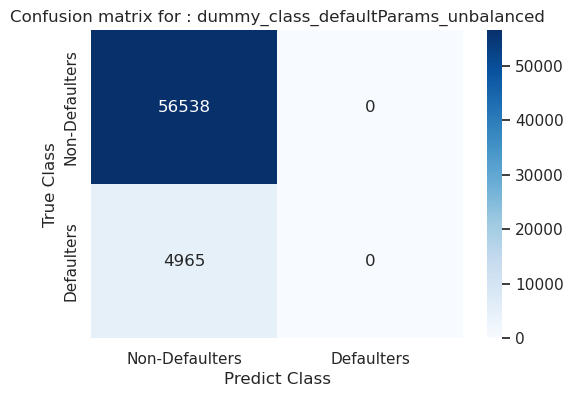

In [59]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score,f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                                'dummy_class_defaultParams_unbalanced')

In [60]:
# Default model hyperparameters and raw split
#df_results, recall, precision, accuracy, f1_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = tools_modeling.balance_method_analysis(DC,X_train, X_val, y_train, y_val, df_results,'dummy_class_defaultParams_unbalanced')

In [61]:
#os.getcwd()

In [62]:
# Load de table
#file_df_result_score = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/df_results_scores.pkl'
#with open(file_df_result_score, 'rb') as f:
#    df_results = pickle.load(f)

In [63]:
log_mlflow_balance(experiment.experiment_id,
           DC, "dummy_class_defaultParams_unbalanced",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

Setuptools is replacing distutils.


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

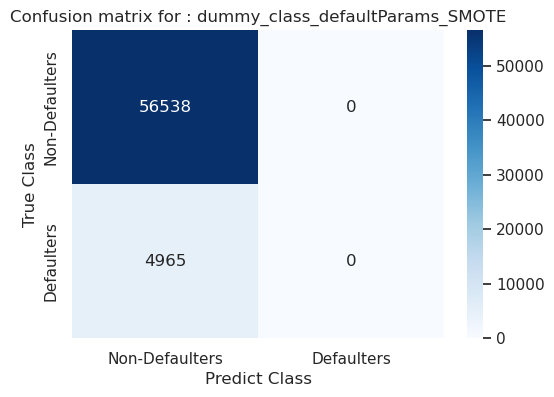

In [64]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(DC,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'dummy_class_defaultParams_SMOTE')


In [65]:
log_mlflow_balance(experiment.experiment_id,
           DC, "dummy_class_defaultParams_SMOTE",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

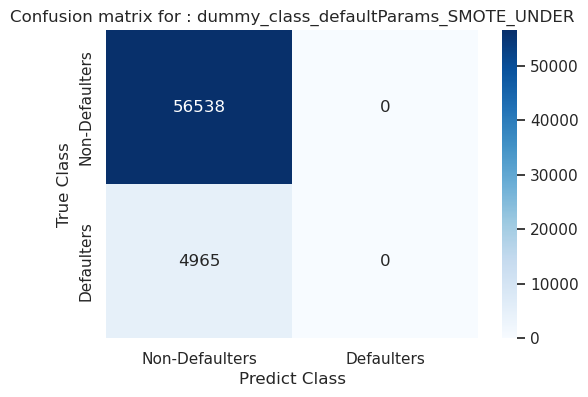

In [66]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = balance_method_analysis(DC,
                                           X_train_SMOTE_UNDER,
                                           X_val,
                                           y_train_SMOTE_UNDER,
                                           y_val,
                                           df_results,
                                     'dummy_class_defaultParams_SMOTE_UNDER')


In [67]:
log_mlflow_balance(experiment.experiment_id,
           DC, "dummy_class_defaultParams_SMOTE_UNDER",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

<a id='rebalancing_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

In [68]:
# Without data balance
LR = LogisticRegression(random_state=seed)

# Using class_weight
LR_cw = LogisticRegression(class_weight='balanced', random_state=seed)

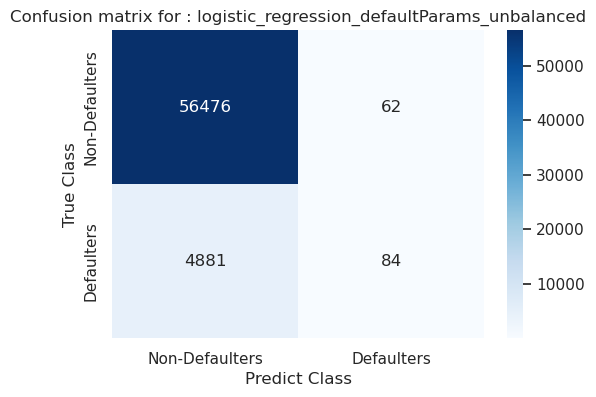

In [69]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train, X_val, y_train, y_val,
                                df_results,
                               'logistic_regression_defaultParams_unbalanced')

In [70]:
log_mlflow_balance(experiment.experiment_id,
           LR, "logistic_regression_defaultParams_unbalanced",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

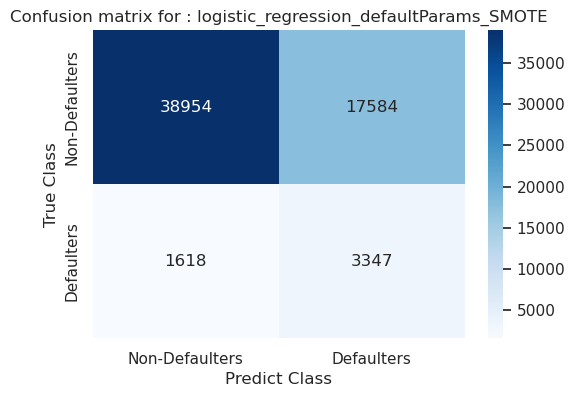

In [71]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'logistic_regression_defaultParams_SMOTE')


In [72]:
log_mlflow_balance(experiment.experiment_id,
           LR, "logistic_regression_defaultParams_SMOTE",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

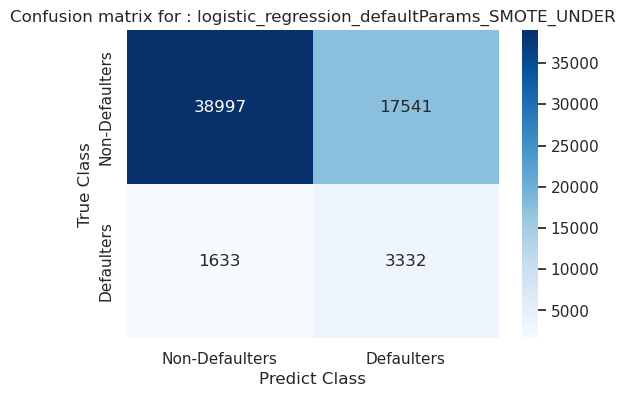

In [73]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                            'logistic_regression_defaultParams_SMOTE_UNDER')


In [74]:
log_mlflow_balance(experiment.experiment_id,
           LR, "logistic_regression_defaultParams_SMOTE_UNDER",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

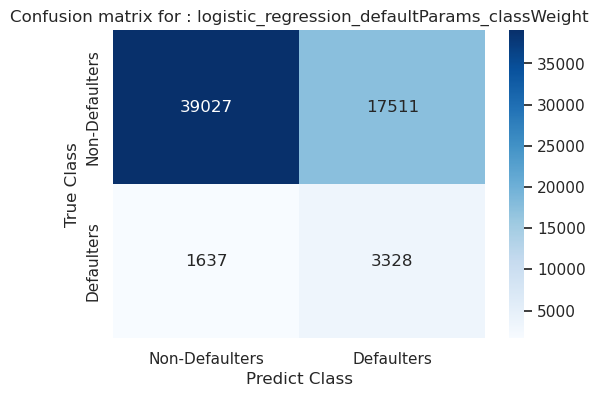

In [75]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LR_cw,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                            'logistic_regression_defaultParams_classWeight')


In [76]:
log_mlflow_balance(experiment.experiment_id,
           LR_cw, "logistic_regression_defaultParams_classWeight",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

<a id='rebalancing_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

In [77]:
# Without data balance
randomForest = RandomForestClassifier(random_state = seed)

# Using class_weight
randomForest_cw = RandomForestClassifier(class_weight = 'balanced',
                                         random_state = seed)

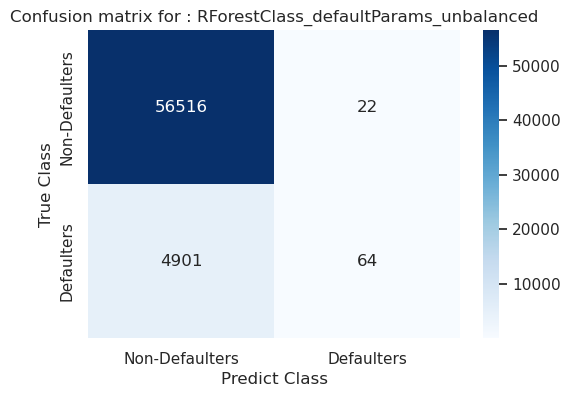

In [78]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'RForestClass_defaultParams_unbalanced')

In [79]:
log_mlflow_balance(experiment.experiment_id,
           randomForest, "RForestClass_defaultParams_unbalanced",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

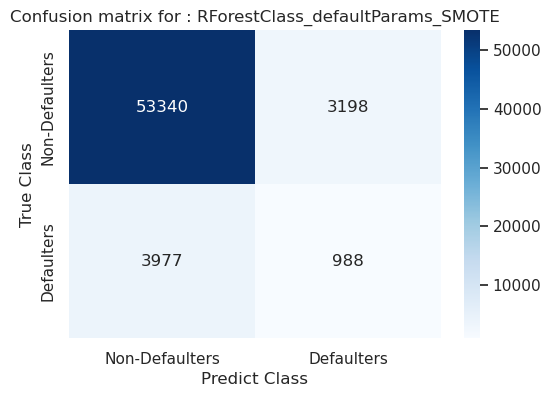

In [80]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_mmlflowic, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE')


In [81]:
log_mlflow_balance(experiment.experiment_id,
           randomForest, "RForestClass_defaultParams_SMOTE",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

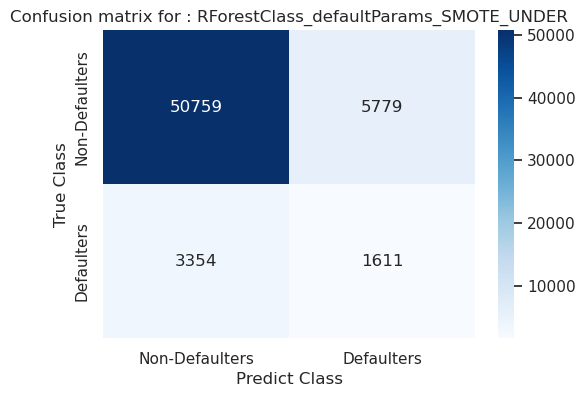

In [82]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'RForestClass_defaultParams_SMOTE_UNDER')


In [83]:
log_mlflow_balance(experiment.experiment_id,
           randomForest, "RForestClass_defaultParams_SMOTE_UNDER",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

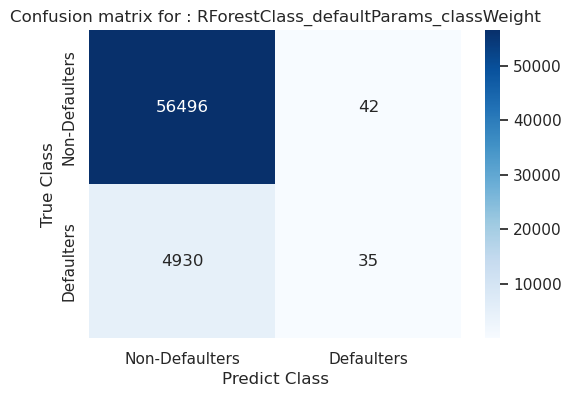

In [84]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(randomForest_cw,
                                X_train, X_val,
                                y_train, y_val,
                                df_results,
                                'RForestClass_defaultParams_classWeight')


In [85]:
log_mlflow_balance(experiment.experiment_id,
           randomForest_cw, "RForestClass_defaultParams_classWeight",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

<a id='rebalancing_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

In [86]:
# Without data balance
XGBClass = xgb.XGBClassifier(random_state = seed)

# Using class_weight
XGBClass_cw = xgb.XGBClassifier(scale_pos_weight = pos_weight,
                                class_weight=class_weights,
                                random_state = seed)

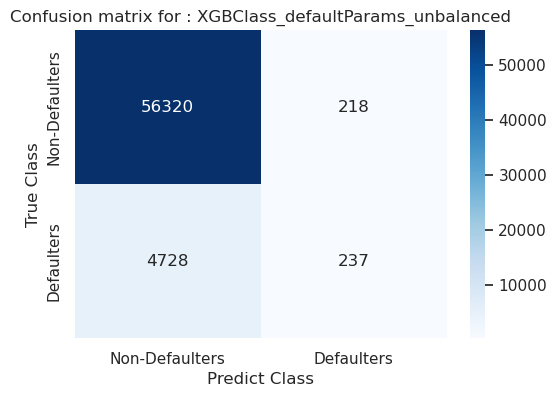

In [87]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'XGBClass_defaultParams_unbalanced')

In [88]:
log_mlflow_balance(experiment.experiment_id,
           XGBClass, "XGBClass_defaultParams_unbalanced",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

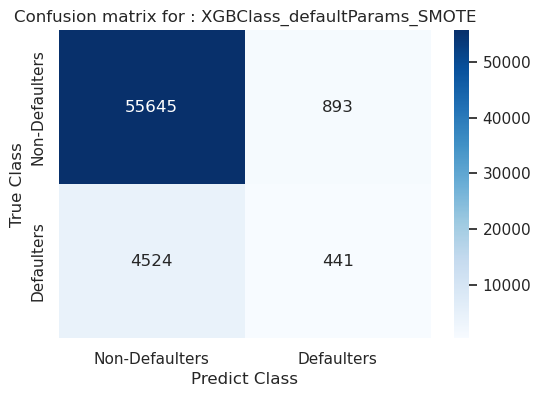

In [89]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE')


In [90]:
log_mlflow_balance(experiment.experiment_id,
           XGBClass, "XGBClass_defaultParams_SMOTE",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

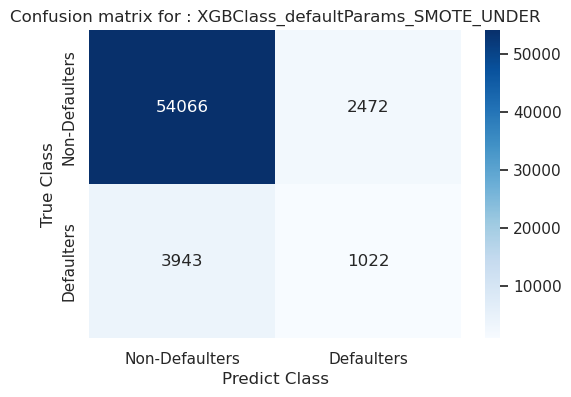

In [91]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(XGBClass,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'XGBClass_defaultParams_SMOTE_UNDER')


In [92]:
log_mlflow_balance(experiment.experiment_id,
           XGBClass, "XGBClass_defaultParams_SMOTE_UNDER",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

[19:07:51] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:02] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:13] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:23] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:34] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:45] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:08:55] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:09:06] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:09:17] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:09:27] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[19:09:37] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



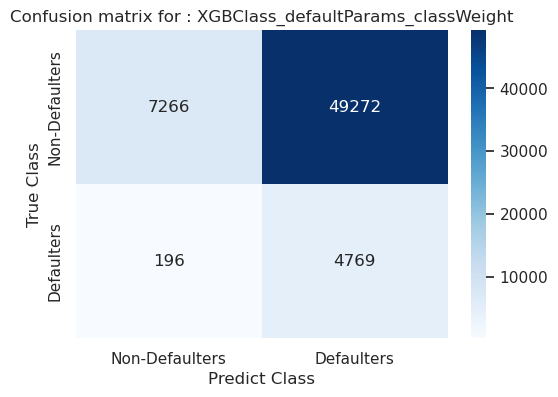

In [93]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = balance_method_analysis(XGBClass_cw,
                                           X_train,
                                           X_val,
                                           y_train,
                                           y_val,
                                           df_results,
                            'XGBClass_defaultParams_classWeight')


In [94]:
log_mlflow_balance(experiment.experiment_id,
           XGBClass_cw, "XGBClass_defaultParams_classWeight",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

<a id='rebalancing_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

In [95]:
# Without data balance
LGBM = ltb.LGBMClassifier(random_state = seed)

# Using class_weight
LGBM_cw = ltb.LGBMClassifier(class_weight = 'balanced',
                                         random_state = seed)

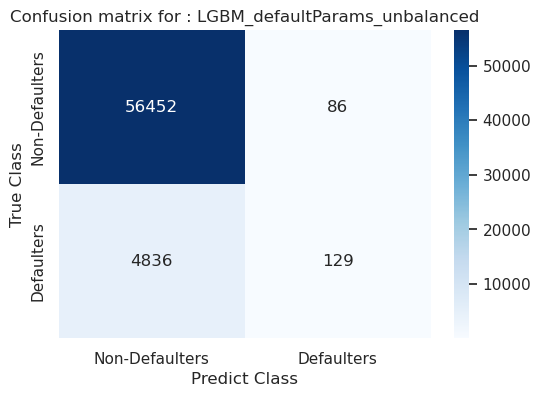

In [96]:
# Default model hyperparameters and raw split
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train, X_val, y_train, y_val,
                                df_results,
                                'LGBM_defaultParams_unbalanced')

In [97]:
log_mlflow_balance(experiment.experiment_id,
           LGBM, "LGBM_defaultParams_unbalanced",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

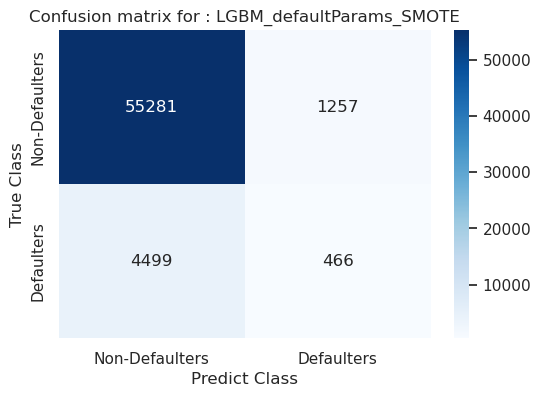

In [98]:
# Default model hyperparameters and data balanced using SMOTE
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train_SMOTE, X_val,
                                y_train_SMOTE, y_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE')


In [99]:
log_mlflow_balance(experiment.experiment_id,
           LGBM, "LGBM_defaultParams_SMOTE",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

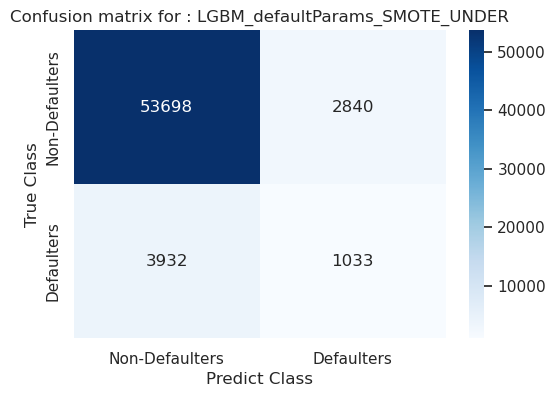

In [100]:
# Default model hyperparameters and data balanced
# using SMOTE and RandomUnderSampler
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM,
                                X_train_SMOTE_UNDER,
                                X_val,
                                y_train_SMOTE_UNDER,
                                y_val,
                                df_results,
                                'LGBM_defaultParams_SMOTE_UNDER')


In [101]:
log_mlflow_balance(experiment.experiment_id,
           LGBM, "LGBM_defaultParams_SMOTE_UNDER",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

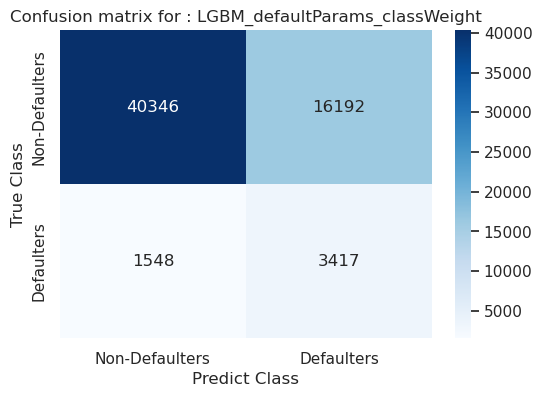

In [102]:
# Default model hyperparameters and data balanced using class_weight
df_results, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, roc_auc, ap_score, business_metric, tn, fp, fn, tp = \
        balance_method_analysis(LGBM_cw,
                                X_train,
                                X_val,
                                y_train,
                                y_val,
                                df_results,
                                'LGBM_defaultParams_classWeight')


In [103]:
log_mlflow_balance(experiment.experiment_id,
           LGBM_cw, "LGBM_defaultParams_classWeight",
           Business_Metric=business_metric,
           Recall=recall,
           Precision=precision,
           Accuracy=accuracy,
           F1_score=f1_score, F2_score=f2_score,
           F5_score=f5_score, F10_score=f10_score,
           Roc_auc=roc_auc,
           AP_score=ap_score,
           TN=tn, FP=fp, FN=fn, TP=tp,
           train_class_0=Counter(y_train)[0],
           train_class_1=Counter(y_train)[1])

In [104]:
mlflow.end_run()

<a id='rebalancing_model_tests_summary'></a>

## <span style='background:#0085dd'><span style='color:white'>Summary</span></span>

In [105]:
# True numbers of defaulers and non-defaulters
y_val_counter

Counter({0: 56538, 1: 4965})

* Number of defaulters 4965 (TP)
* Number of non-defaulters 56538 (TN)

In [106]:
# Define the folder containing the files with the project data
P7_scoring_credit = "/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/"

os.chdir(P7_scoring_credit)

In [107]:
# Load de table
file_df_result_score = 'model_tests/df_results_scores.pkl'
with open(file_df_result_score, 'rb') as f:
    df_results = pickle.load(f)

In [108]:
df_results.columns

Index(['Experience', 'Business_score', 'Recall', 'Precision', 'Accuracy', 'F1',
       'F2', 'F5', 'F10', 'ROC_AUC', 'AP_SCORE', 'Train runtime',
       'Train+Validatin runtime', 'TN', 'FP', 'FN', 'TP', 'Train_auc_CV',
       'Train_auc_CV +/-', 'Test_auc_CV', 'Test_auc_CV +/-',
       'Train_roc_auc_CV', 'Train_roc_auc_CV +/-', 'Test_roc_auc_CV',
       'Test_roc_auc_CV +/-', 'Train_recall_CV', 'Train_recall_CV +/-',
       'Test_recall_CV', 'Test_recall_CV +/-', 'Train_precision_CV',
       'Train_precision_CV +/-', 'Test_precision_CV', 'Test_precision_CV +/-'],
      dtype='object')

In [109]:
df_results.sort_values(by='Business_score', ascending=False).head(15)

Experience  Business_score    Recall  \
0             XGBClass_defaultParams_SMOTE_UNDER        0.711869  0.205841   
0         RForestClass_defaultParams_SMOTE_UNDER        0.711064  0.324471   
0                 LGBM_defaultParams_SMOTE_UNDER        0.708201  0.208056   
0                 LGBM_defaultParams_classWeight        0.705339  0.688218   
0               RForestClass_defaultParams_SMOTE        0.700980  0.198993   
0                   XGBClass_defaultParams_SMOTE        0.692589  0.088822   
0                       LGBM_defaultParams_SMOTE        0.689888  0.093857   
0              XGBClass_defaultParams_unbalanced        0.687258  0.047734   
0        logistic_regression_defaultParams_SMOTE        0.684145  0.674119   
0  logistic_regression_defaultParams_classWeight        0.683770  0.670292   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.683674  0.671098   
0                  LGBM_defaultParams_unbalanced        0.681748  0.025982   
0   logistic_regression_defaultParams_unbalanced        0.679082  0.016918   
0          RForestClass_defaultParams_unbalanced        0.678247  0.012890   
0         RForestClass_defaultParams_classWeight        0.676107  0.007049   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.292501  0.895696  0.241636  0.218806  0.208214  0.206446  0.738578  ...   
0   0.217997  0.851503  0.260785  0.295596  0.318488  0.322910  0.729446  ...   
0   0.266718  0.889892  0.233763  0.217629  0.209831  0.208510  0.737898  ...   
0   0.174257  0.711559  0.278099  0.432871  0.618100  0.668690  0.771879  ...   
0   0.236025  0.883339  0.215933  0.205440  0.200201  0.199303  0.718814  ...   
0   0.330585  0.911923  0.140022  0.104039  0.091392  0.089470  0.725549  ...   
0   0.270459  0.906411  0.139354  0.107955  0.096275  0.094468  0.718316  ...   
0   0.520879  0.919581  0.087454  0.058331  0.049462  0.048167  0.766502  ...   
0   0.159906  0.687788  0.258496  0.410262  0.599920  0.653318  0.742345  ...   
0   0.159701  0.688666  0.257945  0.408855  0.596893  0.649725  0.743949  ...   
0   0.159632  0.688243  0.257915  0.409005  0.597470  0.650463  0.742460  ...   
0   0.600000  0.919971  0.049807  0.032130  0.026974  0.026230  0.771108  ...   
0   0.575342  0.919630  0.032870  0.020994  0.017574  0.017083  0.741666  ...   
0   0.744186  0.919955  0.025342  0.016043  0.013397  0.013017  0.730518  ...   
0   0.454545  0.919158  0.013883  0.008778  0.007327  0.007119  0.738165  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.952684            0.092250        0.870066             0.022467   
0         0.962404            0.033242        0.999999             0.000003   
0         0.947197            0.095897        0.845661             0.023799   
0         0.774279            0.002702        0.744428             0.001446   
0         0.985726            0.019271        1.000000             0.000000   
0         0.970343            0.086944        0.917458             0.024654   
0         0.968709            0.084854        0.899028             0.023772   
0         0.767936            0.003403        0.100537             0.002270   
0         0.749920            0.002615        0.679123             0.000505   
0         0.742034            0.001972        0.667808             0.000994   
0         0.748590            0.004114        0.676682             0.000590   
0         0.772768            0.002828        0.037233             0.001410   
0         0.739658            0.002038        0.015123             0.000357   
0         0.729944            0.005435        0.999603             0.000101   
0         0.738892            0.004180        0.999569             0.000112   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.838003            0.311735            0.965821   
0        0.896013            0.113198            1.000000   
0        0.823332            0.305627       

In [110]:
df_results.sort_values(by='F10', ascending=False).head(15)

Experience  Business_score    Recall  \
0             XGBClass_defaultParams_classWeight        0.399491  0.960524   
0                 LGBM_defaultParams_classWeight        0.705339  0.688218   
0        logistic_regression_defaultParams_SMOTE        0.684145  0.674119   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.683674  0.671098   
0  logistic_regression_defaultParams_classWeight        0.683770  0.670292   
0         RForestClass_defaultParams_SMOTE_UNDER        0.711064  0.324471   
0                 LGBM_defaultParams_SMOTE_UNDER        0.708201  0.208056   
0             XGBClass_defaultParams_SMOTE_UNDER        0.711869  0.205841   
0               RForestClass_defaultParams_SMOTE        0.700980  0.198993   
0                       LGBM_defaultParams_SMOTE        0.689888  0.093857   
0                   XGBClass_defaultParams_SMOTE        0.692589  0.088822   
0              XGBClass_defaultParams_unbalanced        0.687258  0.047734   
0                  LGBM_defaultParams_unbalanced        0.681748  0.025982   
0   logistic_regression_defaultParams_unbalanced        0.679082  0.016918   
0          RForestClass_defaultParams_unbalanced        0.678247  0.012890   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.088248  0.195682  0.161645  0.322661  0.695946  0.874901  0.730920  ...   
0   0.174257  0.711559  0.278099  0.432871  0.618100  0.668690  0.771879  ...   
0   0.159906  0.687788  0.258496  0.410262  0.599920  0.653318  0.742345  ...   
0   0.159632  0.688243  0.257915  0.409005  0.597470  0.650463  0.742460  ...   
0   0.159701  0.688666  0.257945  0.408855  0.596893  0.649725  0.743949  ...   
0   0.217997  0.851503  0.260785  0.295596  0.318488  0.322910  0.729446  ...   
0   0.266718  0.889892  0.233763  0.217629  0.209831  0.208510  0.737898  ...   
0   0.292501  0.895696  0.241636  0.218806  0.208214  0.206446  0.738578  ...   
0   0.236025  0.883339  0.215933  0.205440  0.200201  0.199303  0.718814  ...   
0   0.270459  0.906411  0.139354  0.107955  0.096275  0.094468  0.718316  ...   
0   0.330585  0.911923  0.140022  0.104039  0.091392  0.089470  0.725549  ...   
0   0.520879  0.919581  0.087454  0.058331  0.049462  0.048167  0.766502  ...   
0   0.600000  0.919971  0.049807  0.032130  0.026974  0.026230  0.771108  ...   
0   0.575342  0.919630  0.032870  0.020994  0.017574  0.017083  0.741666  ...   
0   0.744186  0.919955  0.025342  0.016043  0.013397  0.013017  0.730518  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.719657            0.004367        1.000000             0.000000   
0         0.774279            0.002702        0.744428             0.001446   
0         0.749920            0.002615        0.679123             0.000505   
0         0.748590            0.004114        0.676682             0.000590   
0         0.742034            0.001972        0.667808             0.000994   
0         0.962404            0.033242        0.999999             0.000003   
0         0.947197            0.095897        0.845661             0.023799   
0         0.952684            0.092250        0.870066             0.022467   
0         0.985726            0.019271        1.000000             0.000000   
0         0.968709            0.084854        0.899028             0.023772   
0         0.970343            0.086944        0.917458             0.024654   
0         0.767936            0.003403        0.100537             0.002270   
0         0.772768            0.002828        0.037233             0.001410   
0         0.739658            0.002038        0.015123             0.000357   
0         0.729944            0.005435        0.999603             0.000101   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.954632            0.004203            0.093215   
0        0.689577            0.007937            0.190281   
0        0.678936            0.005288       

In [111]:
df_results.sort_values(by='ROC_AUC', ascending=False).head(15)

Experience  Business_score    Recall  \
0                 LGBM_defaultParams_classWeight        0.705339  0.688218   
0                  LGBM_defaultParams_unbalanced        0.681748  0.025982   
0              XGBClass_defaultParams_unbalanced        0.687258  0.047734   
0  logistic_regression_defaultParams_classWeight        0.683770  0.670292   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.683674  0.671098   
0        logistic_regression_defaultParams_SMOTE        0.684145  0.674119   
0   logistic_regression_defaultParams_unbalanced        0.679082  0.016918   
0             XGBClass_defaultParams_SMOTE_UNDER        0.711869  0.205841   
0         RForestClass_defaultParams_classWeight        0.676107  0.007049   
0                 LGBM_defaultParams_SMOTE_UNDER        0.708201  0.208056   
0             XGBClass_defaultParams_classWeight        0.399491  0.960524   
0          RForestClass_defaultParams_unbalanced        0.678247  0.012890   
0         RForestClass_defaultParams_SMOTE_UNDER        0.711064  0.324471   
0                   XGBClass_defaultParams_SMOTE        0.692589  0.088822   
0               RForestClass_defaultParams_SMOTE        0.700980  0.198993   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.174257  0.711559  0.278099  0.432871  0.618100  0.668690  0.771879  ...   
0   0.600000  0.919971  0.049807  0.032130  0.026974  0.026230  0.771108  ...   
0   0.520879  0.919581  0.087454  0.058331  0.049462  0.048167  0.766502  ...   
0   0.159701  0.688666  0.257945  0.408855  0.596893  0.649725  0.743949  ...   
0   0.159632  0.688243  0.257915  0.409005  0.597470  0.650463  0.742460  ...   
0   0.159906  0.687788  0.258496  0.410262  0.599920  0.653318  0.742345  ...   
0   0.575342  0.919630  0.032870  0.020994  0.017574  0.017083  0.741666  ...   
0   0.292501  0.895696  0.241636  0.218806  0.208214  0.206446  0.738578  ...   
0   0.454545  0.919158  0.013883  0.008778  0.007327  0.007119  0.738165  ...   
0   0.266718  0.889892  0.233763  0.217629  0.209831  0.208510  0.737898  ...   
0   0.088248  0.195682  0.161645  0.322661  0.695946  0.874901  0.730920  ...   
0   0.744186  0.919955  0.025342  0.016043  0.013397  0.013017  0.730518  ...   
0   0.217997  0.851503  0.260785  0.295596  0.318488  0.322910  0.729446  ...   
0   0.330585  0.911923  0.140022  0.104039  0.091392  0.089470  0.725549  ...   
0   0.236025  0.883339  0.215933  0.205440  0.200201  0.199303  0.718814  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.774279            0.002702        0.744428             0.001446   
0         0.772768            0.002828        0.037233             0.001410   
0         0.767936            0.003403        0.100537             0.002270   
0         0.742034            0.001972        0.667808             0.000994   
0         0.748590            0.004114        0.676682             0.000590   
0         0.749920            0.002615        0.679123             0.000505   
0         0.739658            0.002038        0.015123             0.000357   
0         0.952684            0.092250        0.870066             0.022467   
0         0.738892            0.004180        0.999569             0.000112   
0         0.947197            0.095897        0.845661             0.023799   
0         0.719657            0.004367        1.000000             0.000000   
0         0.729944            0.005435        0.999603             0.000101   
0         0.962404            0.033242        0.999999             0.000003   
0         0.970343            0.086944        0.917458             0.024654   
0         0.985726            0.019271        1.000000             0.000000   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.689577            0.007937            0.190281   
0        0.025126            0.002835            0.780544   
0        0.044914            0.003925       

In [112]:
# We are looking for the lowest rate of FN
df_results.sort_values(by='FN', ascending=True).head(10)

Experience  Business_score    Recall  \
0             XGBClass_defaultParams_classWeight        0.399491  0.960524   
0                 LGBM_defaultParams_classWeight        0.705339  0.688218   
0        logistic_regression_defaultParams_SMOTE        0.684145  0.674119   
0  logistic_regression_defaultParams_SMOTE_UNDER        0.683674  0.671098   
0  logistic_regression_defaultParams_classWeight        0.683770  0.670292   
0         RForestClass_defaultParams_SMOTE_UNDER        0.711064  0.324471   
0                 LGBM_defaultParams_SMOTE_UNDER        0.708201  0.208056   
0             XGBClass_defaultParams_SMOTE_UNDER        0.711869  0.205841   
0               RForestClass_defaultParams_SMOTE        0.700980  0.198993   
0                       LGBM_defaultParams_SMOTE        0.689888  0.093857   

   Precision  Accuracy        F1        F2        F5       F10   ROC_AUC  ...  \
0   0.088248  0.195682  0.161645  0.322661  0.695946  0.874901  0.730920  ...   
0   0.174257  0.711559  0.278099  0.432871  0.618100  0.668690  0.771879  ...   
0   0.159906  0.687788  0.258496  0.410262  0.599920  0.653318  0.742345  ...   
0   0.159632  0.688243  0.257915  0.409005  0.597470  0.650463  0.742460  ...   
0   0.159701  0.688666  0.257945  0.408855  0.596893  0.649725  0.743949  ...   
0   0.217997  0.851503  0.260785  0.295596  0.318488  0.322910  0.729446  ...   
0   0.266718  0.889892  0.233763  0.217629  0.209831  0.208510  0.737898  ...   
0   0.292501  0.895696  0.241636  0.218806  0.208214  0.206446  0.738578  ...   
0   0.236025  0.883339  0.215933  0.205440  0.200201  0.199303  0.718814  ...   
0   0.270459  0.906411  0.139354  0.107955  0.096275  0.094468  0.718316  ...   

   Test_roc_auc_CV Test_roc_auc_CV +/- Train_recall_CV  Train_recall_CV +/-  \
0         0.719657            0.004367        1.000000             0.000000   
0         0.774279            0.002702        0.744428             0.001446   
0         0.749920            0.002615        0.679123             0.000505   
0         0.748590            0.004114        0.676682             0.000590   
0         0.742034            0.001972        0.667808             0.000994   
0         0.962404            0.033242        0.999999             0.000003   
0         0.947197            0.095897        0.845661             0.023799   
0         0.952684            0.092250        0.870066             0.022467   
0         0.985726            0.019271        1.000000             0.000000   
0         0.968709            0.084854        0.899028             0.023772   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
0        0.954632            0.004203            0.093215   
0        0.689577            0.007937            0.190281   
0        0.678936            0.005288            0.686697   
0        0.676575            0.005140            0.686166   
0        0.667422            0.005339            0.159509   
0        0.896013            0.113198            1.000000   
0        0.823332            0.305627            0.946224   
0        0.838003            0.311735            0.965821   
0        0.944019            0.082219            1.000000   
0        0.891567            0.249228            0.975660   

   Train_precision_CV +/-  Test_precision_CV  Test_precision_CV +/-  
0                0.000414           0.088819               0.000337  
0                0.000438           0.176206               0.001068  
0                0.000266           0.686563               0.002221  
0                0.000279           0.686078               0.002387  
0                0.000152           0.159428               0.001311  
0                0.000000           0.892466               0.008528  
0                0.013348           0.929319               0.039064  
0                0.009834           0.939980               0.028601  
0                0.000000           0.938238               0.004825  
0                0.005271           0.972095 

**Metrics summary**

In [113]:
df_results = df_results.sort_values(by='F10', ascending=False)
experiences_list = list(df_results['Experience'])

In [114]:
experiences_list[0:5]

['XGBClass_defaultParams_classWeight',
 'LGBM_defaultParams_classWeight',
 'logistic_regression_defaultParams_SMOTE',
 'logistic_regression_defaultParams_SMOTE_UNDER',
 'logistic_regression_defaultParams_classWeight']

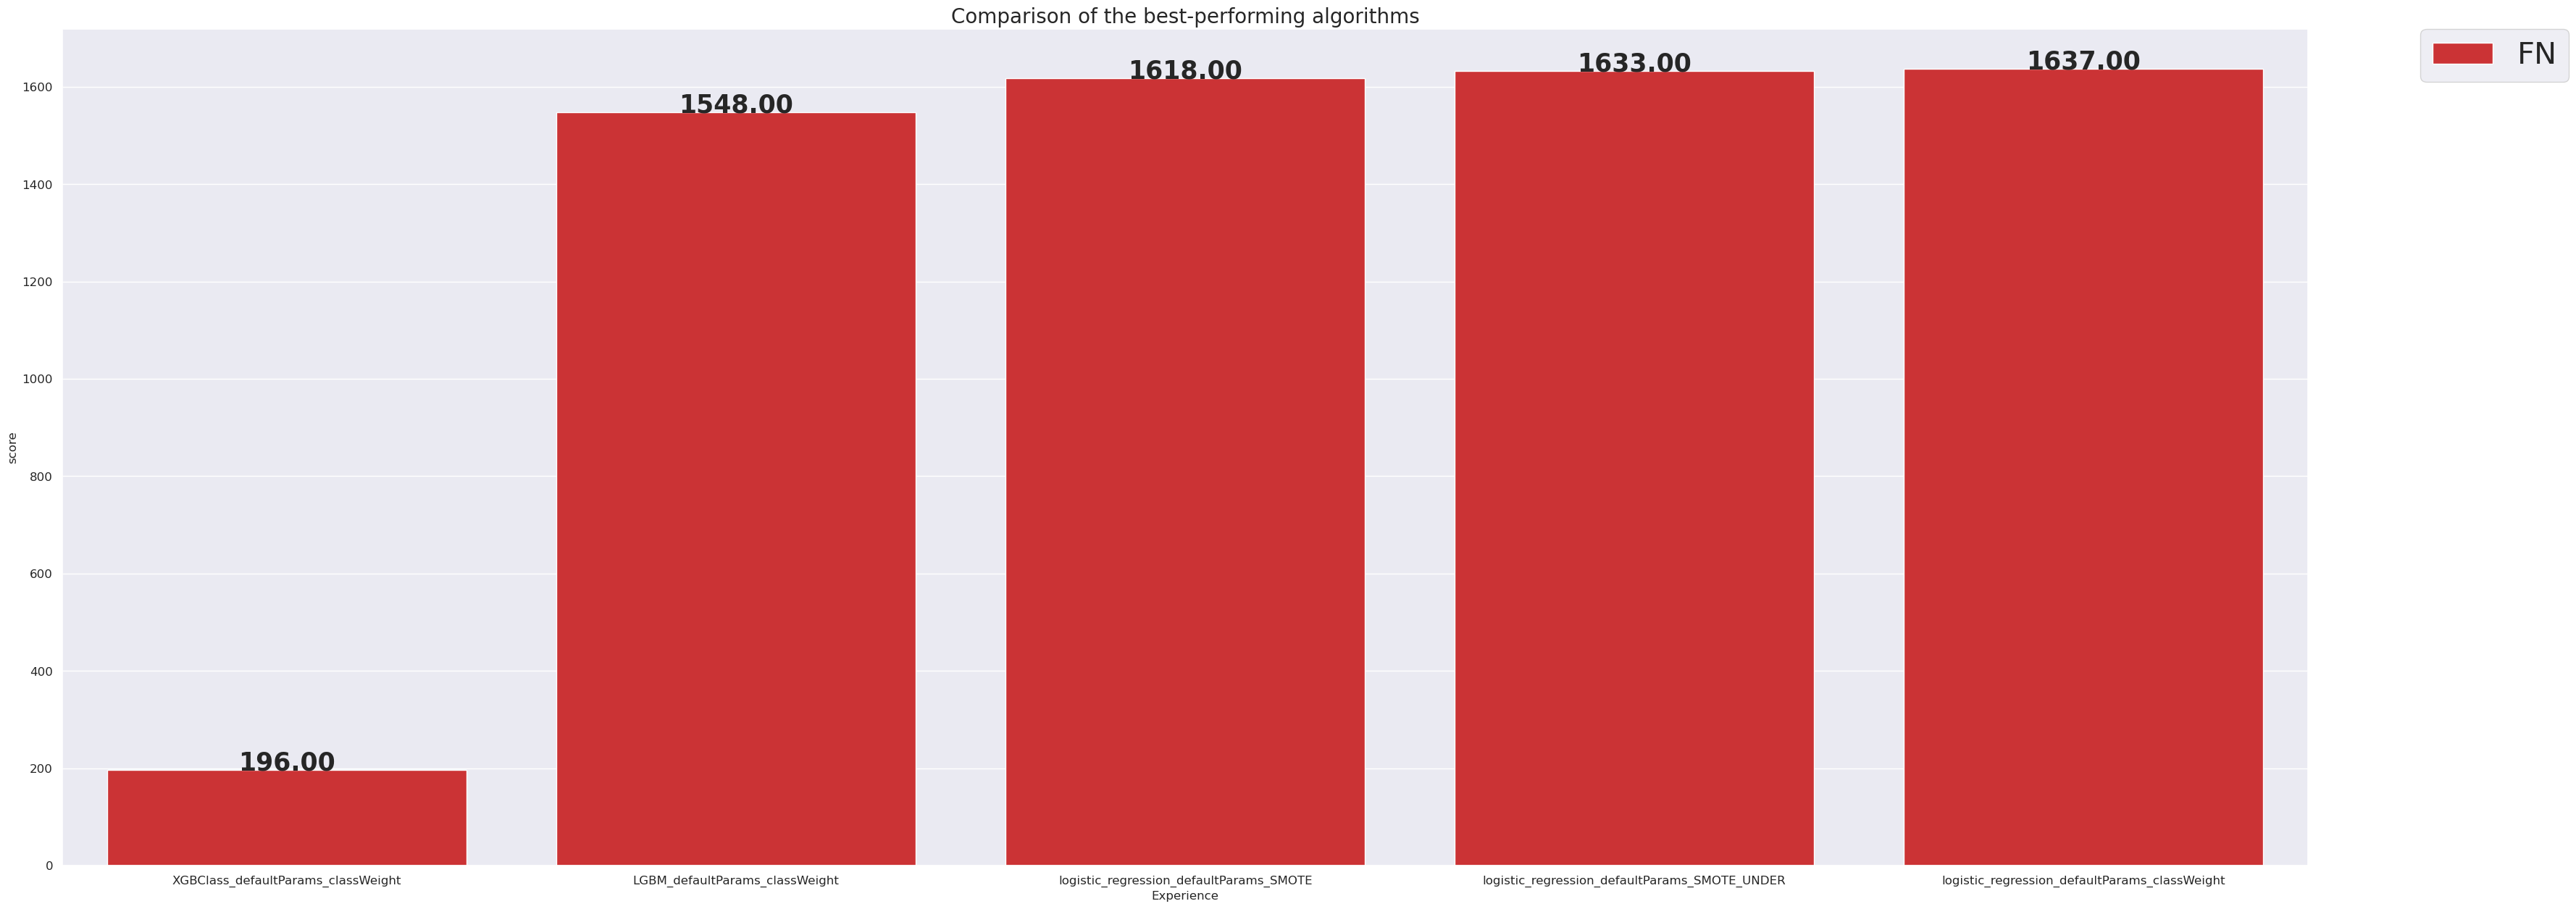

In [115]:
# Visual comparison of the 5 best-performing algorithms
df_comp_results = df_results[df_results['Experience'].isin(experiences_list[0:5])]



# Scores
comparaison_score_melt = \
    pd.melt(df_comp_results, id_vars=['Experience'], value_name='score',
            value_vars=['FN'])
# Visualization
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Experience'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_results[['Experience', 'Train runtime', 'FN', 'Recall', 'Precision',
                 'F1', 'F5', 'F10',
                 'ROC_AUC', 'AP_SCORE',
                 'Business_score']].style.hide(axis="index")

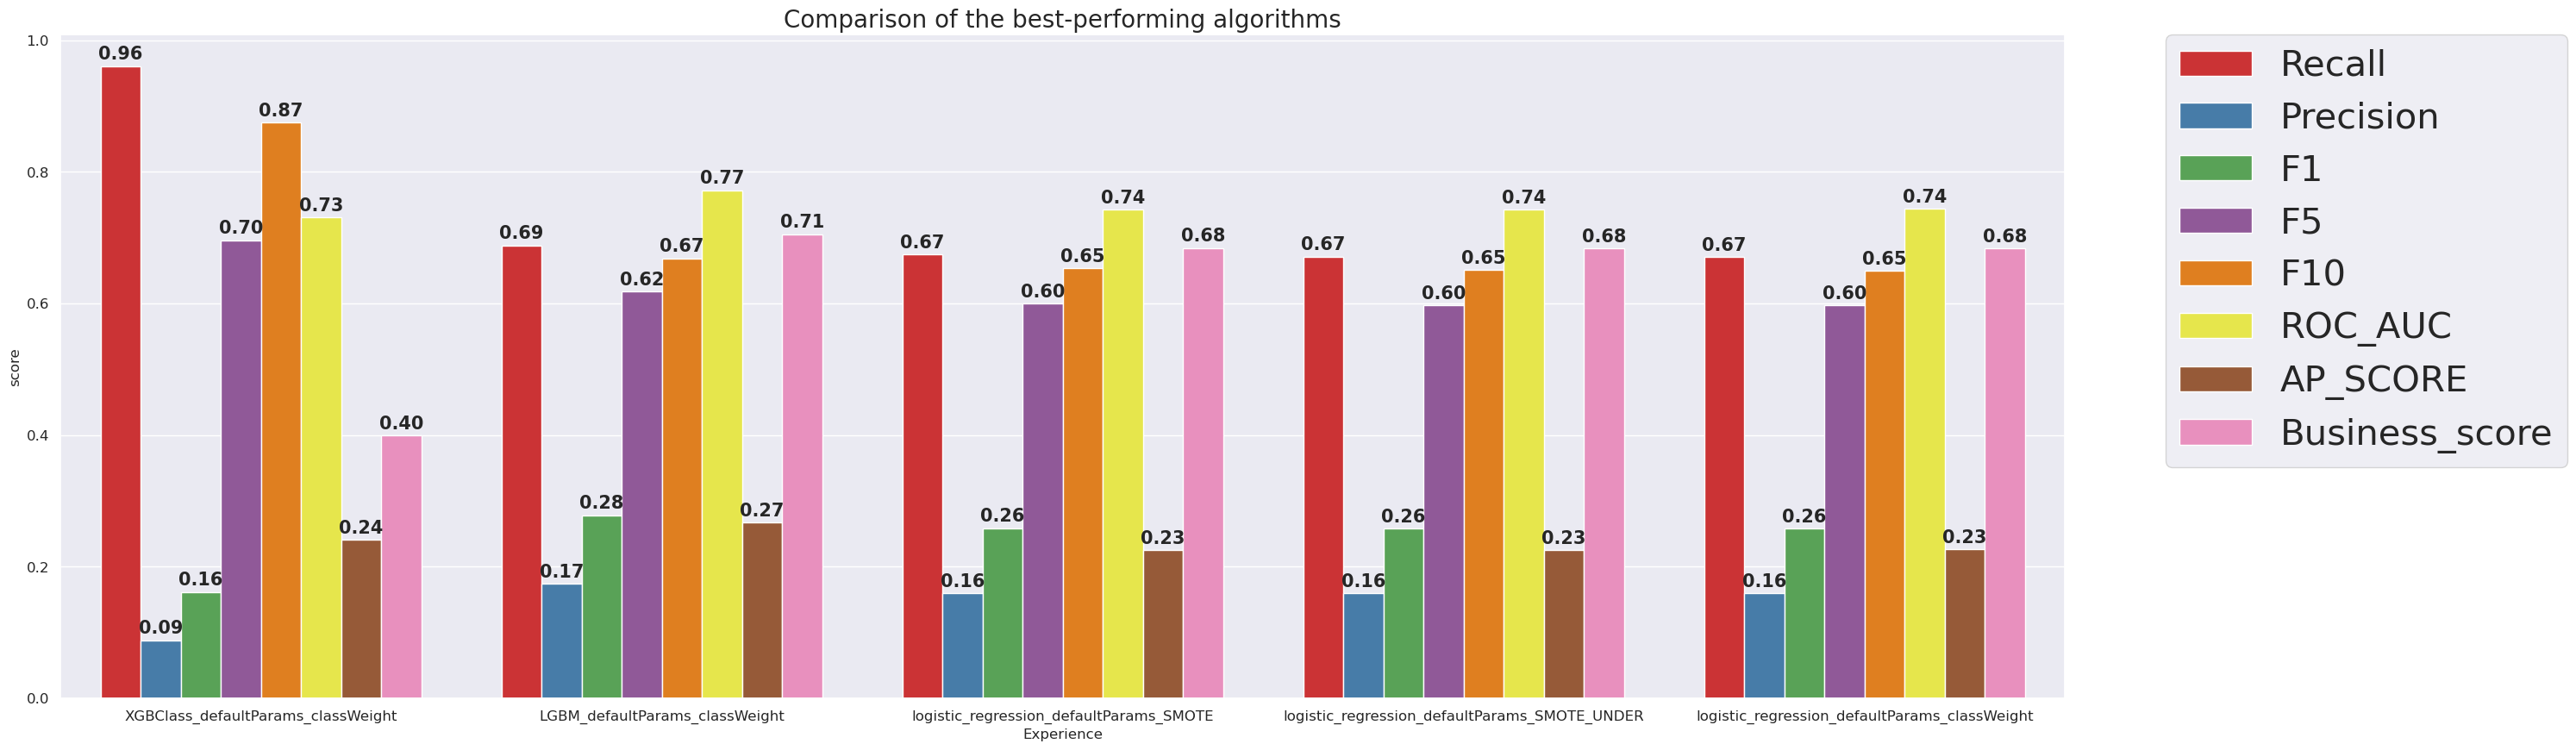

In [116]:
# Visual comparison of the 5 best-performing algorithms
df_comp_results = df_results[df_results['Experience'].isin(experiences_list[0:5])]



# Scores
comparaison_score_melt = \
    pd.melt(df_comp_results, id_vars=['Experience'], value_name='score',
            value_vars=['Recall', 'Precision', 'F1', 'F5', 'F10',
                        'ROC_AUC', 'AP_SCORE', 'Business_score'])
# Visualization
plt.figure(figsize=(30, 10))
ax= sns.barplot(x=comparaison_score_melt['Experience'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=15,
            fontweight='bold') 
plt.show()

df_comp_results[['Experience', 'Train runtime', 'Recall', 'Precision',
                 'F1', 'F5', 'F10',
                 'ROC_AUC', 'AP_SCORE',
                 'Business_score']].style.hide(axis="index")

<a id='model_selection'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Model selection** </span></span>


<a id='hyperparameter_optimization'></a>

## <span style='background:#0085dd'><span style='color:white'>Hyperparameter optimization</span></span>

In [117]:
server_uri = 'http://127.0.0.1:5000'

In [118]:
# Create MLFlow experiment

experiment_name = 'hyperparam_tunnig'
try:
    experiment_id = mlflow.create_experiment(
        name = experiment_name,
        artifact_location=Path.cwd().joinpath("mlruns").as_uri(),
        tags={"version": "v2", "others": "dataset with 23 features"},
)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

tags={"version": "v2", "others": "dataset with 23 features"}
mlflow_hyp_opt = mlflow.get_experiment(exp_id)
print("Name: {}".format(mlflow_hyp_opt.name))
print("Experiment_id: {}".format(mlflow_hyp_opt.experiment_id))
print("Artifact Location: {}".format(mlflow_hyp_opt.artifact_location))
print("Tags: {}".format(mlflow_hyp_opt.tags))
print("Lifecycle_stage: {}".format(mlflow_hyp_opt.lifecycle_stage))
print("Creation timestamp: {}".format(mlflow_hyp_opt.creation_time))

Name: hyperparam_tunnig
Experiment_id: 373164462905213212
Artifact Location: file:///home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/mlruns/373164462905213212
Tags: {'others': 'dataset with 23 features', 'version': 'v2'}
Lifecycle_stage: active
Creation timestamp: 1689932718085


Para optimizar y evaluar los modelos
* Primero hay busqueda de los hiperparametros optimos via validacion cruzada. (search_best_model)<br>
* Para comprender mejor la relacion entre los hiperparametros de los alogrithmos y los scorers para evaluar los modelos se hace una representacion grafica (plot_best_param_scores)<br>
* Para facilitar la comparacion entre los mejores resultados de los modelos, se crea una tabla para almacenar los datos (add_model_score)<br>
* Se fit el algorithmo usando los best_params sobre los datos de train y se hace la prediccion usando predict_proba (train_best_params)<br>
* A traves de una nueva funcion se identifica el umbral de probabilidad que optimiza los scorers (prob_threshold)<br>
* Se generan varias graficas de sintesis para facilitar la evaluacion de la performance del modelo


In [119]:
df_temp.columns

Index(['Experience', 'recall', 'precision', 'accuracy', 'f1_score', 'f2_score',
       'f5_score', 'f10_score', 'business_metric', 'tn', 'fp', 'fn', 'tp',
       'roc_auc', 'ap_score'],
      dtype='object')

In [120]:
# Create a table for recording models scores

# Columns definition
metrics_columns = list(df_temp.columns)
metrics_columns.remove('Experience')
cols = ['Experience', 'params', 'train_time',
        'gridsearch_time'] + metrics_columns

df_scores_models = pd.DataFrame(columns=cols)

In [121]:
df_scores_models

Empty DataFrame
Columns: [Experience, params, train_time, gridsearch_time, recall, precision, accuracy, f1_score, f2_score, f5_score, f10_score, business_metric, tn, fp, fn, tp, roc_auc, ap_score]
Index: []

<a id='optimization_dummy'></a>

### <span style='background:#0075bc'><span style='color:white'>Baseline : Dummy Classifier</span></span>

In [122]:
DC = DummyClassifier(strategy='most_frequent', random_state=seed)

Experience = 'Baseline (Dummy)'
param_grid = {}
dummy_pipeline = imbpipeline.Pipeline(steps=[('clf', DC)])

dummy_pipeline

Pipeline(steps=[('clf',
                 DummyClassifier(random_state=84, strategy='most_frequent'))])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
GridSearchCV took 0.607 s
Best Parameters: {}
Best Train Score (roc_auc) : 0.500
Best Test Score (roc_auc): 0.500
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (Baseline (Dummy); training time = 0.01580057144165039 s; estimated gridsearch time (5 splits) = 0.182 s
add_model_score, model = Baseline (Dummy)
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.919, 'f1_score': 0.0, 'f2_score': 0.0, 'f5_score': 0.0, 'f10_score': 0.0, 'business_metric': 0.674, 'tn': 56538, 'fp': 0, 'fn': 4965, 'tp': 0, 'roc_auc': 0.5, 'ap_score': 0.081}
Plotting results for Baseline (Dummy) with best_params : {}


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

1-specificity(FPR) = 0.00, sensitivity(TPR) 0.00


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in scalar divide
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Precision is ill-defined and being set to 0.0 due to no pr

best threshold for roc_auc : 0.100 (score = 0.500)
best threshold for f2_score : 0.100 (score = 0.000)
best threshold for business_metric : 0.100 (score = 0.674)
Best Threshold=1.000, Youden J =0.000
Best Threshold=0.000, F-Score=0.149


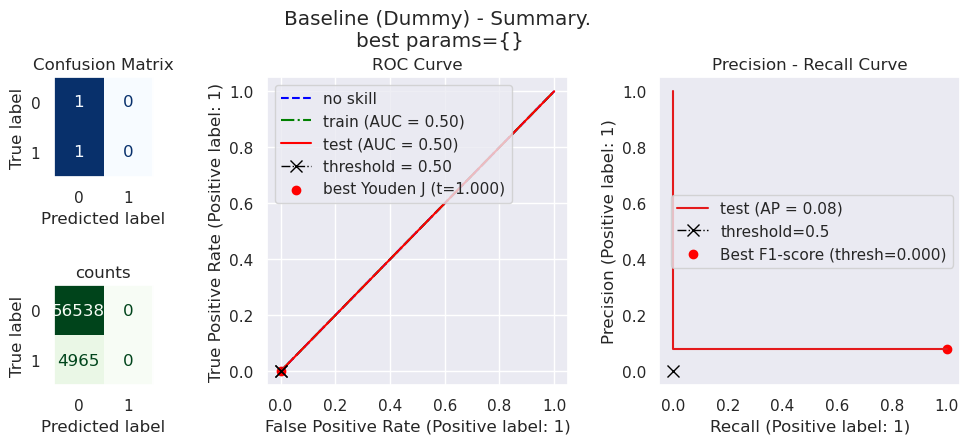

In [123]:
evaluate_model(Experience, dummy_pipeline,
               X_train, y_train,
               X_val, y_val)

In [124]:
dummy_opt = df_scores_models.loc[df_scores_models["Experience"] == "Baseline (Dummy)"]
dummy_opt

Experience params  train_time  gridsearch_time  recall  precision  \
0  Baseline (Dummy)     {}       0.005            0.182     0.0        0.0   

   accuracy  f1_score  f2_score  f5_score  ...  std_train_roc_auc  \
0     0.919       0.0       0.0       0.0  ...                0.0   

   mean_test_business_metric std_test_business_metric  \
0                   0.674308                 0.000002   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
0                   0.674308              5.946865e-07                0.0   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
0                0.0                  0.0                0.0   

   discrimination_threshold  
0                       0.5  

[1 rows x 38 columns]

<a id='optimization_LogisticRegression'></a>

### <span style='background:#0075bc'><span style='color:white'>Logistic regression</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [125]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'LogisticRegression_smoteUnder'
LR_pipeline = imbpipeline.Pipeline(steps=[
    ('clf', LogisticRegression(random_state=seed)),
])
param_grid = {
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver':['liblinear']
}

LR_pipeline

Pipeline(steps=[('clf', LogisticRegression(random_state=84))])

Fitting 5 folds for each of 3 candidates, totalling 15 fits



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/skl

GridSearchCV took 12.392 s
Best Parameters: {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best Train Score (roc_auc) : 0.749
Best Test Score (roc_auc): 0.749
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LogisticRegression_smoteUnder; training time = 0.5403396129608155 s; estimated gridsearch time (15 splits) = 8.814 s
add_model_score, model = LogisticRegression_smoteUnder


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.671, 'precision': 0.16, 'accuracy': 0.688, 'f1_score': 0.258, 'f2_score': 0.409, 'f5_score': 0.597, 'f10_score': 0.65, 'business_metric': 0.684, 'tn': 38994, 'fp': 17544, 'fn': 1635, 'tp': 3330, 'roc_auc': 0.742, 'ap_score': 0.225}
Plotting results for LogisticRegression_smoteUnder with best_params : {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

1-specificity(FPR) = 0.31, sensitivity(TPR) 0.67


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.500 (score = 0.680)
best threshold for f2_score : 0.500 (score = 0.409)
best threshold for business_metric : 0.650 (score = 0.724)
Best Threshold=0.485, Youden J =0.365
Best Threshold=0.646, F-Score=0.292


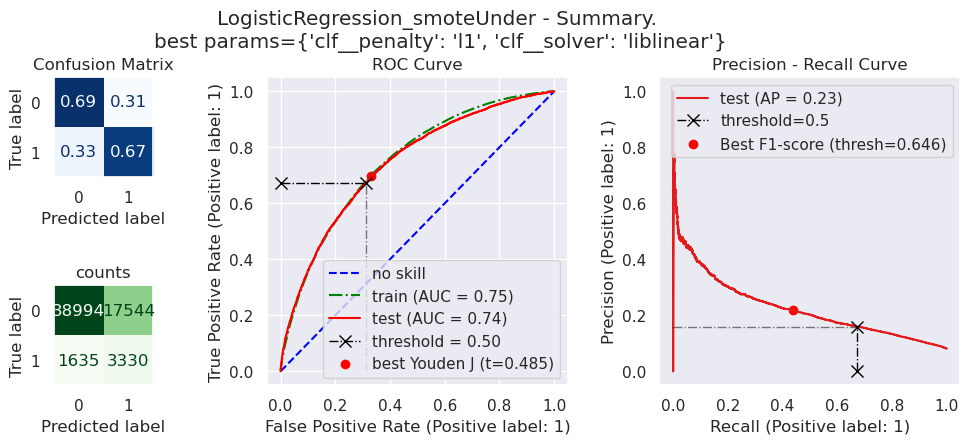

In [126]:
evaluate_model(Experience, LR_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [127]:
LR_opt_SU = df_scores_models.loc[df_scores_models["Experience"] == "LogisticRegression_smoteUnder"]
LR_opt_SU

Experience  \
1  LogisticRegression_smoteUnder   

                                              params  train_time  \
1  {'clf__penalty': 'l1', 'clf__solver': 'libline...        1.11   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
1            8.814   0.671       0.16     0.688     0.258     0.409     0.597   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
1  ...           0.000995                    0.67856                 0.003493   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
1                   0.678892                  0.001142           0.678308   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
1           0.003568             0.678644           0.001167   

   discrimination_threshold  
1                       0.5  

[1 rows x 38 columns]

**Data balancing using class_weights**

In [128]:
# X_train, y_train
# X_val, y_val

Experience = 'LogisticRegression_opti_classWeight'
LR_pipeline_cw = imbpipeline.Pipeline(steps=[
    ('clf', LogisticRegression(class_weight='balanced',
                               random_state=seed)),
    ])
param_grid = {
    'clf__penalty':['l1','l2', 'elasticnet'],
    'clf__solver':['liblinear']}

LR_pipeline_cw

Pipeline(steps=[('clf',
                 LogisticRegression(class_weight='balanced', random_state=84))])

Fitting 5 folds for each of 3 candidates, totalling 15 fits



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/raquelsp/anaconda3/lib/python3.9/site-packages/skl

GridSearchCV took 109.466 s
Best Parameters: {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best Train Score (roc_auc) : 0.743
Best Test Score (roc_auc): 0.742
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LogisticRegression_opti_classWeight; training time = 6.855849536259968 s; estimated gridsearch time (15 splits) = 103.596 s
add_model_score, model = LogisticRegression_opti_classWeight


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.67, 'precision': 0.16, 'accuracy': 0.689, 'f1_score': 0.258, 'f2_score': 0.409, 'f5_score': 0.597, 'f10_score': 0.65, 'business_metric': 0.684, 'tn': 39022, 'fp': 17516, 'fn': 1636, 'tp': 3329, 'roc_auc': 0.744, 'ap_score': 0.226}
Plotting results for LogisticRegression_opti_classWeight with best_params : {'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

1-specificity(FPR) = 0.31, sensitivity(TPR) 0.67


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.500 (score = 0.680)
best threshold for f2_score : 0.500 (score = 0.409)
best threshold for business_metric : 0.650 (score = 0.723)
Best Threshold=0.478, Youden J =0.366
Best Threshold=0.620, F-Score=0.291


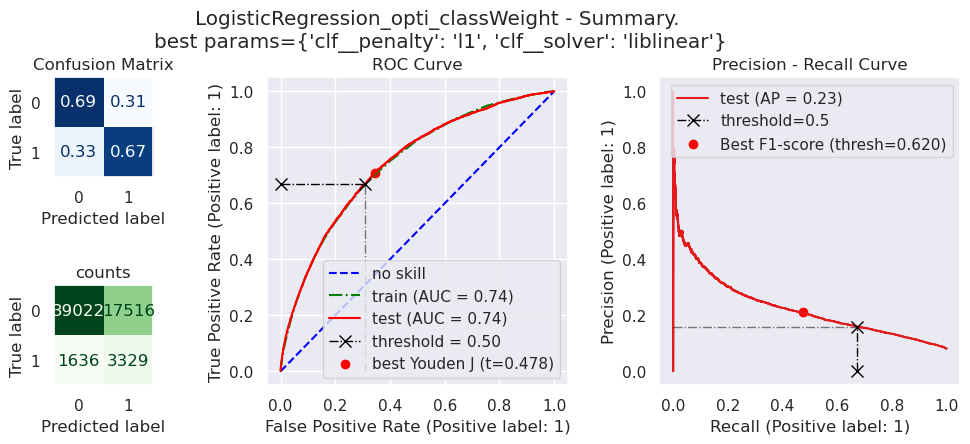

In [129]:
evaluate_model(Experience, LR_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [130]:
LR_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "LogisticRegression_opti_classWeight"]
LR_opt_cw

Experience  \
2  LogisticRegression_opti_classWeight   

                                              params  train_time  \
2  {'clf__penalty': 'l1', 'clf__solver': 'libline...       3.098   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
2          103.596    0.67       0.16     0.689     0.258     0.409     0.597   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
2  ...           0.000418                   0.683201                  0.00072   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
2                    0.68343                  0.000283            0.40747   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
2           0.001396             0.407916           0.000345   

   discrimination_threshold  
2                       0.5  

[1 rows x 38 columns]

<a id='optimization_RandomForest'></a>

### <span style='background:#0075bc'><span style='color:white'>Random Forest</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [131]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'RForestClass_opti_smoteUnder'

rfc_pipeline = imbpipeline.Pipeline(steps=[
    ('clf', RandomForestClassifier(random_state = seed,
                                   max_features='auto'))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__criterion': ['gini', 'entropy']}

rfc_pipeline

Pipeline(steps=[('clf', RandomForestClassifier(random_state=84))])

Fitting 5 folds for each of 14 candidates, totalling 70 fits
GridSearchCV took 2057.041 s
Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 9}
Best Train Score (roc_auc) : 0.846
Best Test Score (roc_auc): 0.824
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (RForestClass_opti_smoteUnder; training time = 26.352453654153006 s; estimated gridsearch time (70 splits) = 1878.587 s
add_model_score, model = RForestClass_opti_smoteUnder


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.603, 'precision': 0.161, 'accuracy': 0.714, 'f1_score': 0.254, 'f2_score': 0.389, 'f5_score': 0.545, 'f10_score': 0.587, 'business_metric': 0.684, 'tn': 40915, 'fp': 15623, 'fn': 1971, 'tp': 2994, 'roc_auc': 0.726, 'ap_score': 0.194}
Plotting results for RForestClass_opti_smoteUnder with best_params : {'clf__criterion': 'gini', 'clf__max_depth': 9}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.95      0.72      0.82     56538
           1       0.16      0.60      0.25      4965

    accuracy                           0.71     61503
   macro avg       0.56      0.66      0.54     61503
weighted avg       0.89      0.71      0.78     61503

1-specificity(FPR) = 0.28, sensitivity(TPR) 0.60


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.450 (score = 0.669)
best threshold for f2_score : 0.450 (score = 0.397)
best threshold for business_metric : 0.600 (score = 0.710)
Best Threshold=0.457, Youden J =0.341
Best Threshold=0.591, F-Score=0.267


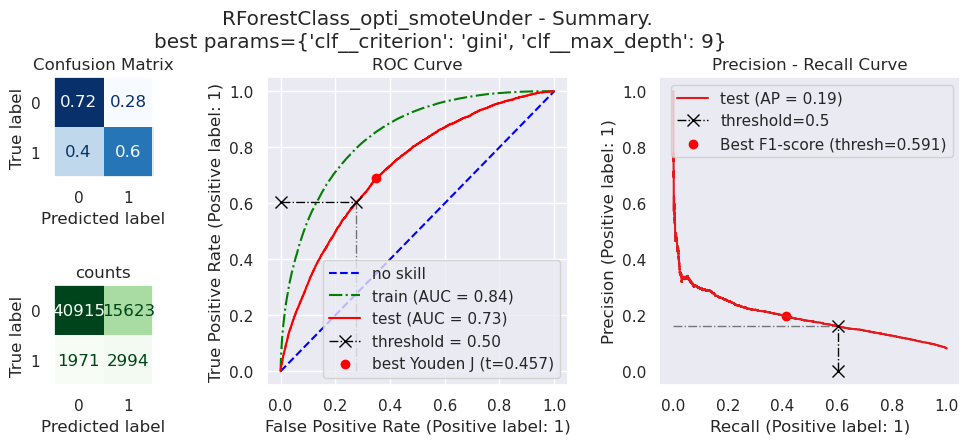

In [132]:
evaluate_model(Experience, rfc_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [133]:
RF_opt_su = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "RForestClass_opti_smoteUnder"]
RF_opt_su

Experience  \
3  RForestClass_opti_smoteUnder   

                                            params  train_time  \
3  {'clf__criterion': 'gini', 'clf__max_depth': 9}      43.868   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
3         1878.587   0.603      0.161     0.714     0.254     0.389     0.545   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
3  ...           0.015855                   0.752267                 0.079349   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
3                   0.780637                  0.017692           0.750581   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
3           0.081988             0.780505           0.017475   

   discrimination_threshold  
3                       0.5  

[1 rows x 38 columns]

**Data balancing using class_weights**

In [134]:
# X_train, y_train
# X_val, y_val

Experience = 'RandomForest_opti_classWeight'
rfc_pipeline_cw = imbpipeline.Pipeline(steps=[
    ('clf', RandomForestClassifier(class_weight = 'balanced',
                                   random_state = seed,
                                   max_features='auto'))])

param_grid = {'clf__max_depth': [5, 10, 50],
              'clf__criterion': ['gini', 'entropy']}

rfc_pipeline_cw

Pipeline(steps=[('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=84))])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV took 1379.604 s
Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 10}
Best Train Score (roc_auc) : 0.817
Best Test Score (roc_auc): 0.752
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (RandomForest_opti_classWeight; training time = 38.97981913089752 s; estimated gridsearch time (30 splits) = 1202.57 s
add_model_score, model = RandomForest_opti_classWeight


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.633, 'precision': 0.175, 'accuracy': 0.73, 'f1_score': 0.274, 'f2_score': 0.415, 'f5_score': 0.575, 'f10_score': 0.617, 'business_metric': 0.704, 'tn': 41733, 'fp': 14805, 'fn': 1824, 'tp': 3141, 'roc_auc': 0.752, 'ap_score': 0.232}
Plotting results for RandomForest_opti_classWeight with best_params : {'clf__criterion': 'entropy', 'clf__max_depth': 10}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56538
           1       0.18      0.63      0.27      4965

    accuracy                           0.73     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.89      0.73      0.79     61503

1-specificity(FPR) = 0.26, sensitivity(TPR) 0.63


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.450 (score = 0.688)
best threshold for f2_score : 0.450 (score = 0.417)
best threshold for business_metric : 0.650 (score = 0.726)
Best Threshold=0.462, Youden J =0.379
Best Threshold=0.605, F-Score=0.295


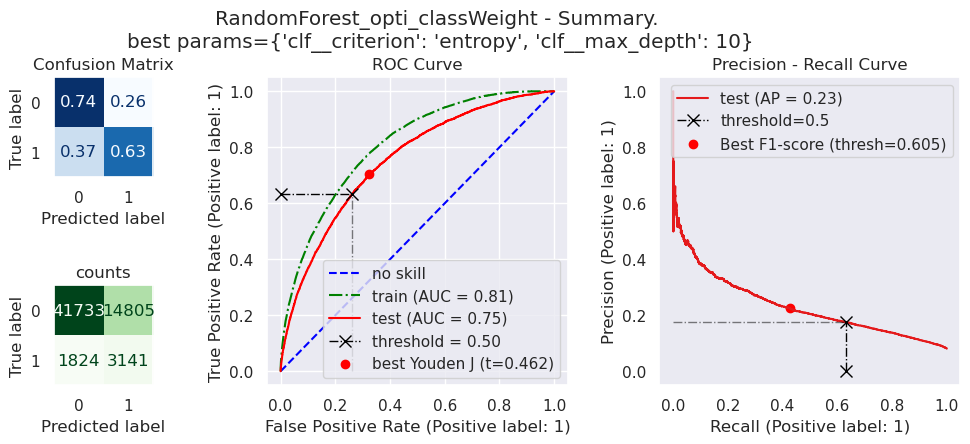

In [135]:
evaluate_model(Experience, rfc_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [136]:
RF_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                 "RandomForest_opti_classWeight"]
RF_opt_cw

Experience  \
4  RandomForest_opti_classWeight   

                                              params  train_time  \
4  {'clf__criterion': 'entropy', 'clf__max_depth'...      47.154   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
4          1202.57   0.633      0.175      0.73     0.274     0.415     0.575   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
4  ...           0.000517                   0.705774                 0.000791   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
4                   0.739159                   0.00091           0.412791   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
4           0.002021             0.471214           0.001153   

   discrimination_threshold  
4                       0.5  

[1 rows x 38 columns]

<a id='optimization_XGBoost'></a>

### <span style='background:#0075bc'><span style='color:white'>XG Boost</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [137]:
# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'XGBoost_opti_smoteUnder'

XGBoost_pipeline_SU = imbpipeline.Pipeline(steps=[('clf', xgb.XGBClassifier(
    random_state = seed))])

param_grid =  {'clf__learning_rate': [0.01, 0.3],
               'clf__gamma': [2, 5],
               'clf__subsample': [0.6, 1.0],
               'clf__max_depth': [4, 6]}

XGBoost_pipeline_SU

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_para

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearchCV took 874.5 s
Best Parameters: {'clf__gamma': 2, 'clf__learning_rate': 0.3, 'clf__max_depth': 6, 'clf__subsample': 0.6}
Best Train Score (roc_auc) : 0.968
Best Test Score (roc_auc): 0.940
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (XGBoost_opti_smoteUnder; training time = 10.498573875427248 s; estimated gridsearch time (80 splits) = 844.361 s
add_model_score, model = XGBoost_opti_smoteUnder


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.203, 'precision': 0.282, 'accuracy': 0.894, 'f1_score': 0.236, 'f2_score': 0.215, 'f5_score': 0.205, 'f10_score': 0.204, 'business_metric': 0.71, 'tn': 53977, 'fp': 2561, 'fn': 3957, 'tp': 1008, 'roc_auc': 0.735, 'ap_score': 0.216}
Plotting results for XGBoost_opti_smoteUnder with best_params : {'clf__gamma': 2, 'clf__learning_rate': 0.3, 'clf__max_depth': 6, 'clf__subsample': 0.6}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     56538
           1       0.28      0.20      0.24      4965

    accuracy                           0.89     61503
   macro avg       0.61      0.58      0.59     61503
weighted avg       0.88      0.89      0.89     61503

1-specificity(FPR) = 0.05, sensitivity(TPR) 0.20


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.150 (score = 0.670)
best threshold for f2_score : 0.150 (score = 0.398)
best threshold for business_metric : 0.350 (score = 0.719)
Best Threshold=0.188, Youden J =0.345
Best Threshold=0.338, F-Score=0.282


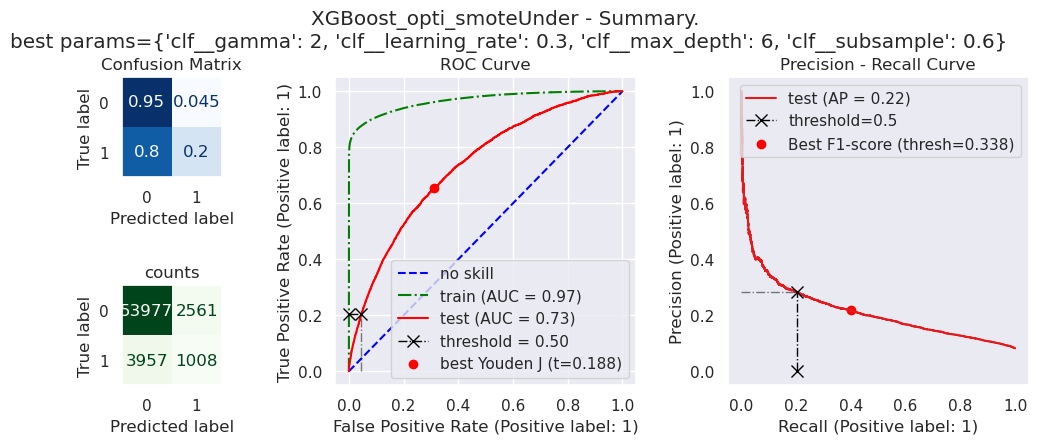

In [138]:
evaluate_model(Experience, XGBoost_pipeline_SU,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [139]:
XGB_opt_su = df_scores_models.loc[df_scores_models["Experience"] ==
                                  "XGBoost_opti_smoteUnder"]
XGB_opt_su

Experience                                             params  \
5  XGBoost_opti_smoteUnder  {'clf__gamma': 2, 'clf__learning_rate': 0.3, '...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
5      14.924          844.361   0.203      0.282     0.894     0.236   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
5     0.215     0.205  ...           0.015712                   0.837317   

  std_test_business_metric mean_train_business_metric  \
5                 0.287389                   0.891692   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
5                  0.050591           0.814153           0.329034   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
5             0.893372           0.049902                       0.5  

[1 rows x 38 columns]

**Data balancing using class_weights**

In [140]:
# X_train, y_train
# X_val, y_val

Experience = 'XGBoost_opti_classWeight'
XGBoost_pipeline_cw = imbpipeline.Pipeline(steps=[('clf',
                                                   xgb.XGBClassifier(
                                                scale_pos_weight = pos_weight,
                                                       random_state = seed))])

param_grid =  {'clf__learning_rate': [0.1, 0.01, 0.05],
               'clf__gamma': [0, 0.5, 2, 5],
               'clf__subsample': [0.6, 1.0],
               'clf__max_depth': [4, 6]}

XGBoost_pipeline_cw

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_para

Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV took 1805.588 s
Best Parameters: {'clf__gamma': 5, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__subsample': 1.0}
Best Train Score (roc_auc) : 0.767
Best Test Score (roc_auc): 0.737
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (XGBoost_opti_classWeight; training time = 7.22243746817112 s; estimated gridsearch time (240 splits) = 1747.237 s
add_model_score, model = XGBoost_opti_classWeight


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.995, 'precision': 0.083, 'accuracy': 0.117, 'f1_score': 0.154, 'f2_score': 0.312, 'f5_score': 0.701, 'f10_score': 0.898, 'business_metric': 0.351, 'tn': 2258, 'fp': 54280, 'fn': 23, 'tp': 4942, 'roc_auc': 0.739, 'ap_score': 0.22}
Plotting results for XGBoost_opti_classWeight with best_params : {'clf__gamma': 5, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__subsample': 1.0}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.99      0.04      0.08     56538
           1       0.08      1.00      0.15      4965

    accuracy                           0.12     61503
   macro avg       0.54      0.52      0.12     61503
weighted avg       0.92      0.12      0.08     61503

1-specificity(FPR) = 0.96, sensitivity(TPR) 1.00


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.900 (score = 0.526)
best threshold for f2_score : 0.850 (score = 0.315)
best threshold for business_metric : 0.900 (score = 0.365)
Best Threshold=1.000, Youden J =0.364
Best Threshold=1.000, F-Score=0.289


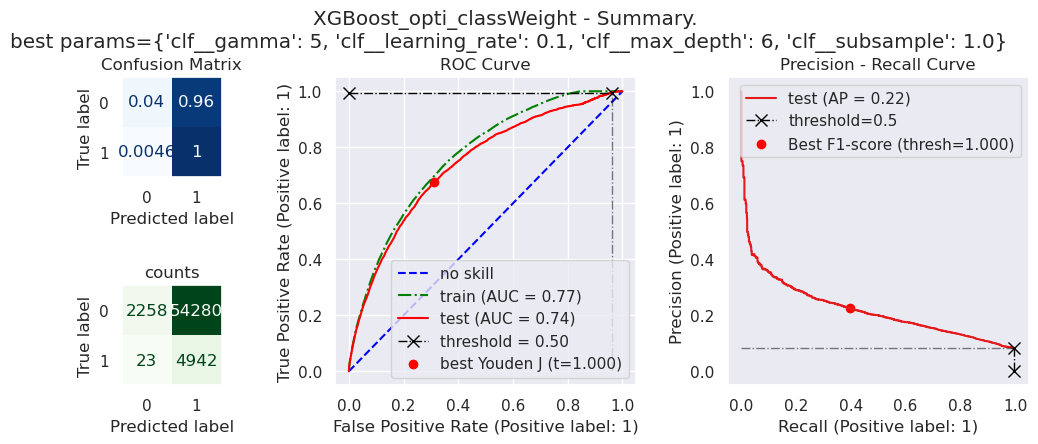

In [141]:
evaluate_model(Experience, XGBoost_pipeline_cw,
               X_train, y_train,
               X_val, y_val, param_grid)

In [142]:
XGBoost_opt_cw = df_scores_models.loc[df_scores_models["Experience"] ==
                                      "XGBoost_opti_classWeight"]
XGBoost_opt_cw

Experience  \
6  XGBoost_opti_classWeight   

                                              params  train_time  \
6  {'clf__gamma': 5, 'clf__learning_rate': 0.1, '...      10.662   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
6         1747.237   0.995      0.083     0.117     0.154     0.312     0.701   

   ...  std_train_roc_auc  mean_test_business_metric std_test_business_metric  \
6  ...           0.000428                   0.352259                 0.000853   

  mean_train_business_metric std_train_business_metric mean_test_f2_score  \
6                    0.35456                   0.00055           0.312412   

   std_test_f2_score  mean_train_f2_score std_train_f2_score  \
6           0.000307             0.314473           0.000184   

   discrimination_threshold  
6                       0.5  

[1 rows x 38 columns]

<a id='roptimization_LightGBM'></a>

### <span style='background:#0075bc'><span style='color:white'>LightGBM</span></span>

**Data balancing using SMOTE & RandomUnderSampling**

In [143]:

# X_train_SMOTE_UNDER, y_train_SMOTE_UNDER
# X_val, y_val

Experience = 'LGBM_smoteUnder'

LGBM_SU_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(random_state = seed))])

param_grid = {'clf__max_depth': [10, 50, 150],
              'clf__n_estimators': [100, 200],
             'clf__learning_rate': [0.01, 0.01, 1]}

LGBM_SU_pipeline

Pipeline(steps=[('clf', LGBMClassifier(random_state=84))])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV took 195.976 s
Best Parameters: {'clf__learning_rate': 1, 'clf__max_depth': 10, 'clf__n_estimators': 100}
Best Train Score (roc_auc) : 0.970
Best Test Score (roc_auc): 0.927
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_smoteUnder; training time = 1.4673867199156019 s; estimated gridsearch time (90 splits) = 144.879 s
add_model_score, model = LGBM_smoteUnder


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.23, 'precision': 0.203, 'accuracy': 0.865, 'f1_score': 0.216, 'f2_score': 0.224, 'f5_score': 0.229, 'f10_score': 0.23, 'business_metric': 0.696, 'tn': 52058, 'fp': 4480, 'fn': 3821, 'tp': 1144, 'roc_auc': 0.702, 'ap_score': 0.156}
Plotting results for LGBM_smoteUnder with best_params : {'clf__learning_rate': 1, 'clf__max_depth': 10, 'clf__n_estimators': 100}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     56538
           1       0.20      0.23      0.22      4965

    accuracy                           0.87     61503
   macro avg       0.57      0.58      0.57     61503
weighted avg       0.87      0.87      0.87     61503

1-specificity(FPR) = 0.08, sensitivity(TPR) 0.23


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.100 (score = 0.649)
best threshold for f2_score : 0.100 (score = 0.377)
best threshold for business_metric : 0.400 (score = 0.698)
Best Threshold=0.119, Youden J =0.300
Best Threshold=0.313, F-Score=0.244


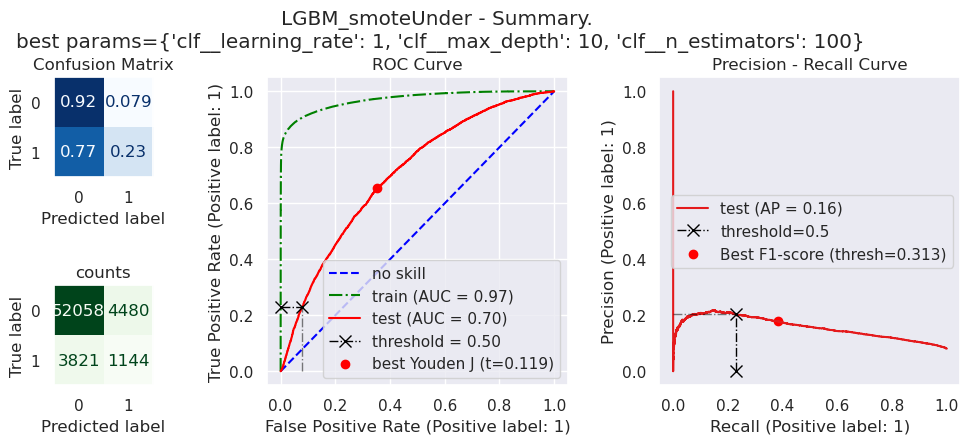

In [144]:
evaluate_model(Experience, LGBM_SU_pipeline,
               X_train_SMOTE_UNDER, y_train_SMOTE_UNDER,
               X_val, y_val, param_grid)

In [145]:
LGBM_SU_opt = df_scores_models.loc[df_scores_models["Experience"] == 
                                   "LGBM_smoteUnder"]
LGBM_SU_opt

Experience                                             params  \
7  LGBM_smoteUnder  {'clf__learning_rate': 1, 'clf__max_depth': 10...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
7       1.009          144.879    0.23      0.203     0.865     0.216   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
7     0.224     0.229  ...           0.002202                   0.831212   

  std_test_business_metric mean_train_business_metric  \
7                 0.279485                   0.907898   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
7                  0.038093           0.808478            0.31764   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
7             0.909061           0.037426                       0.5  

[1 rows x 38 columns]

**Data balancing using class_weights**

In [146]:
# Using class_weight

# X_train, y_train
# X_val, y_val

Experience = 'LGBM_class_weight'

LGBM_CW_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(
                                        class_weight = 'balanced',
                                        random_state = seed))])

param_grid = {'clf__max_depth': [10, 50, 100],
              'clf__n_estimators': [100, 400],
             'clf__learning_rate': [0.01, 0.01, 1]}

LGBM_CW_pipeline

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', random_state=84))])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV took 336.365 s
Best Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 50, 'clf__n_estimators': 400}
Best Train Score (roc_auc) : 0.788
Best Test Score (roc_auc): 0.767
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_class_weight; training time = 2.486360541979472 s; estimated gridsearch time (90 splits) = 245.468 s
add_model_score, model = LGBM_class_weight


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.7, 'precision': 0.169, 'accuracy': 0.697, 'f1_score': 0.272, 'f2_score': 0.429, 'f5_score': 0.624, 'f10_score': 0.679, 'business_metric': 0.698, 'tn': 39388, 'fp': 17150, 'fn': 1489, 'tp': 3476, 'roc_auc': 0.766, 'ap_score': 0.255}
Plotting results for LGBM_class_weight with best_params : {'clf__learning_rate': 0.01, 'clf__max_depth': 50, 'clf__n_estimators': 400}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56538
           1       0.17      0.70      0.27      4965

    accuracy                           0.70     61503
   macro avg       0.57      0.70      0.54     61503
weighted avg       0.90      0.70      0.77     61503

1-specificity(FPR) = 0.30, sensitivity(TPR) 0.70


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.500 (score = 0.698)
best threshold for f2_score : 0.500 (score = 0.429)
best threshold for business_metric : 0.650 (score = 0.737)
Best Threshold=0.504, Youden J =0.398
Best Threshold=0.665, F-Score=0.315


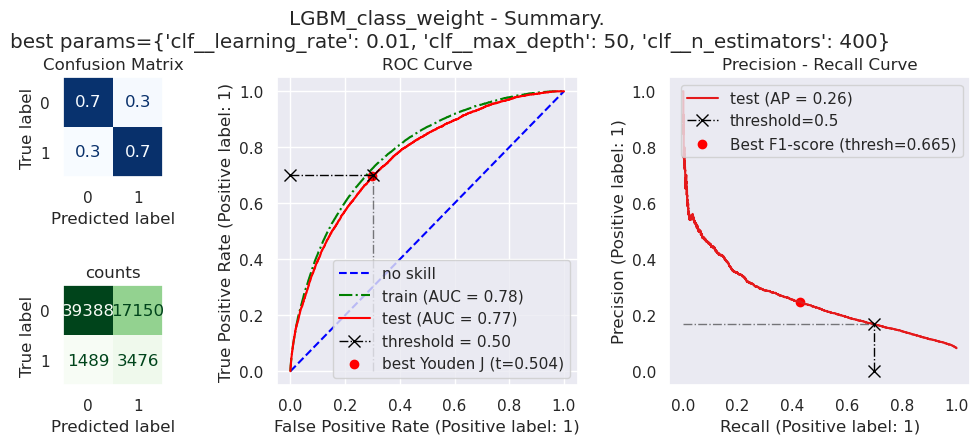

In [147]:
evaluate_model(Experience, LGBM_CW_pipeline, X_train, y_train,
            X_val, y_val, param_grid)

In [148]:
LGBM_cw_opt = df_scores_models.loc[df_scores_models["Experience"] ==
                                   "LGBM_class_weight"]
LGBM_cw_opt

Experience                                             params  \
8  LGBM_class_weight  {'clf__learning_rate': 0.01, 'clf__max_depth':...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
8       5.491          245.468     0.7      0.169     0.697     0.272   

   f2_score  f5_score  ...  std_train_roc_auc  mean_test_business_metric  \
8     0.429     0.624  ...           0.000668                   0.698992   

  std_test_business_metric mean_train_business_metric  \
8                 0.001027                   0.710273   

  std_train_business_metric mean_test_f2_score  std_test_f2_score  \
8                   0.00113            0.42952           0.002499   

   mean_train_f2_score std_train_f2_score  discrimination_threshold  
8              0.44755           0.001155                       0.5  

[1 rows x 38 columns]

<a id='model_comparison'></a>


## <span style='background:#0085dd'><span style='color:white'>Model comparison</span></span>


In [149]:
# Open the table recording scores associated to best parameters for each model
path_score_models = 'model_tests/df_scores_models.pkl'

with open(path_score_models, 'rb') as f:
    df_scores_models = pickle.load(f)

In [150]:
pd.set_option('display.max_columns', 200)

In [151]:
def plot_cv_scores(scores_models: pd.DataFrame, score='roc_auc', cible=None, figname=''):

    """Compare the cross-validation scores of each model on the train dataset"""

    scores_models = scores_models.copy()
    if not cible is None:
        scores_models = scores_models[scores_models['Experience'].str.contains(
            cible, case=False, regex=True)]
        if not '|' in cible:
            # if cible is not a regular expression
            scores_models['Experience'] = scores_models['Experience'].str.replace(cible, '')

    if f'mean_train_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_train_{score}'],
                     yerr=scores_models[f'std_train_{score}'],
                     fmt="+",
                     color="royalblue",
                     label="Training score")
    if f'mean_test_{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[f'mean_test_{score}'],
                     yerr=scores_models[f'std_test_{score}'],
                     fmt="d",
                     color="lightsteelblue",
                     label="Cross-validation score")
    if f'{score}' in scores_models.columns:
        plt.errorbar(x=scores_models['Experience'],
                     y=scores_models[score],
                     yerr=0,
                     fmt="o",
                     color="red",
                     label="Test score")
    ax = plt.gca()
    plt.legend(loc='best')
    plt.xticks(rotation=90)
    plt.xlabel(f'Experience')
    plt.ylabel(f'score ({score})')
    sns.despine()
    suptitre = f'Cross-validation score ({score})'
    if not cible is None:
        suptitre += f' - {cible}'
    plt.suptitle(suptitre)
    plt.title(f"Score on training and test data sets")




* All results with an **'mean_test_auc' over 0.82** are suspected of **overfitting** as a result, they will no longer be considered in the future.

In [152]:
# Models to be ignored
df_scores_models.loc[df_scores_models["mean_test_auc"]>=0.82]

Experience                                             params  \
0         Baseline (Dummy)                                                 {}   
5  XGBoost_opti_smoteUnder  {'clf__gamma': 2, 'clf__learning_rate': 0.3, '...   
7          LGBM_smoteUnder  {'clf__learning_rate': 1, 'clf__max_depth': 10...   

   train_time  gridsearch_time  recall  precision  accuracy  f1_score  \
0       0.005            0.182   0.000      0.000     0.919     0.000   
5      14.924          844.361   0.203      0.282     0.894     0.236   
7       1.009          144.879   0.230      0.203     0.865     0.216   

   f2_score  f5_score  f10_score  business_metric     tn    fp    fn    tp  \
0     0.000     0.000      0.000            0.674  56538     0  4965     0   
5     0.215     0.205      0.204            0.710  53977  2561  3957  1008   
7     0.224     0.229      0.230            0.696  52058  4480  3821  1144   

   roc_auc  ap_score                                              model  \
0    0.500     0.081  (DummyClassifier(random_state=84, strategy='mo...   
5    0.579     0.122  (XGBClassifier(base_score=None, booster=None, ...   
7    0.576     0.109  (LGBMClassifier(learning_rate=1, max_depth=10,...   

   best_cv_score  refit_time  mean_test_auc  std_test_auc  mean_train_auc  \
0       0.500000    0.005029       0.919271  8.038188e-07        0.919271   
5       0.939957   14.667084       0.881941  1.594547e-01        0.920424   
7       0.926599    1.785134       0.863174  1.516629e-01        0.924734   

   std_train_auc  mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  \
0   2.009537e-07           0.500000          0.000000            0.500000   
5   3.738654e-02           0.939957          0.114234            0.968474   
7   2.898491e-02           0.926599          0.130191            0.970010   

   std_train_roc_auc  mean_test_business_metric  std_test_business_metric  \
0           0.000000                   0.674308                  0.000002   
5           0.015712                   0.837317                  0.287389   
7           0.002202                   0.831212                  0.279485   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
0                    0.674308               5.946865e-07            0.000000   
5                    0.891692               5.059132e-02            0.814153   
7                    0.907898               3.809303e-02            0.808478   

   std_test_f2_score  mean_train_f2_score  std_train_f2_score  \
0           0.000000             0.000000            0.000000   
5           0.329034             0.893372            0.049902   
7           0.317640             0.909061            0.037426   

   discrimination_threshold  
0                       0.5  
5                       0.5  
7                       0.5

In [153]:
# Models to be considered
df_scores_models_to_analyse = \
        df_scores_models.loc[df_scores_models["mean_test_auc"]<0.82]
df_scores_models_to_analyse

Experience  \
1        LogisticRegression_smoteUnder   
2  LogisticRegression_opti_classWeight   
3         RForestClass_opti_smoteUnder   
4        RandomForest_opti_classWeight   
6             XGBoost_opti_classWeight   
8                    LGBM_class_weight   

                                              params  train_time  \
1  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.110   
2  {'clf__penalty': 'l1', 'clf__solver': 'libline...       3.098   
3    {'clf__criterion': 'gini', 'clf__max_depth': 9}      43.868   
4  {'clf__criterion': 'entropy', 'clf__max_depth'...      47.154   
6  {'clf__gamma': 5, 'clf__learning_rate': 0.1, '...      10.662   
8  {'clf__learning_rate': 0.01, 'clf__max_depth':...       5.491   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
1            8.814   0.671      0.160     0.688     0.258     0.409     0.597   
2          103.596   0.670      0.160     0.689     0.258     0.409     0.597   
3         1878.587   0.603      0.161     0.714     0.254     0.389     0.545   
4         1202.570   0.633      0.175     0.730     0.274     0.415     0.575   
6         1747.237   0.995      0.083     0.117     0.154     0.312     0.701   
8          245.468   0.700      0.169     0.697     0.272     0.429     0.624   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
1      0.650            0.684  38994  17544  1635  3330    0.680     0.134   
2      0.650            0.684  39022  17516  1636  3329    0.680     0.134   
3      0.587            0.684  40915  15623  1971  2994    0.663     0.129   
4      0.617            0.704  41733  14805  1824  3141    0.685     0.140   
6      0.898            0.351   2258  54280    23  4942    0.518     0.083   
8      0.679            0.698  39388  17150  1489  3476    0.698     0.142   

                                               model  best_cv_score  \
1  (LogisticRegression(penalty='l1', random_state...       0.748522   
2  (LogisticRegression(class_weight='balanced', p...       0.741975   
3  ((DecisionTreeClassifier(max_depth=9, max_feat...       0.824221   
4  ((DecisionTreeClassifier(criterion='entropy', ...       0.751676   
6  (XGBClassifier(base_score=None, booster=None, ...       0.736902   
8  (LGBMClassifier(class_weight='balanced', learn...       0.767116   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
1    1.023518       0.683305      0.002440        0.683622       0.000738   
2    3.182866       0.689043      0.000742        0.689035       0.000297   
3   43.852690       0.742912      0.041622        0.763635       0.015532   
4   47.144300       0.737651      0.002356        0.750979       0.001384   
6   11.370079       0.119472      0.001194        0.120083       0.000749   
8    5.845203       0.699705      0.002518        0.704497       0.001548   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
1           0.748522          0.003964            0.748812           0.000995   
2           0.741975          0.001764            0.742677           0.000418   
3           0.824221          0.046182            0.845966           0.015855   
4           0.751676          0.002246            0.817043           0.000517   
6           0.736902          0.003443            0.767012           0.000428   
8           0.767116          0.002201            0.787773           0.000668   

   mean_test_business_metric  std_test_business_metric  \
1                   0.678560                  0.003493   
2                   0.683201                  0.000720   
3                   0.752267                  0.079349   
4                   0.705774                  0.000791   
6                   0.352259                  0.000853   
8                   0.698992                  0.001027   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
1                    0.678892                   

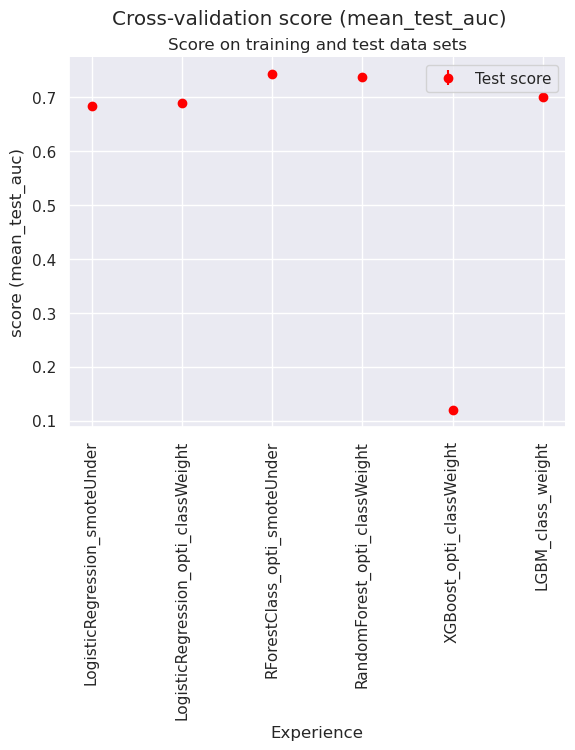

In [154]:
plot_cv_scores(df_scores_models_to_analyse, score='mean_test_auc')

In [155]:
df_scores_models_to_analyse.sort_values(by='mean_test_auc', ascending=False)

Experience  \
3         RForestClass_opti_smoteUnder   
4        RandomForest_opti_classWeight   
8                    LGBM_class_weight   
2  LogisticRegression_opti_classWeight   
1        LogisticRegression_smoteUnder   
6             XGBoost_opti_classWeight   

                                              params  train_time  \
3    {'clf__criterion': 'gini', 'clf__max_depth': 9}      43.868   
4  {'clf__criterion': 'entropy', 'clf__max_depth'...      47.154   
8  {'clf__learning_rate': 0.01, 'clf__max_depth':...       5.491   
2  {'clf__penalty': 'l1', 'clf__solver': 'libline...       3.098   
1  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.110   
6  {'clf__gamma': 5, 'clf__learning_rate': 0.1, '...      10.662   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
3         1878.587   0.603      0.161     0.714     0.254     0.389     0.545   
4         1202.570   0.633      0.175     0.730     0.274     0.415     0.575   
8          245.468   0.700      0.169     0.697     0.272     0.429     0.624   
2          103.596   0.670      0.160     0.689     0.258     0.409     0.597   
1            8.814   0.671      0.160     0.688     0.258     0.409     0.597   
6         1747.237   0.995      0.083     0.117     0.154     0.312     0.701   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
3      0.587            0.684  40915  15623  1971  2994    0.663     0.129   
4      0.617            0.704  41733  14805  1824  3141    0.685     0.140   
8      0.679            0.698  39388  17150  1489  3476    0.698     0.142   
2      0.650            0.684  39022  17516  1636  3329    0.680     0.134   
1      0.650            0.684  38994  17544  1635  3330    0.680     0.134   
6      0.898            0.351   2258  54280    23  4942    0.518     0.083   

                                               model  best_cv_score  \
3  ((DecisionTreeClassifier(max_depth=9, max_feat...       0.824221   
4  ((DecisionTreeClassifier(criterion='entropy', ...       0.751676   
8  (LGBMClassifier(class_weight='balanced', learn...       0.767116   
2  (LogisticRegression(class_weight='balanced', p...       0.741975   
1  (LogisticRegression(penalty='l1', random_state...       0.748522   
6  (XGBClassifier(base_score=None, booster=None, ...       0.736902   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
3   43.852690       0.742912      0.041622        0.763635       0.015532   
4   47.144300       0.737651      0.002356        0.750979       0.001384   
8    5.845203       0.699705      0.002518        0.704497       0.001548   
2    3.182866       0.689043      0.000742        0.689035       0.000297   
1    1.023518       0.683305      0.002440        0.683622       0.000738   
6   11.370079       0.119472      0.001194        0.120083       0.000749   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
3           0.824221          0.046182            0.845966           0.015855   
4           0.751676          0.002246            0.817043           0.000517   
8           0.767116          0.002201            0.787773           0.000668   
2           0.741975          0.001764            0.742677           0.000418   
1           0.748522          0.003964            0.748812           0.000995   
6           0.736902          0.003443            0.767012           0.000428   

   mean_test_business_metric  std_test_business_metric  \
3                   0.752267                  0.079349   
4                   0.705774                  0.000791   
8                   0.698992                  0.001027   
2                   0.683201                  0.000720   
1                   0.678560                  0.003493   
6                   0.352259                  0.000853   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
3                    0.780637                   

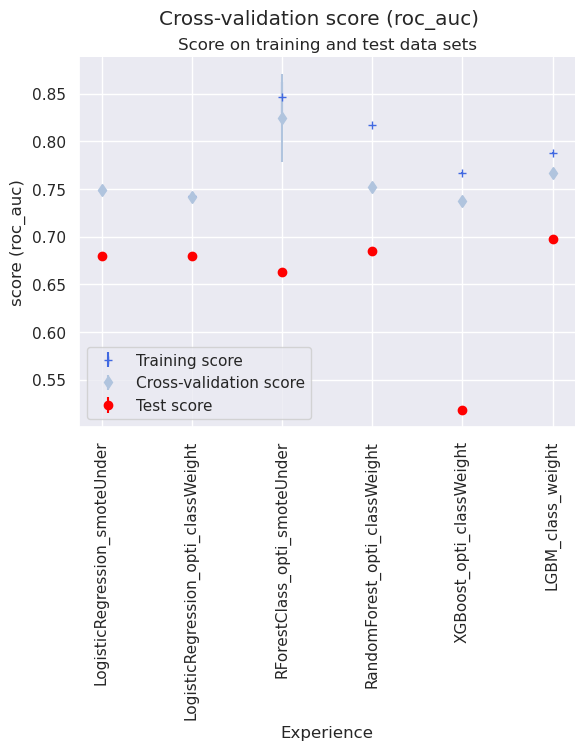

In [156]:
plot_cv_scores(df_scores_models_to_analyse)

In [157]:
df_scores_models_to_analyse.sort_values(by='roc_auc', ascending=False)

Experience  \
8                    LGBM_class_weight   
4        RandomForest_opti_classWeight   
1        LogisticRegression_smoteUnder   
2  LogisticRegression_opti_classWeight   
3         RForestClass_opti_smoteUnder   
6             XGBoost_opti_classWeight   

                                              params  train_time  \
8  {'clf__learning_rate': 0.01, 'clf__max_depth':...       5.491   
4  {'clf__criterion': 'entropy', 'clf__max_depth'...      47.154   
1  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.110   
2  {'clf__penalty': 'l1', 'clf__solver': 'libline...       3.098   
3    {'clf__criterion': 'gini', 'clf__max_depth': 9}      43.868   
6  {'clf__gamma': 5, 'clf__learning_rate': 0.1, '...      10.662   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
8          245.468   0.700      0.169     0.697     0.272     0.429     0.624   
4         1202.570   0.633      0.175     0.730     0.274     0.415     0.575   
1            8.814   0.671      0.160     0.688     0.258     0.409     0.597   
2          103.596   0.670      0.160     0.689     0.258     0.409     0.597   
3         1878.587   0.603      0.161     0.714     0.254     0.389     0.545   
6         1747.237   0.995      0.083     0.117     0.154     0.312     0.701   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
8      0.679            0.698  39388  17150  1489  3476    0.698     0.142   
4      0.617            0.704  41733  14805  1824  3141    0.685     0.140   
1      0.650            0.684  38994  17544  1635  3330    0.680     0.134   
2      0.650            0.684  39022  17516  1636  3329    0.680     0.134   
3      0.587            0.684  40915  15623  1971  2994    0.663     0.129   
6      0.898            0.351   2258  54280    23  4942    0.518     0.083   

                                               model  best_cv_score  \
8  (LGBMClassifier(class_weight='balanced', learn...       0.767116   
4  ((DecisionTreeClassifier(criterion='entropy', ...       0.751676   
1  (LogisticRegression(penalty='l1', random_state...       0.748522   
2  (LogisticRegression(class_weight='balanced', p...       0.741975   
3  ((DecisionTreeClassifier(max_depth=9, max_feat...       0.824221   
6  (XGBClassifier(base_score=None, booster=None, ...       0.736902   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
8    5.845203       0.699705      0.002518        0.704497       0.001548   
4   47.144300       0.737651      0.002356        0.750979       0.001384   
1    1.023518       0.683305      0.002440        0.683622       0.000738   
2    3.182866       0.689043      0.000742        0.689035       0.000297   
3   43.852690       0.742912      0.041622        0.763635       0.015532   
6   11.370079       0.119472      0.001194        0.120083       0.000749   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
8           0.767116          0.002201            0.787773           0.000668   
4           0.751676          0.002246            0.817043           0.000517   
1           0.748522          0.003964            0.748812           0.000995   
2           0.741975          0.001764            0.742677           0.000418   
3           0.824221          0.046182            0.845966           0.015855   
6           0.736902          0.003443            0.767012           0.000428   

   mean_test_business_metric  std_test_business_metric  \
8                   0.698992                  0.001027   
4                   0.705774                  0.000791   
1                   0.678560                  0.003493   
2                   0.683201                  0.000720   
3                   0.752267                  0.079349   
6                   0.352259                  0.000853   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
8                    0.710273                   

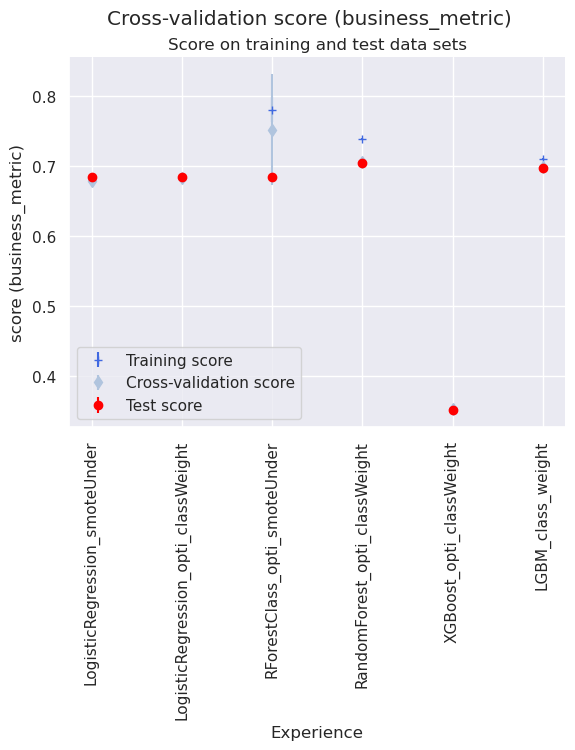

In [158]:
plot_cv_scores(df_scores_models_to_analyse, score='business_metric')

In [159]:
df_scores_models_to_analyse.sort_values(by='business_metric', ascending=False)

Experience  \
4        RandomForest_opti_classWeight   
8                    LGBM_class_weight   
1        LogisticRegression_smoteUnder   
2  LogisticRegression_opti_classWeight   
3         RForestClass_opti_smoteUnder   
6             XGBoost_opti_classWeight   

                                              params  train_time  \
4  {'clf__criterion': 'entropy', 'clf__max_depth'...      47.154   
8  {'clf__learning_rate': 0.01, 'clf__max_depth':...       5.491   
1  {'clf__penalty': 'l1', 'clf__solver': 'libline...       1.110   
2  {'clf__penalty': 'l1', 'clf__solver': 'libline...       3.098   
3    {'clf__criterion': 'gini', 'clf__max_depth': 9}      43.868   
6  {'clf__gamma': 5, 'clf__learning_rate': 0.1, '...      10.662   

   gridsearch_time  recall  precision  accuracy  f1_score  f2_score  f5_score  \
4         1202.570   0.633      0.175     0.730     0.274     0.415     0.575   
8          245.468   0.700      0.169     0.697     0.272     0.429     0.624   
1            8.814   0.671      0.160     0.688     0.258     0.409     0.597   
2          103.596   0.670      0.160     0.689     0.258     0.409     0.597   
3         1878.587   0.603      0.161     0.714     0.254     0.389     0.545   
6         1747.237   0.995      0.083     0.117     0.154     0.312     0.701   

   f10_score  business_metric     tn     fp    fn    tp  roc_auc  ap_score  \
4      0.617            0.704  41733  14805  1824  3141    0.685     0.140   
8      0.679            0.698  39388  17150  1489  3476    0.698     0.142   
1      0.650            0.684  38994  17544  1635  3330    0.680     0.134   
2      0.650            0.684  39022  17516  1636  3329    0.680     0.134   
3      0.587            0.684  40915  15623  1971  2994    0.663     0.129   
6      0.898            0.351   2258  54280    23  4942    0.518     0.083   

                                               model  best_cv_score  \
4  ((DecisionTreeClassifier(criterion='entropy', ...       0.751676   
8  (LGBMClassifier(class_weight='balanced', learn...       0.767116   
1  (LogisticRegression(penalty='l1', random_state...       0.748522   
2  (LogisticRegression(class_weight='balanced', p...       0.741975   
3  ((DecisionTreeClassifier(max_depth=9, max_feat...       0.824221   
6  (XGBClassifier(base_score=None, booster=None, ...       0.736902   

   refit_time  mean_test_auc  std_test_auc  mean_train_auc  std_train_auc  \
4   47.144300       0.737651      0.002356        0.750979       0.001384   
8    5.845203       0.699705      0.002518        0.704497       0.001548   
1    1.023518       0.683305      0.002440        0.683622       0.000738   
2    3.182866       0.689043      0.000742        0.689035       0.000297   
3   43.852690       0.742912      0.041622        0.763635       0.015532   
6   11.370079       0.119472      0.001194        0.120083       0.000749   

   mean_test_roc_auc  std_test_roc_auc  mean_train_roc_auc  std_train_roc_auc  \
4           0.751676          0.002246            0.817043           0.000517   
8           0.767116          0.002201            0.787773           0.000668   
1           0.748522          0.003964            0.748812           0.000995   
2           0.741975          0.001764            0.742677           0.000418   
3           0.824221          0.046182            0.845966           0.015855   
6           0.736902          0.003443            0.767012           0.000428   

   mean_test_business_metric  std_test_business_metric  \
4                   0.705774                  0.000791   
8                   0.698992                  0.001027   
1                   0.678560                  0.003493   
2                   0.683201                  0.000720   
3                   0.752267                  0.079349   
6                   0.352259                  0.000853   

   mean_train_business_metric  std_train_business_metric  mean_test_f2_score  \
4                    0.739159                   

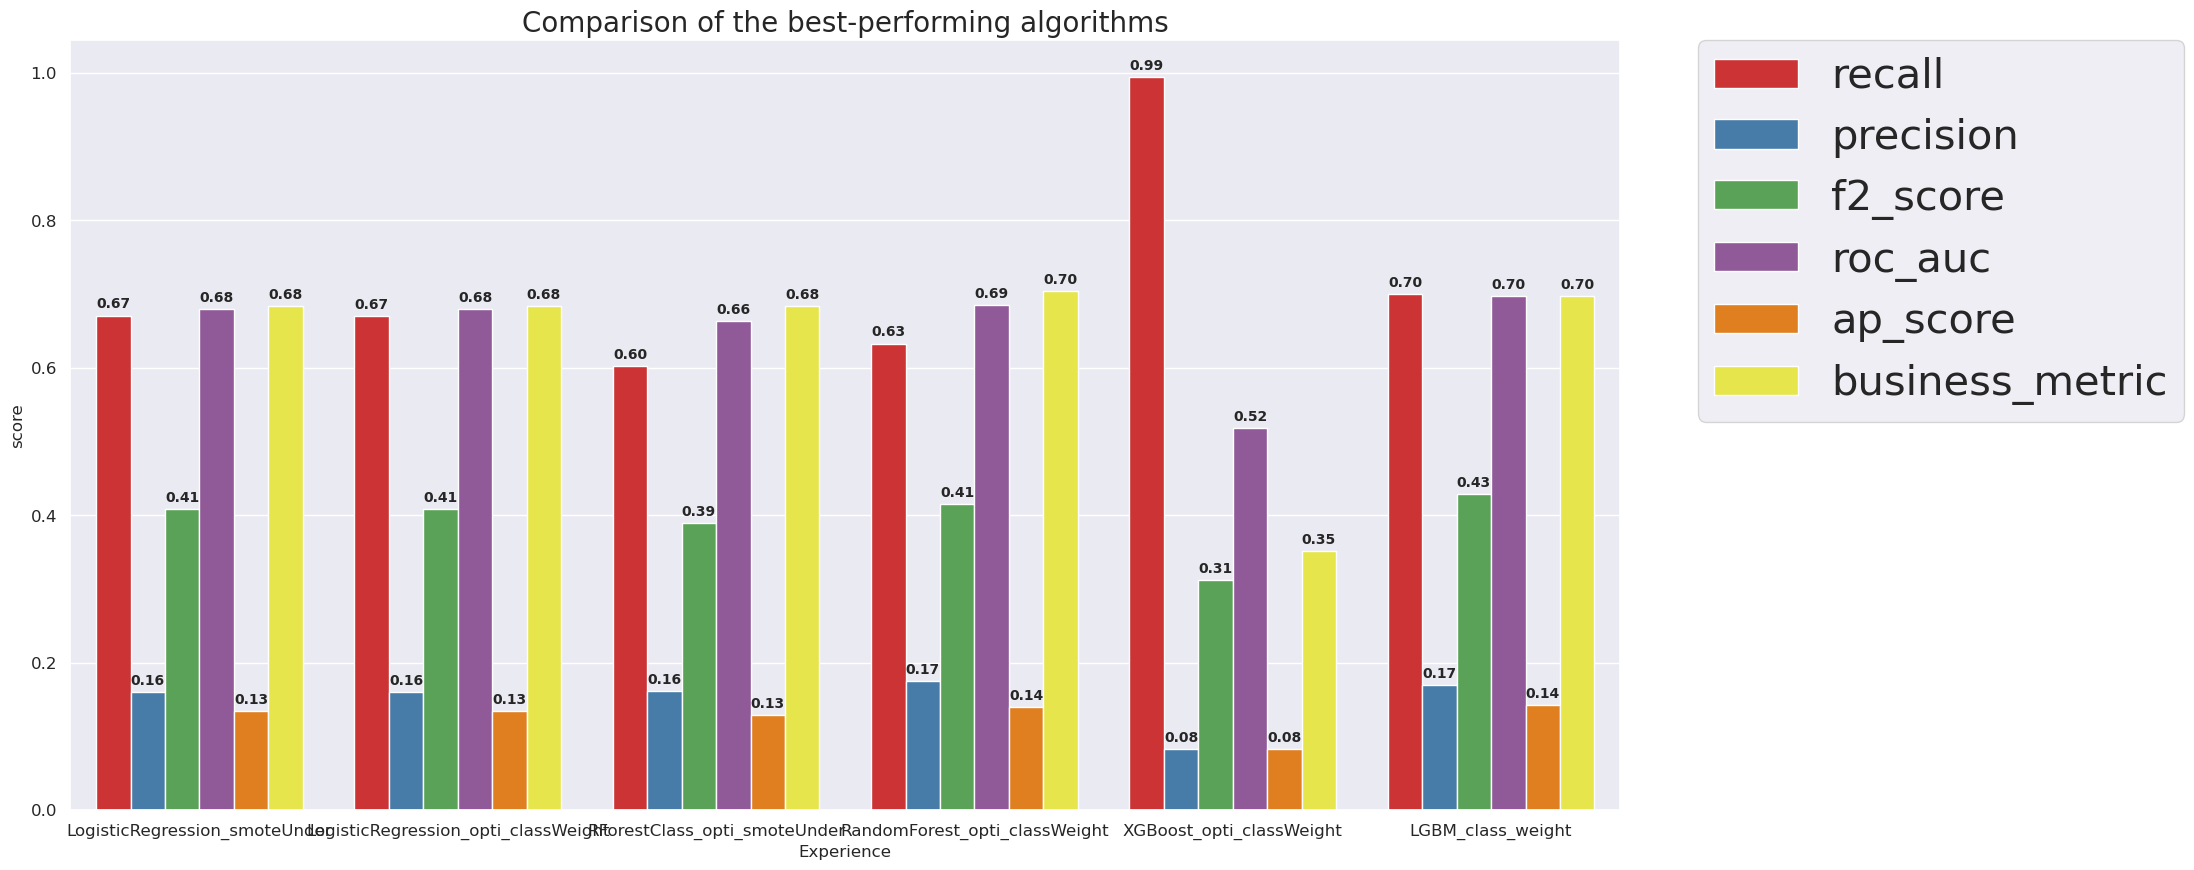

In [160]:
# Visual comparison of algorithms


# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models_to_analyse, id_vars=['Experience'],
            value_name='score',
            value_vars=['recall', 'precision', 'f2_score',
                        'roc_auc', 'ap_score', 'business_metric'])
# Visualization
plt.figure(figsize=(20, 10))
ax= sns.barplot(x=comparaison_models_melt['Experience'],
                y=comparaison_models_melt['score'],
            hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold') 
plt.show()

df_scores_models_to_analyse[['Experience', 'recall', 'precision', 'f2_score',
                             'roc_auc', 'ap_score', 'business_metric']].style.hide(axis="index")

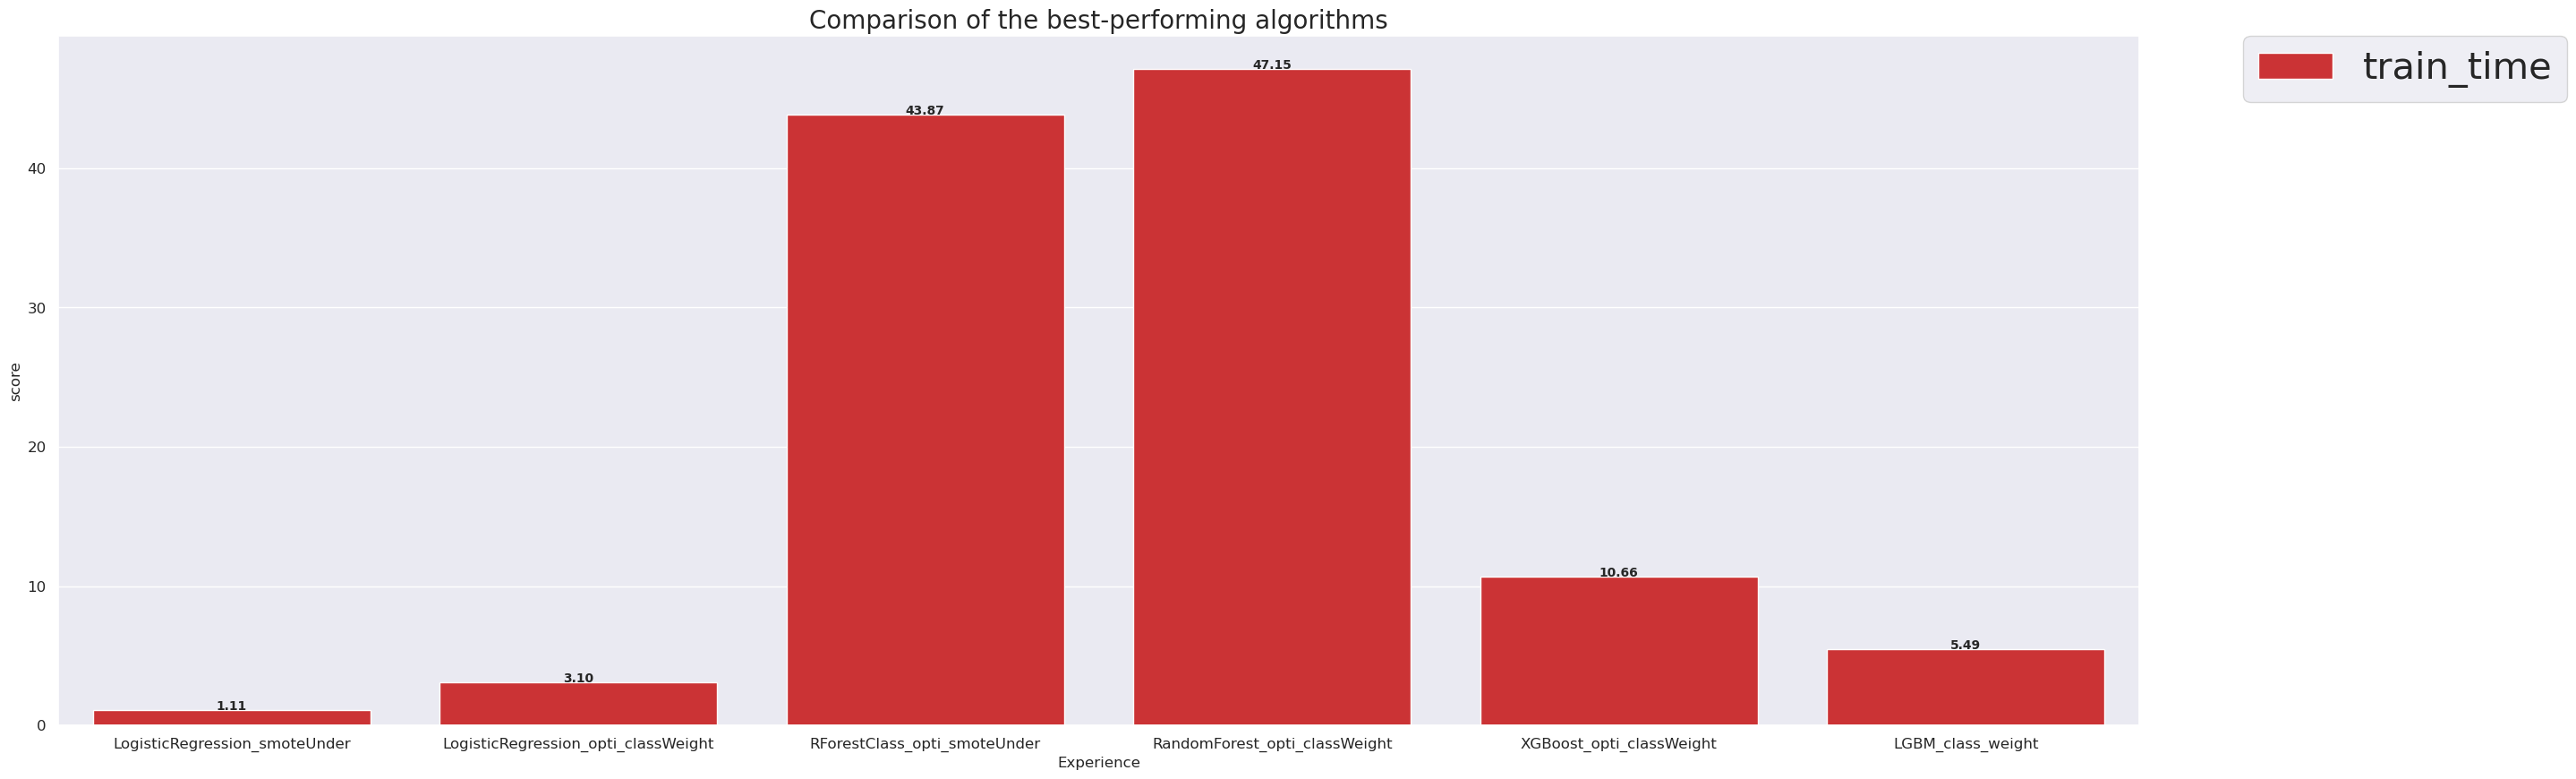

In [161]:
# Visual comparison of algorithms


# Scores
comparaison_models_melt = \
    pd.melt(df_scores_models_to_analyse, id_vars=['Experience'],
            value_name='score',
            value_vars=['train_time'])
# Visualization
plt.figure(figsize=(30, 10))
ax= sns.barplot(x=comparaison_models_melt['Experience'],
                y=comparaison_models_melt['score'],
            hue=comparaison_models_melt['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold') 
plt.show()

df_scores_models_to_analyse[['Experience',
                             'train_time']].style.hide(axis="index")

<a id='best_model_selection'></a>


## <span style='background:#0085dd'><span style='color:white'>Best model selection</span></span>


The best results for scores are obtained using XG Boost and Light GBM.
Since the time needed for training is much shorter, **Light GBM will be implemented for the rest of the project**.

<a id='best_model'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Best model** </span></span>


<a id='load_full_data_train'></a>

## <span style='background:#0085dd'><span style='color:white'>Model training on the whole dataset</span></span>

In [57]:
# -----------------------------
# Files loading:
# -----------------------------

# Open final train_dataset
path_train_data = \
    'preprocessing/train_data_fs_t25_combi_ML.pkl'

with open(path_train_data, 'rb') as f:
    train_data = pickle.load(f)


# Open final test_dataset
path_test_data = \
    'preprocessing/test_data_fs_t25_combi_ML.pkl'
os.makedirs(os.path.dirname(path_test_data), exist_ok=True)

In [58]:
# Define target
y = train_data.pop('TARGET')
print(f'y : {y.shape}')

# Transfer of the customer identifier to the index for modelling purposes
train_data.set_index('SK_ID_CURR', inplace=True)
X = train_data
print(f'X : {X.shape}')

y : (307511,)
X : (307511, 33)


In [59]:
# Split dataset (filled)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  train_size=TRAIN_SIZE,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=seed)

In [62]:
# ----------------------------------------------
# Hyperparameter optimization with the whole dataset

Experience = 'LGBM_cw'

LGBM_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                    ltb.LGBMClassifier(
                                        class_weight = 'balanced',
                                        random_state = seed))])

param_grid = {'clf__max_depth': range(3, 10),
              'clf__min_child_samples': [50]}

LGBM_pipeline

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', random_state=84))])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV took 83.97 s
Best Parameters: {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Best Train Score (roc_auc) : 0.816
Best Test Score (roc_auc): 0.774
bestmodel type =  <class 'imblearn.pipeline.Pipeline'>
time_model (LGBM_cw; training time = 1.7085227285112654 s; estimated gridsearch time (35 splits) = 64.427 s
add_model_score, model = LGBM_cw


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


{'recall': 0.688, 'precision': 0.175, 'accuracy': 0.713, 'f1_score': 0.279, 'f2_score': 0.434, 'f5_score': 0.619, 'f10_score': 0.669, 'business_metric': 0.706, 'tn': 40403, 'fp': 16135, 'fn': 1547, 'tp': 3418, 'roc_auc': 0.772, 'ap_score': 0.268}
Plotting results for LGBM_cw with best_params : {'clf__max_depth': 8, 'clf__min_child_samples': 50}
Classification_report (threshold=0.500):
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.69      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

1-specificity(FPR) = 0.29, sensitivity(TPR) 0.69


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

best threshold for roc_auc : 0.500 (score = 0.702)
best threshold for f2_score : 0.500 (score = 0.434)
best threshold for business_metric : 0.650 (score = 0.740)
Best Threshold=0.465, Youden J =0.405
Best Threshold=0.694, F-Score=0.322


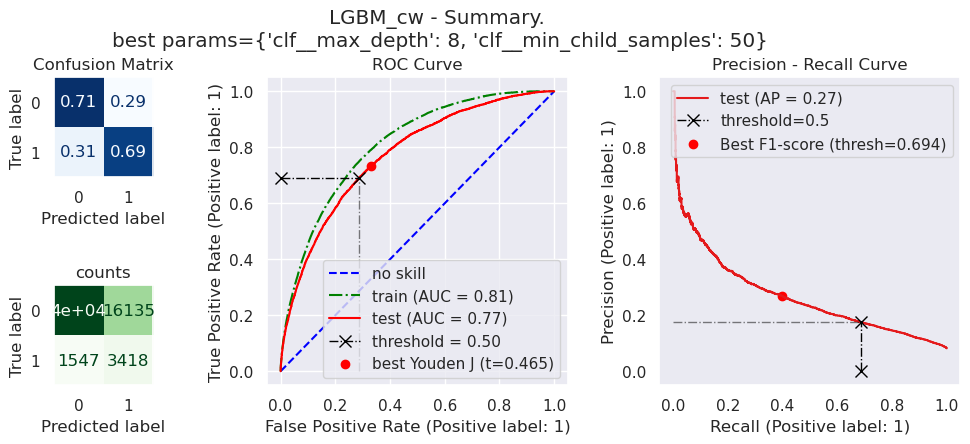

In [13]:
evaluate_model(Experience, LGBM_pipeline, X_train, y_train,
            X_val, y_val, param_grid)

In [63]:
# ---------------------------------------------
# Training the model with the best parameters

Experience = 'LGBM_cw_best_params_defafult_trhesh'
LGBM_best_params = dict(max_depth = 3, min_child_samples = 50)

LGBM_best_pipeline = imbpipeline.Pipeline(steps=[('clf',
                                                ltb.LGBMClassifier(
                                                    class_weight = 'balanced',
                                                    random_state = seed,
                                                    **LGBM_best_params))])

LGBM_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 LGBMClassifier(class_weight='balanced', max_depth=3,
                                min_child_samples=50, random_state=84))])

In [15]:

df_results_thresh = tools_modeling.process_classif_thresh(LGBM_best_pipeline, 0.5,
                                      X_train, X_val,
                                      y_train, y_val,
                                      df_results_thresh, Experience,
                                      show_results=False,
                                      show_conf_matrix=False)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<a id='prob_threshold_finetuning'></a>

## <span style='background:#0085dd'><span style='color:white'>Bank benefit (score) optimising by pobability threshold fine-tuning</span></span>

The optimisation was done on the "roc_auc" metric (balance between false negatives and false positives):

We can then optimise the probability discrimination threshold (<span style='background:LightBlue'>**tools_modeling.prob_threshold**</span>.) for the bank to accept or reject a loan, based on: 
(a) the business metric created above; or 
(b) another profit and loss metric which can vary based on the amount of credit, repayment duration, ...

This section optimises the discrimination threshold for the <span style='background:LightBlue'>**tools_modeling.custom_score**</span> metric.

In [64]:
df_thresholds = pd.DataFrame()

Maximum business metric score : 0.7378869468248147
Optimal threshold : 0.66


Thresholds  Business Score
0         0.00        0.325688
1         0.01        0.325712
2         0.02        0.326941
3         0.03        0.329910
4         0.04        0.332236
..         ...             ...
95        0.95        0.674312
96        0.96        0.674312
97        0.97        0.674312
98        0.98        0.674312
99        0.99        0.674312

[100 rows x 2 columns]

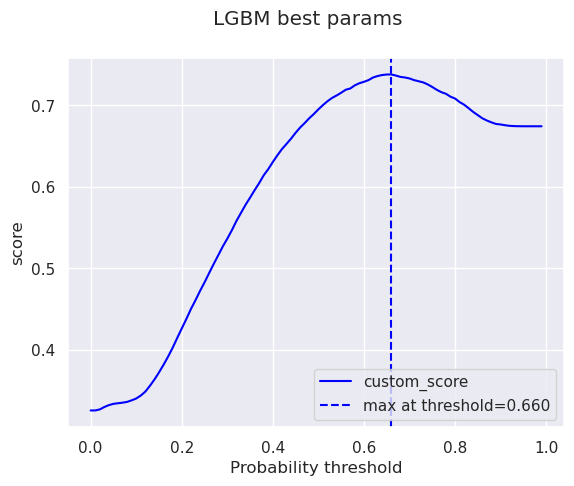

In [65]:
tools_modeling.prob_threshold(LGBM_best_pipeline, X_val, y_val, "LGBM best params", df_thresholds, n=1)

In [18]:
os.getcwd()

'/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit'

this method is deprecated in favour of `Styler.hide(axis="index")`


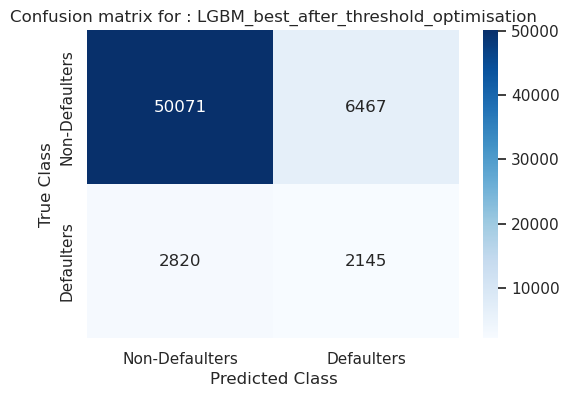

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [66]:
df_results_thresh = tools_modeling.process_classif_thresh(
    LGBM_best_pipeline, 0.66,
    X_train, X_val, y_train, y_val,
    df_results_thresh, "LGBM_best_after_threshold_optimisation")

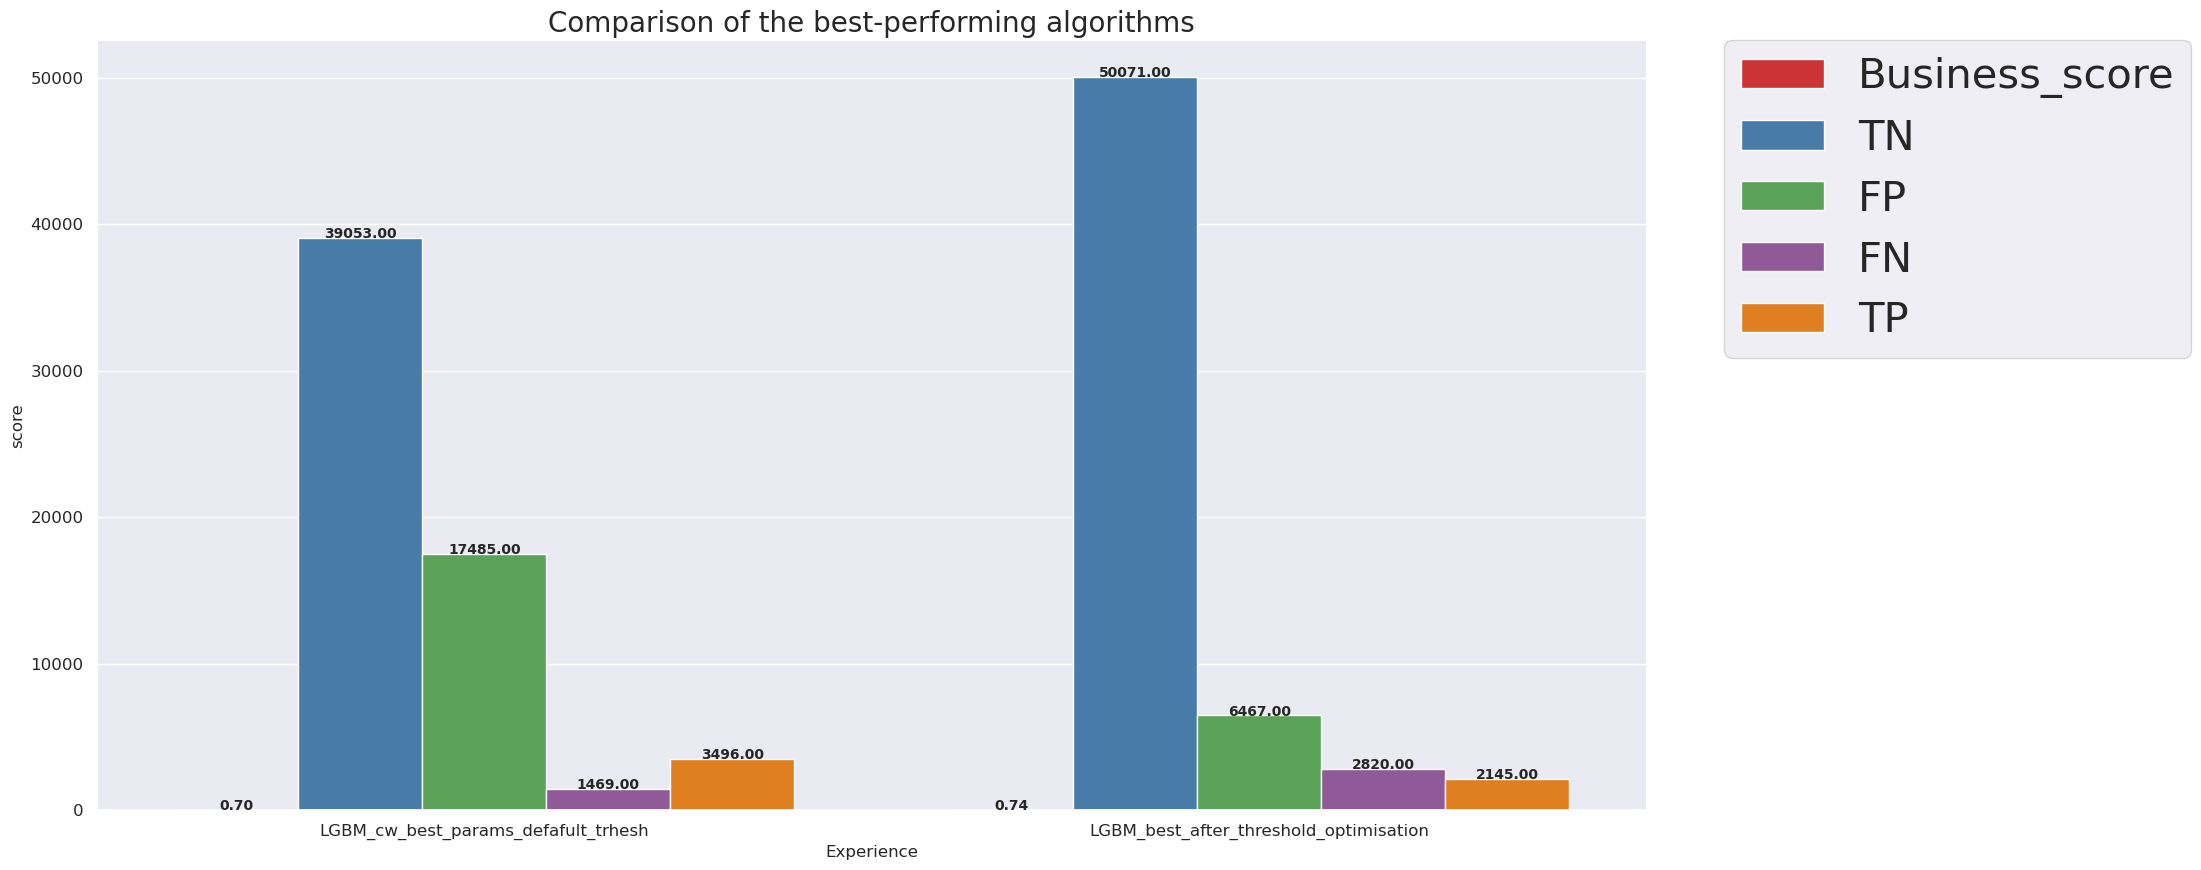

In [20]:
# Visual comparison results without and with
# probability threshold optimisaiton


# Scores
comparaison_tresh = \
    pd.melt(df_results_thresh, id_vars=['Experience'],
            value_name='score',
            value_vars=['Business_score', 'TN', 'FP', 'FN', 'TP'])
# Visualization
plt.figure(figsize=(20, 10))
ax= sns.barplot(x=comparaison_tresh['Experience'],
                y=comparaison_tresh['score'],
            hue=comparaison_tresh['variable'])
plt.title('Comparison of the best-performing algorithms',
          fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=10,
            fontweight='bold') 
plt.show()

df_results_thresh[['Experience', 'Business_score',
                   'TN', 'FP', 'FN', 'TP']].style.hide(axis="index")

The probability threshold optimisation results in:
* an improvement of the Business score 
* an increase in the True Negatives (non-defaulters identified as non-defaulters)
* a decrease in False Positives (defaulters identified as non-defaulters)
* an increase in False Negatives (non-defaulters identified as defaulters)
* a decrease in True Positives (defaulters identified as defaulters)

The optimised probability threshold value (0.66) will be retained for the development of the rest of the project.



<a id='save_best_model'></a>

## <span style='background:#0085dd'><span style='color:white'>Save best model</span></span>

In [28]:

LGBM_best_pipeline.fit(X_train, y_train)

path_save_models = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/'
if not os.path.exists(path_save_models):
    os.makedirs(path_save_models)

# Files of client data to visualize
datafiles=dict(X_val=X_val,
               y_val=y_val.to_frame())


for key in datafiles.keys():
    datafiles[key].to_csv(f'{path_save_models}/{key}.csv')

In [29]:
# Save best model
path_best_model = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/lgbm_best_model.pkl'

with open(path_best_model, 'wb') as f:
    pickle.dump(LGBM_best_pipeline, f, pickle.HIGHEST_PROTOCOL)

# Save X_val
path_X_val = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/X_val.pkl'

with open(path_X_val, 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

<a id='best_model_feature_importance'></a>

## <span style='background:#0085dd'><span style='color:white'>Feature importance</span></span>

Deux mesures, valable seulement si le modèle a un bon niveau de prédiction

- (impurity-based) feature importance ('model.feature*importances*')
- (permutation-based) feature importance (sklearn.inspection.permutation_importance)

On peut aussi se baser sur 'mutual_info_classification' comme une proxy de 'feature importance', avant le fit du model


In [30]:
# -----------------------------
# Files loading:
# -----------------------------
path_best_model = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/lgbm_best_model.pkl'

with open(path_best_model, 'rb') as f:
    best_model = pickle.load(f)

<a id='best_model_impurity_based_feat_imp'></a>

### <span style='background:#0075bc'><span style='color:white'>Impurity-based feature importance</span></span>

- computé sur le jeu d'entrainement pendant fit (TreeRegressors)
- basé sur 'entropy'
- peut avoir features trop important pour train mais pas très predictive (overfitting))
- bias vers les features avec grand cardinalité
- peut mettre trop d'importance pour les features numériques.


In [31]:
# Pour éviter des erreurs en changeant le pipeline, voici quelques utilitaires pour retourner l'estimateur, son classname, les attributs, les featureimportances, etc

def get_classifier(model):
    """Find the classifier in a pipeline"""
    
    if hasattr(model, 'coefs_') or hasattr(model, 'intercept_'):
        return model
    if hasattr(model, 'feature_importances_'):
        return model
    if hasattr(model, 'estimators_'):
        return model

    if hasattr(model, 'regressor_'):
        return get_classifier(model.regressor_)

    if hasattr(model, 'named_steps'):
        try:
            clf = model.named_steps['clf']
        except:
            clf = None
        if not clf is None:
            return get_classifier(clf)

    if hasattr(model, 'clf'):
        return get_classifier(model.clf)

    if isinstance(model, BaseEstimator):
        # if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
        return model
    else:
        return 'classifier not found'


In [32]:
def plot_feature_importances(model, X_train, model_name=''):
    """Plot feature importance basé sur le jeu d'entrainement """
    feature_importances = []
    model = get_classifier(model)
    if hasattr(model, 'estimators_'):
        if hasattr(model.estimators_[0], 'feature_importances_'):
            # Ensemble classifiers (DecisionTrees)
            feature_importances = np.mean([
                tree.feature_importances_ for tree in model.estimators_], axis=0)
    elif hasattr(model, 'feature_importances_'):
        # decision tree or other non-linear regressors
        feature_importances = model.feature_importances_
    else:
        print('error: model.feature_importances_ ne sont pas present')
        return

    feature_importance = pd.Series(feature_importances,
                                   index=X_train.columns)
    nb = min(len(X_train.columns), 10)
    print(feature_importance.sort_values(ascending=False).head(nb))
    feature_importance.sort_values(ascending=False).head(nb).plot(kind='barh')
    ax = plt.gca()
    ax.invert_yaxis()
    ax.set_ylabel('feature')
    ax.set_xlabel('feature_importance')
    plt.suptitle(f'{model_name} : Feature Importance')
    ax.set_title(f"Train dataset (top {nb} features)")
    sns.despine()
    plt.show()


EXT_SOURCE_MEAN                                      100
REGIONS_RATING_INCOME_MUL_0                           83
CREDIT_ANNUITY_RATIO                                  76
DAYS_PAYMENT_DIFF_MIN_MEAN                            56
DAYS_BIRTH                                            32
CREDIT_GOODS_RATIO                                    31
CURRENT_CREDIT_DEBT_DIFF_MEAN_CREDITACTIVE_ACTIVE     30
AMT_CREDIT                                            24
CAR_EMPLOYED_RATIO                                    22
EXT_SOURCE_1                                          21
dtype: int32


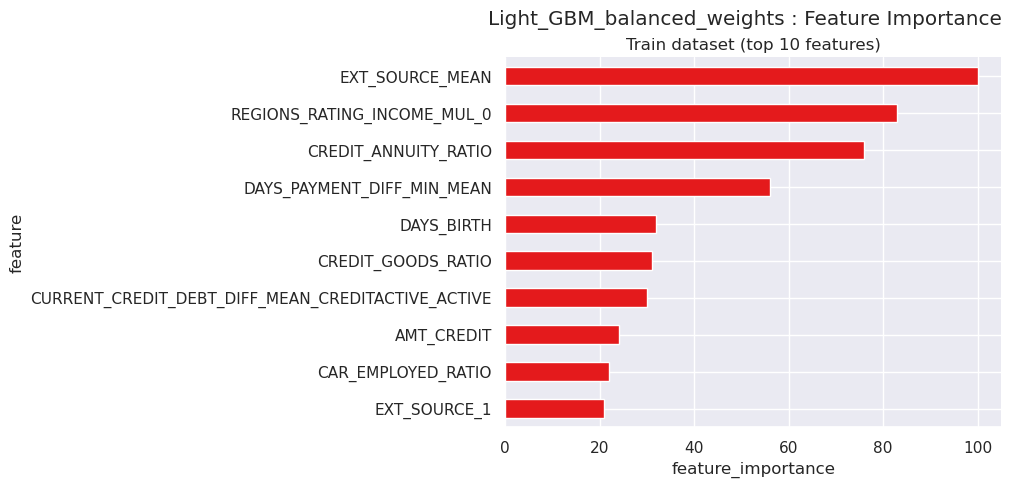

In [33]:
best_model_name = 'Light_GBM_balanced_weights'
plot_feature_importances(best_model, X_train, best_model_name)


<a id='best_model_permutation_based_feat_imp'></a>

### <span style='background:#0075bc'><span style='color:white'>Permutation-based feature importance</span></span>

(sklearn.inspection.permutation_importance)

- computé sur le jeu de test
- basé sur permutation de valeurs dans chaque feature pour voir l'impact sur la prédiction

- <https://scikit-learn.org/stable/modules/permutation_importance.html>
- <https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html>


In [34]:
from sklearn.inspection import permutation_importance


def evaluate_permutation_importance(model, X_val, y_val, scoring='roc_auc',
                                    model_name='',
                                    n_jobs=1):
    """Evaluates and plots validation dataset feature importances (X_val, y_val)"""

    # Predictions with the validation set
    y_pred = model.predict(X_val)

    # Probabilities
    y_proba = model.predict_proba(X_val)[:, 1]

    # Business metric
    business_metric = custom_score(y_val, y_pred)
    business_scorer = make_scorer(tools_modeling.custom_score,
                             greater_is_better=True)

    nb_features = len(X_val.columns)

    print(X_val.shape)
    print(y_val.shape)

    # Linear regressors
    nb_repeats = 20
    importance = permutation_importance(
        model,
        X_val,
        y_val,
        scoring=scoring,
        n_jobs=n_jobs,
        random_state=seed,
        n_repeats=nb_repeats,
    )

    # save detailed importance
    df_imp = pd.DataFrame(
        {'feature': X_val.columns,
         'importances_mean': importance['importances_mean'],
         'importances_std': importance['importances_std'],
         }
    )
    df_imp = df_imp.sort_values(by='importances_mean', ascending=False)
    nb = min(nb_features, 10)
    data = df_imp.head(nb)
    x = data['importances_mean']
    y = data['feature']
    err_bar = np.array(data['importances_std']*2)
    print(err_bar)
    ax = sns.barplot(data=df_imp.head(10), y='feature', x='importances_mean')
    plt.errorbar(x, y, xerr=err_bar, fmt=".", color="red")
    plt.suptitle(f'{model_name} Feature Importance')
    ax.set_title(f'Validation dataset ({nb_repeats} permutations)')
    ax.set_xlabel('importance (mean)')
    sns.despine()
    plt.show()
    print(f'\n scoring {scoring}')
    print('\n error_bar = mean +/- 2*std (n_repeats=20)')

(61503, 33)
(61503,)
[0.0060354  0.00251626 0.00128835 0.00138518 0.0010397  0.00059692
 0.00091056 0.00084223 0.00054335 0.00059154]


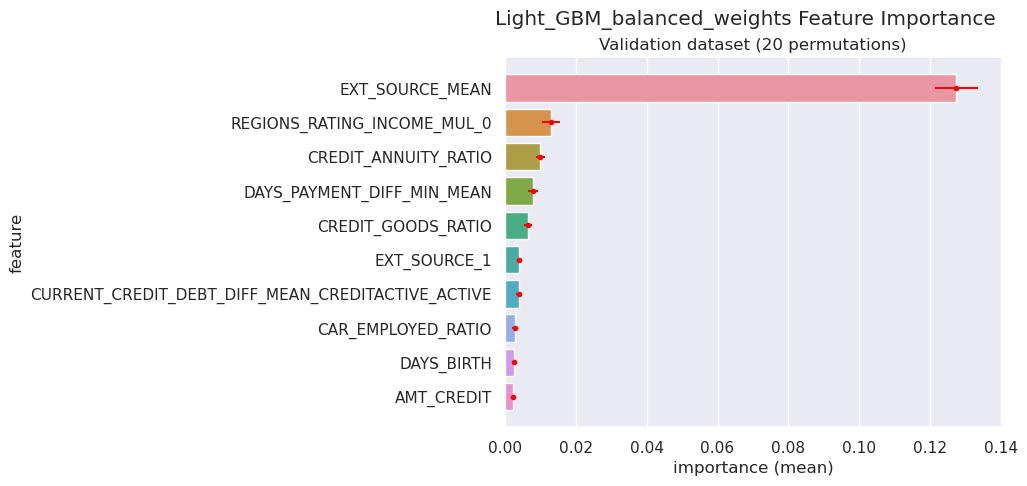


 scoring roc_auc

 error_bar = mean +/- 2*std (n_repeats=20)


In [35]:
evaluate_permutation_importance(best_model,
                                X_val, y_val,
                                model_name=best_model_name,
                                scoring='roc_auc')


(61503, 33)
(61503,)
[0.0102884  0.00504133 0.00386476 0.00442456 0.00505952 0.00386497
 0.00386665 0.00279779 0.00215574 0.00254893]


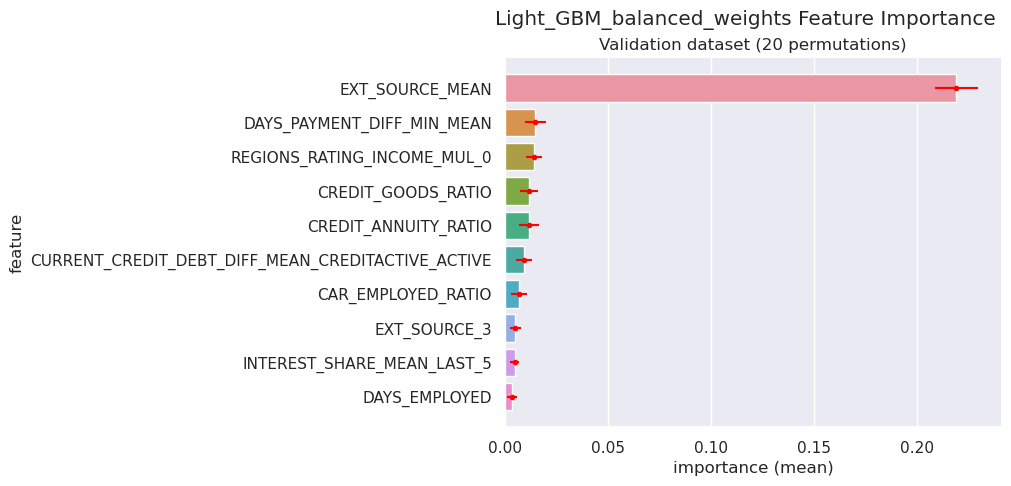


 scoring recall

 error_bar = mean +/- 2*std (n_repeats=20)


In [48]:
evaluate_permutation_importance(best_model,
                                X_val, y_val,
                                model_name=best_model_name,
                                scoring="recall")


<a id='best_model_shap_interpretability'></a>

## <span style='background:#0085dd'><span style='color:white'>Shap interpretability</span></span>

<a id='best_model_create_explainer'></a>

### <span style='background:#0075bc'><span style='color:white'>Create an explainer for the best model</span></span>

In [37]:
# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

# Train shap explainer using validation set
explainer = shap.TreeExplainer(best_model.named_steps['clf'], X_val)

In [38]:
# Save explainer
path_explainer = '/home/raquelsp/Documents/Openclassrooms/P7_implementez_modele_scoring/P7_travail/P7_scoring_credit/model_tests/lgbm_explainer.pkl'

with open(path_explainer, 'wb') as f:
    pickle.dump(explainer, f, pickle.HIGHEST_PROTOCOL)

In [39]:
lgbm_shap_values = explainer.shap_values(X_val, check_additivity=False)

 98%|===================| 60395/61503 [00:51<00:00]        

<a id='best_model_global_interpretability'></a>

### <span style='background:#0075bc'><span style='color:white'>Global interpretability</span></span>

**Feature importances from shap**


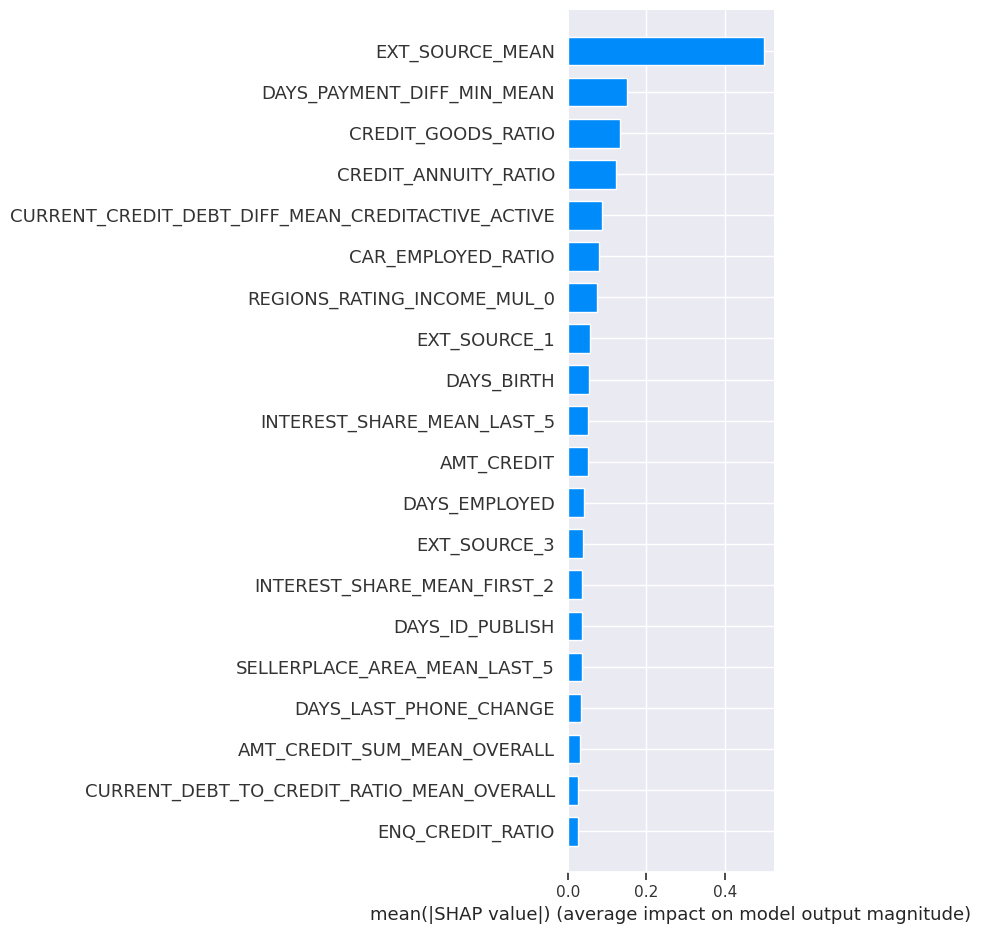

In [40]:
shap.summary_plot(lgbm_shap_values,
                  X_val, plot_type="bar")


**Distribution of shap values for all customers on features (beeswarm plot)**

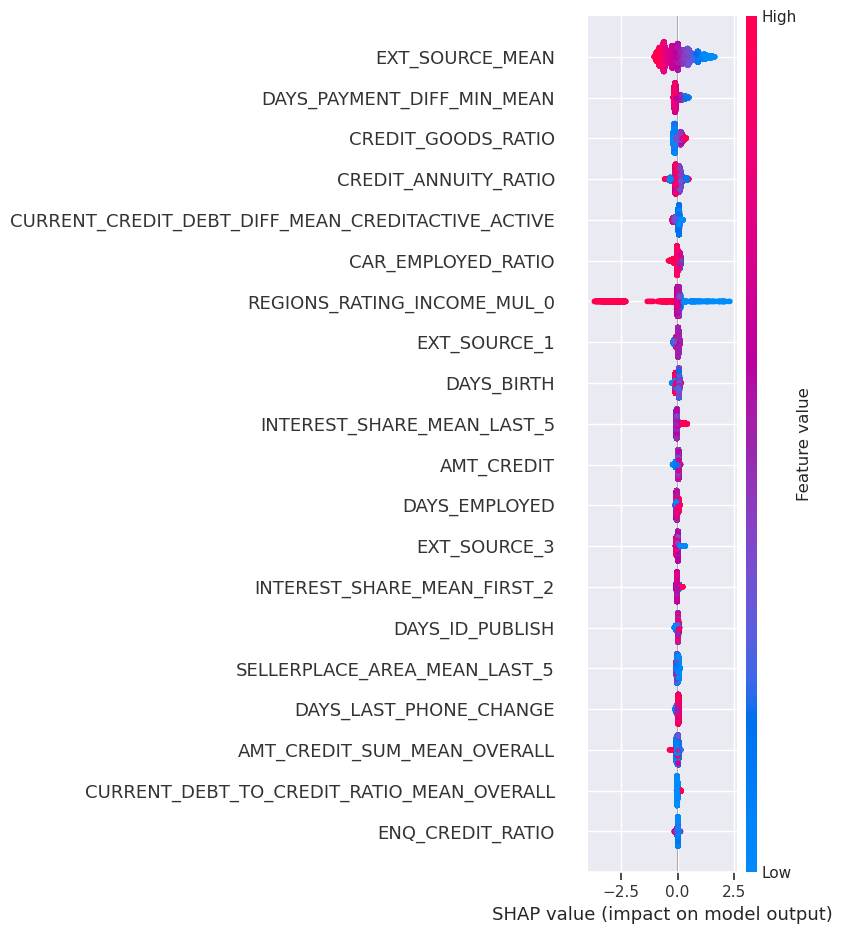

In [41]:
shap.summary_plot(lgbm_shap_values, X_val)


<a id='best_model_local_interpretability'></a>

### <span style='background:#0075bc'><span style='color:white'>Local interpretability</span></span>

**Explanation for the first X_val row**

In [42]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[0, :], X_val.iloc[0, :])


In [43]:
def get_explanation(X_val:pd.DataFrame,
                    shap_values:np.ndarray,
                    idx:int,
                    expected_value) -> shap.Explanation:
    feature_names=list(X_val.columns)
    exp = shap.Explanation(shap_values[idx, :],
                           base_values=expected_value,
                           feature_names=feature_names,
                           data=X_val.iloc[idx, :]
                    )
    return exp

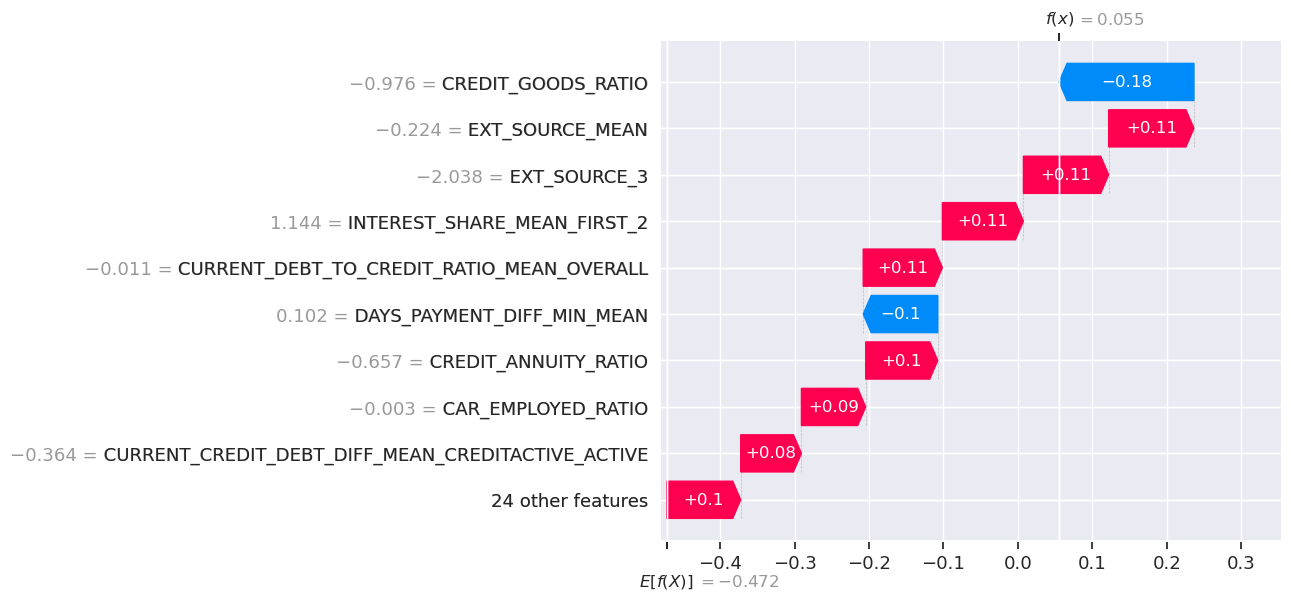

In [44]:
exp_0=get_explanation(X_val, lgbm_shap_values, 0, explainer.expected_value)
shap.plots.waterfall(exp_0, max_display=10)

**Explanation for a customer at HIGH risk of default**


idx for the client with the highest risk = 1

Client with the highest risk, SK_ID_CURR = 412588, y_proba=True


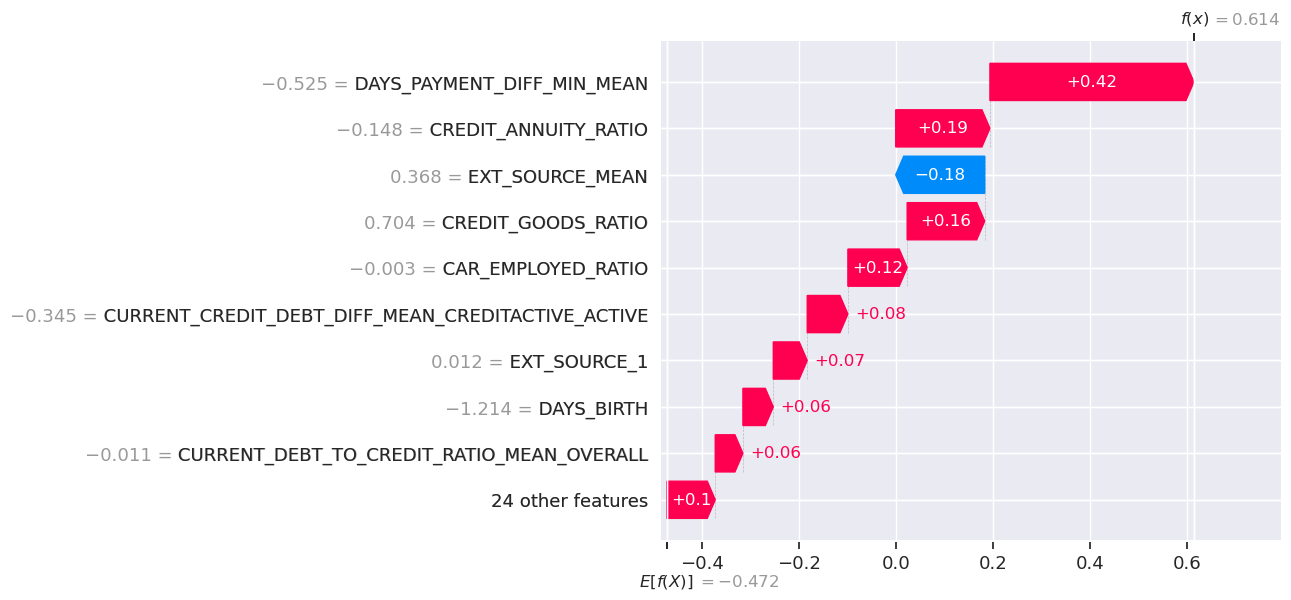

In [45]:
y_proba=best_model.predict_proba(X_val)[:,1] >0.66
highest_risk=int(np.argmax(y_proba))
print(f'\nidx for the client with the highest risk = {highest_risk}')

sk_id_curr = X_val.iloc[[highest_risk],:].index.tolist()[0]
print(f'\nClient with the highest risk, SK_ID_CURR = {sk_id_curr}, y_proba={y_proba[highest_risk]}')

exp_high_risk = get_explanation(X_val,
                                lgbm_shap_values,
                                highest_risk,
                                explainer.expected_value)

shap.plots.waterfall(exp_high_risk, max_display=10)

**Explanation for a customer at LOW risk of default**


idx for the client with the lowest risk = = 0

Client with the highest risk, SK_ID_CURR =  272933, y_proba=False


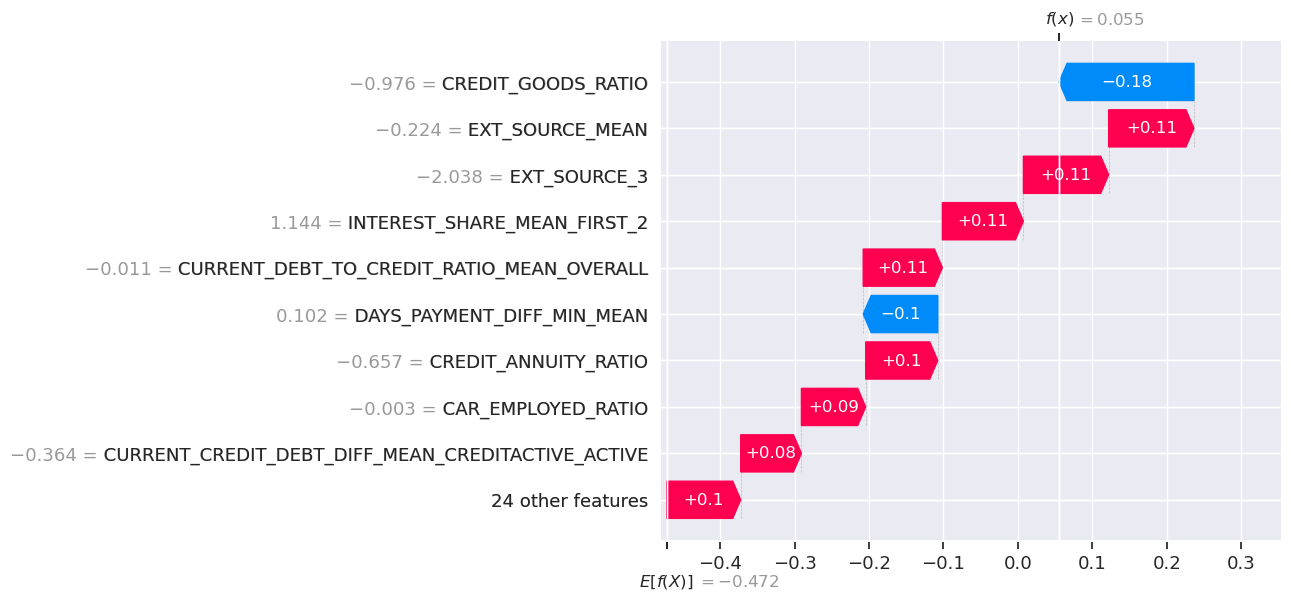

In [46]:
y_proba = best_model.predict_proba(X_val)[:, 1]>0.66

lowest_risk = int(np.argmin(y_proba))
print(f'\nidx for the client with the lowest risk = = {lowest_risk}')

sk_id_curr = X_val.iloc[[lowest_risk],:].index.tolist()[0]
print(f'\nClient with the highest risk, SK_ID_CURR =  {sk_id_curr}, y_proba={y_proba[lowest_risk]}')

exp_low_risk = get_explanation(X_val,
                               lgbm_shap_values,
                               lowest_risk,
                               explainer.expected_value)
shap.plots.waterfall(exp_low_risk, max_display=10)

**Explanation for the first 100 lines of X_val**

In [47]:
shap.force_plot(explainer.expected_value,
                lgbm_shap_values[:100, :],
                X_val.iloc[:100, :])


<a id='data_rebalancing'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**END** </span></span>
